In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pandas as pd
import glob
import json

dfs = []

for file in glob.glob('data/train*.json'):
    with open(file, 'r') as f:
        data = json.load(f)
        dfs.extend(data)

df = pd.DataFrame(dfs)

## number of patients

In [3]:
df["patientID"].nunique()

400

## number of studies

In [4]:
df["studyID"].nunique()

100

## number of patients per study

In [5]:
patients_per_study = df.groupby('studyID')['patientID'].nunique()

In [6]:
patients_per_study

studyID
1      86
2      49
3      94
4      23
5      97
       ..
96     23
97     90
98     33
99     87
100    50
Name: patientID, Length: 100, dtype: int64

In [7]:
# unique study IDs and corresponding study labels
unique_study_ids = patients_per_study.index
study_labels = [f'{study_id}' for study_id in unique_study_ids]

C:\Users\skim0\AppData\Local\Temp\ipykernel_39168\3331253191.py:10: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(-0.5, len(study_labels), 0.5)


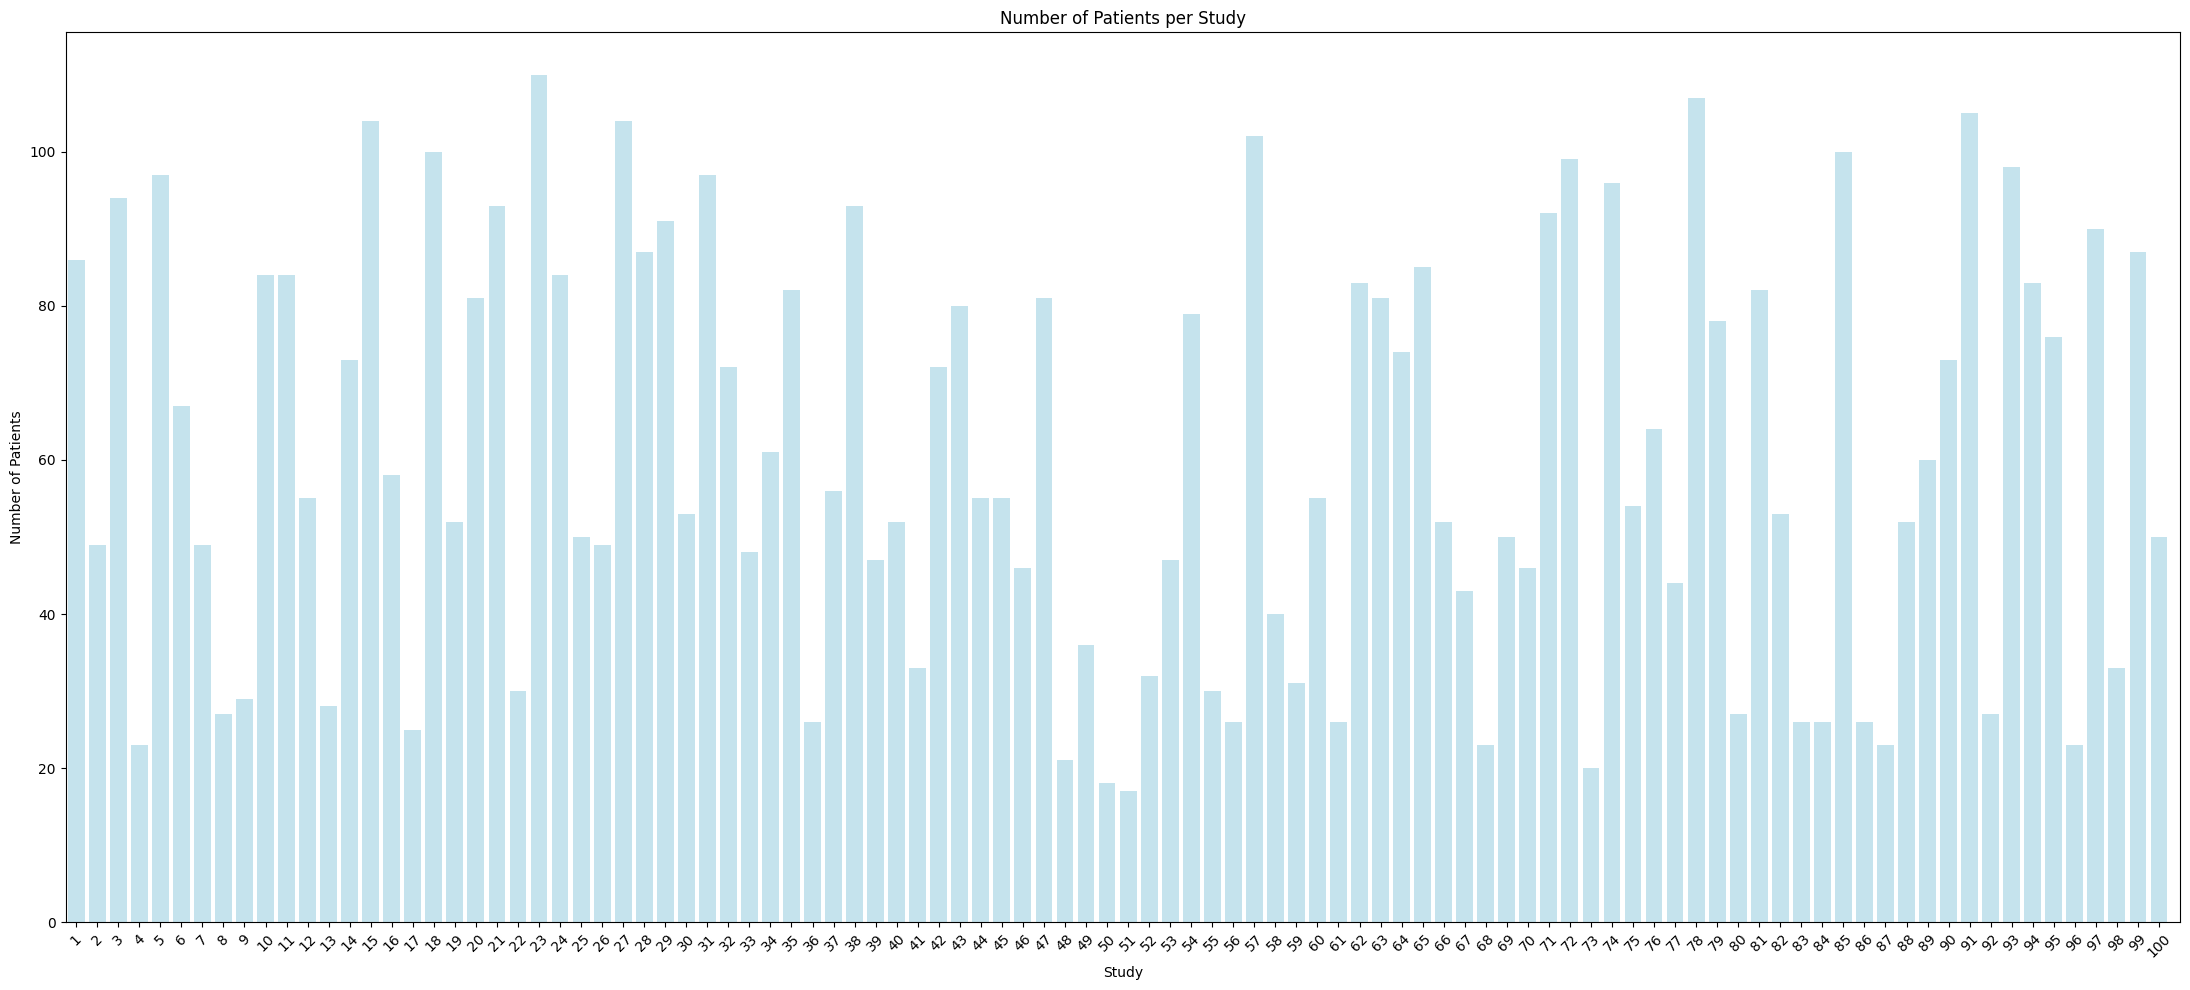

In [8]:
#viz
plt.figure(figsize=(22, 10))
plt.bar(study_labels, patients_per_study.values, color='lightblue', alpha=0.7)
plt.xlabel('Study')
plt.ylabel('Number of Patients')
plt.title('Number of Patients per Study')
plt.xticks(rotation=45)
plt.tight_layout()

plt.xlim(-0.5, len(study_labels), 0.5)
#plt.savefig("numberOfPatientsPerStudy_Graph1.png")
plt.show()

## sorted graph number of patient per study in descending order (i.e. most to least)

In [9]:
patients_per_study = df.groupby('studyID')['patientID'].nunique()
sorted_patients_per_study = patients_per_study.sort_values(ascending=False)

In [10]:
sorted_patients_per_study

studyID
23    110
78    107
91    105
27    104
15    104
     ... 
4      23
48     21
73     20
50     18
51     17
Name: patientID, Length: 100, dtype: int64

C:\Users\skim0\AppData\Local\Temp\ipykernel_39168\1612145686.py:10: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(-0.5, len(sorted_patients_per_study.values), 0.5)


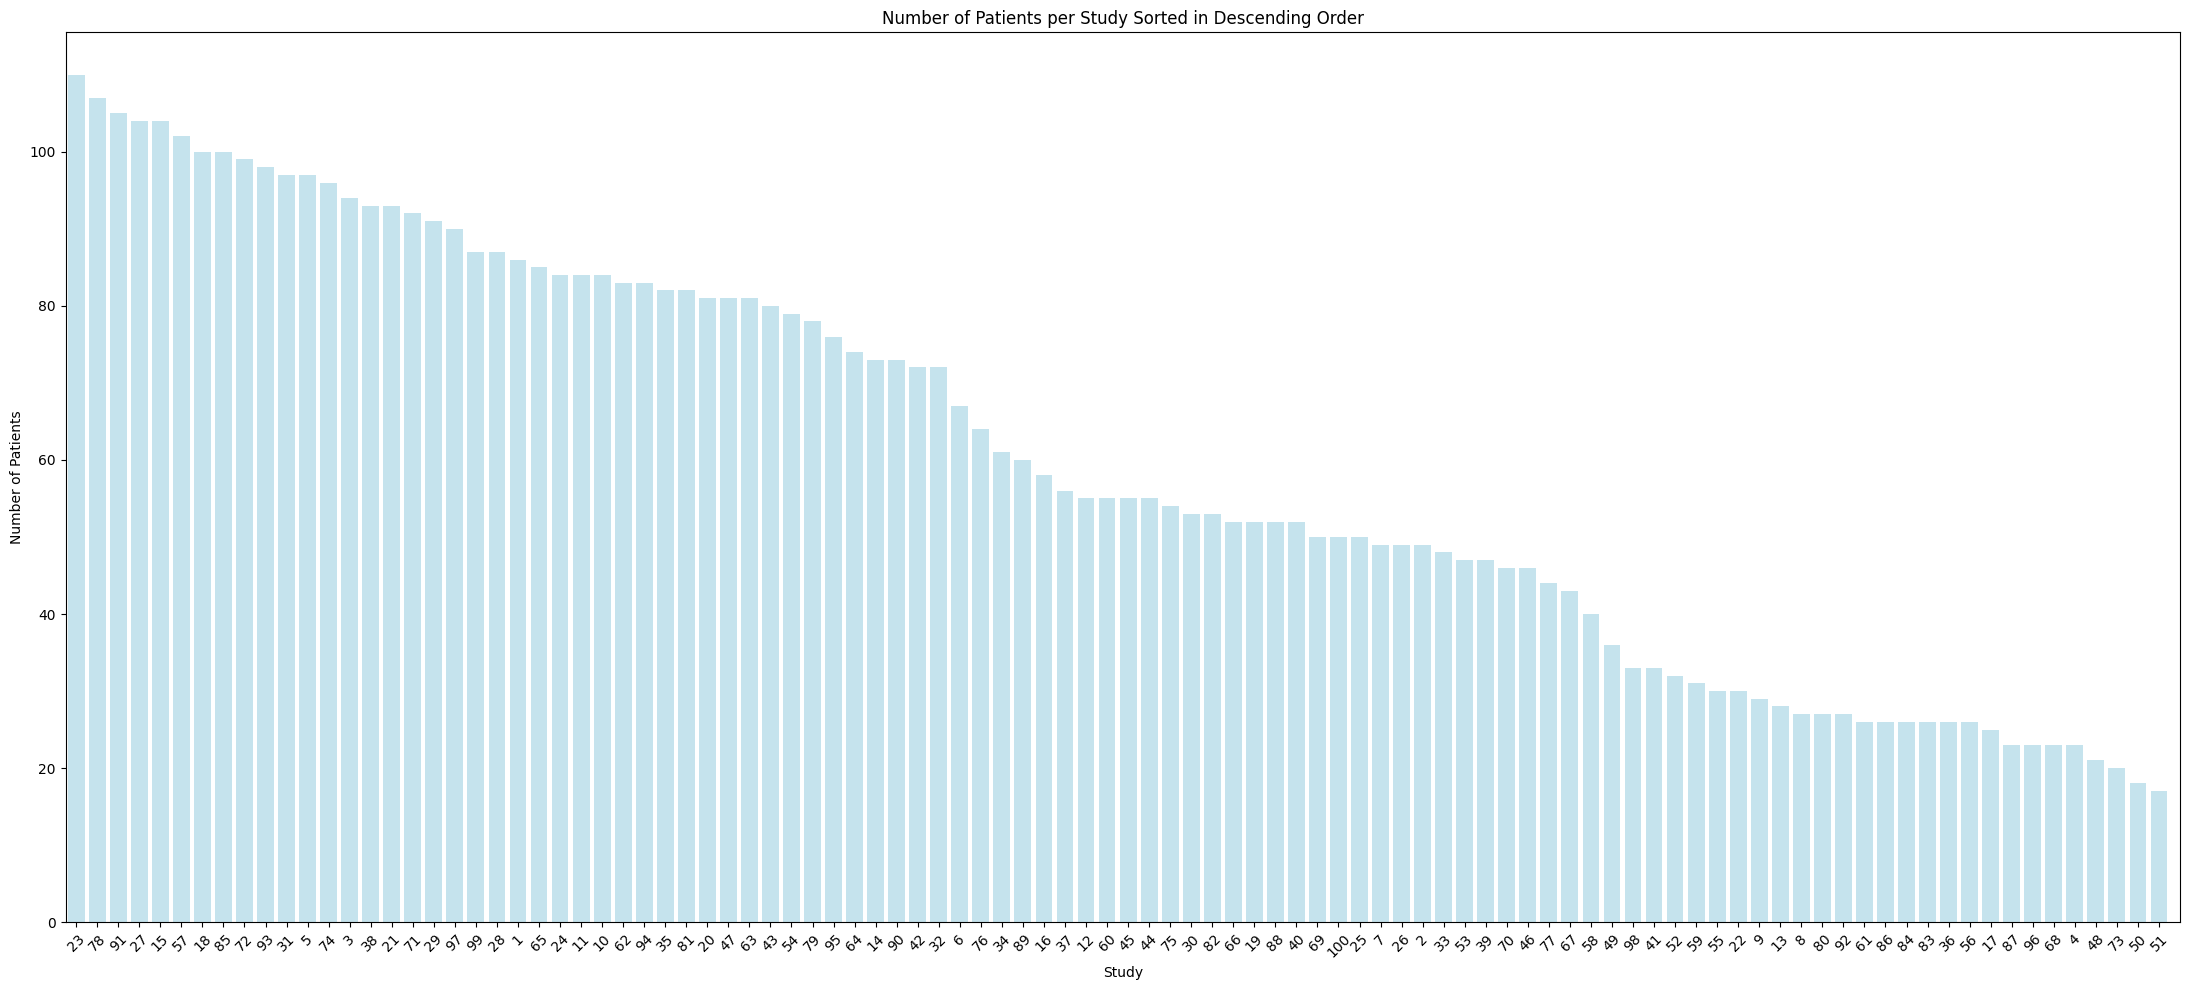

In [11]:
#viz
plt.figure(figsize=(22, 10))
plt.bar(sorted_patients_per_study.index.astype(str).tolist(), sorted_patients_per_study.values, color='lightblue', alpha=0.7)
plt.xlabel('Study')
plt.ylabel('Number of Patients')
plt.title('Number of Patients per Study Sorted in Descending Order')
plt.xticks(rotation=45)
plt.tight_layout()

plt.xlim(-0.5, len(sorted_patients_per_study.values), 0.5)
#plt.savefig("numberOfPatientsPerStudyDescendingOrder_Graph2.png")
plt.show()

C:\Users\skim0\AppData\Local\Temp\ipykernel_39168\4258596930.py:15: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(-0.5, len(sorted_patients_per_study.values), 0.5)


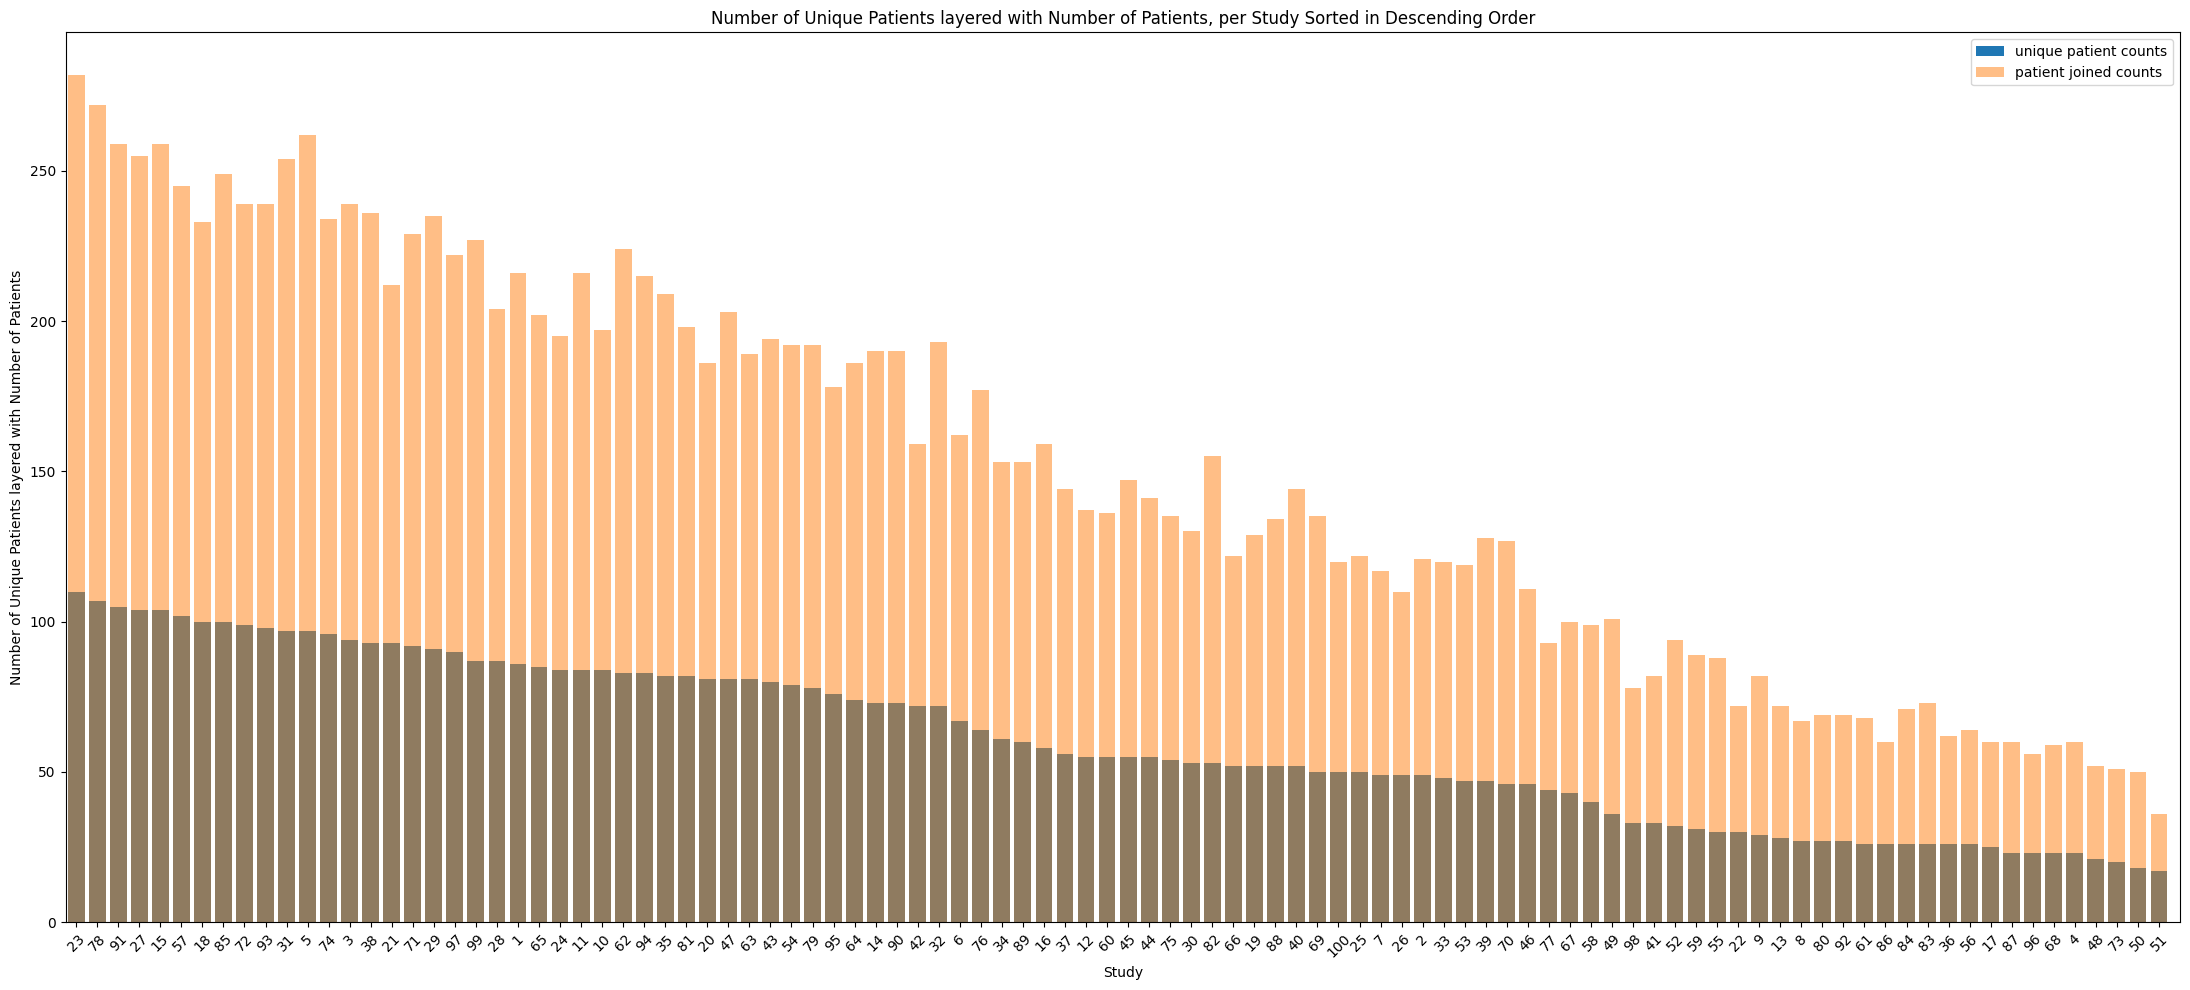

In [12]:
patients_per_study_non_unique = df.groupby('studyID')['patientID'].count()
sorted_patients_per_study_non_unique = patients_per_study_non_unique.sort_values(ascending=False)

#viz
plt.figure(figsize=(22, 10))
plt.bar(sorted_patients_per_study.index.astype(str).tolist(), sorted_patients_per_study.values, alpha=1, label="unique patient counts")
plt.bar(sorted_patients_per_study_non_unique.index.astype(str).tolist(), sorted_patients_per_study_non_unique.values, alpha=0.5, label="patient joined counts")
plt.xlabel('Study')
plt.ylabel('Number of Unique Patients layered with Number of Patients')
plt.title('Number of Unique Patients layered with Number of Patients, per Study Sorted in Descending Order')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()

plt.xlim(-0.5, len(sorted_patients_per_study.values), 0.5)
#plt.savefig("numberOfPatientsPerStudyDescendingOrder_Graph2.png")
plt.show()

## create graph where study is Y and patient is X

In [13]:
studies_counts_per_patient = df.groupby("patientID")["studyID"].nunique()

In [14]:
sorted_studies_counts_per_patient = studies_counts_per_patient.sort_values(ascending=False)
sorted_studies_counts_per_patient 

patientID
6422    28
2125    26
6401    26
4079    26
2003    23
        ..
8721     8
4426     8
6060     7
9245     5
9823     4
Name: studyID, Length: 400, dtype: int64

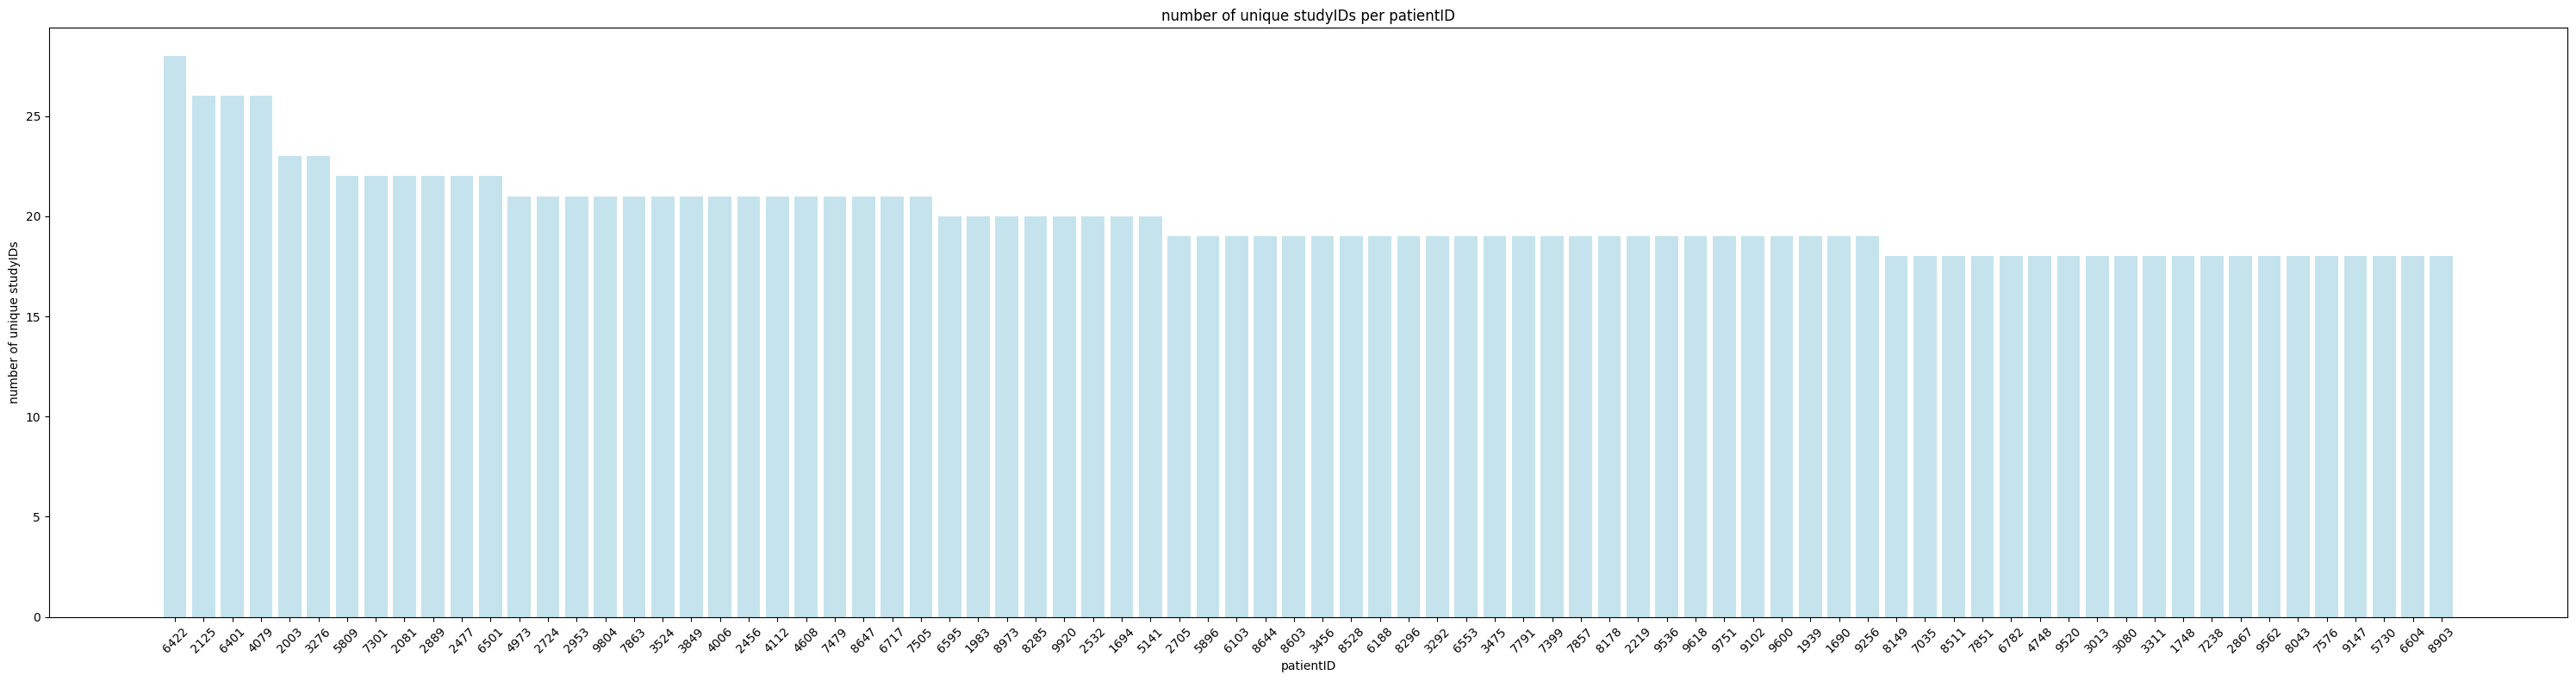

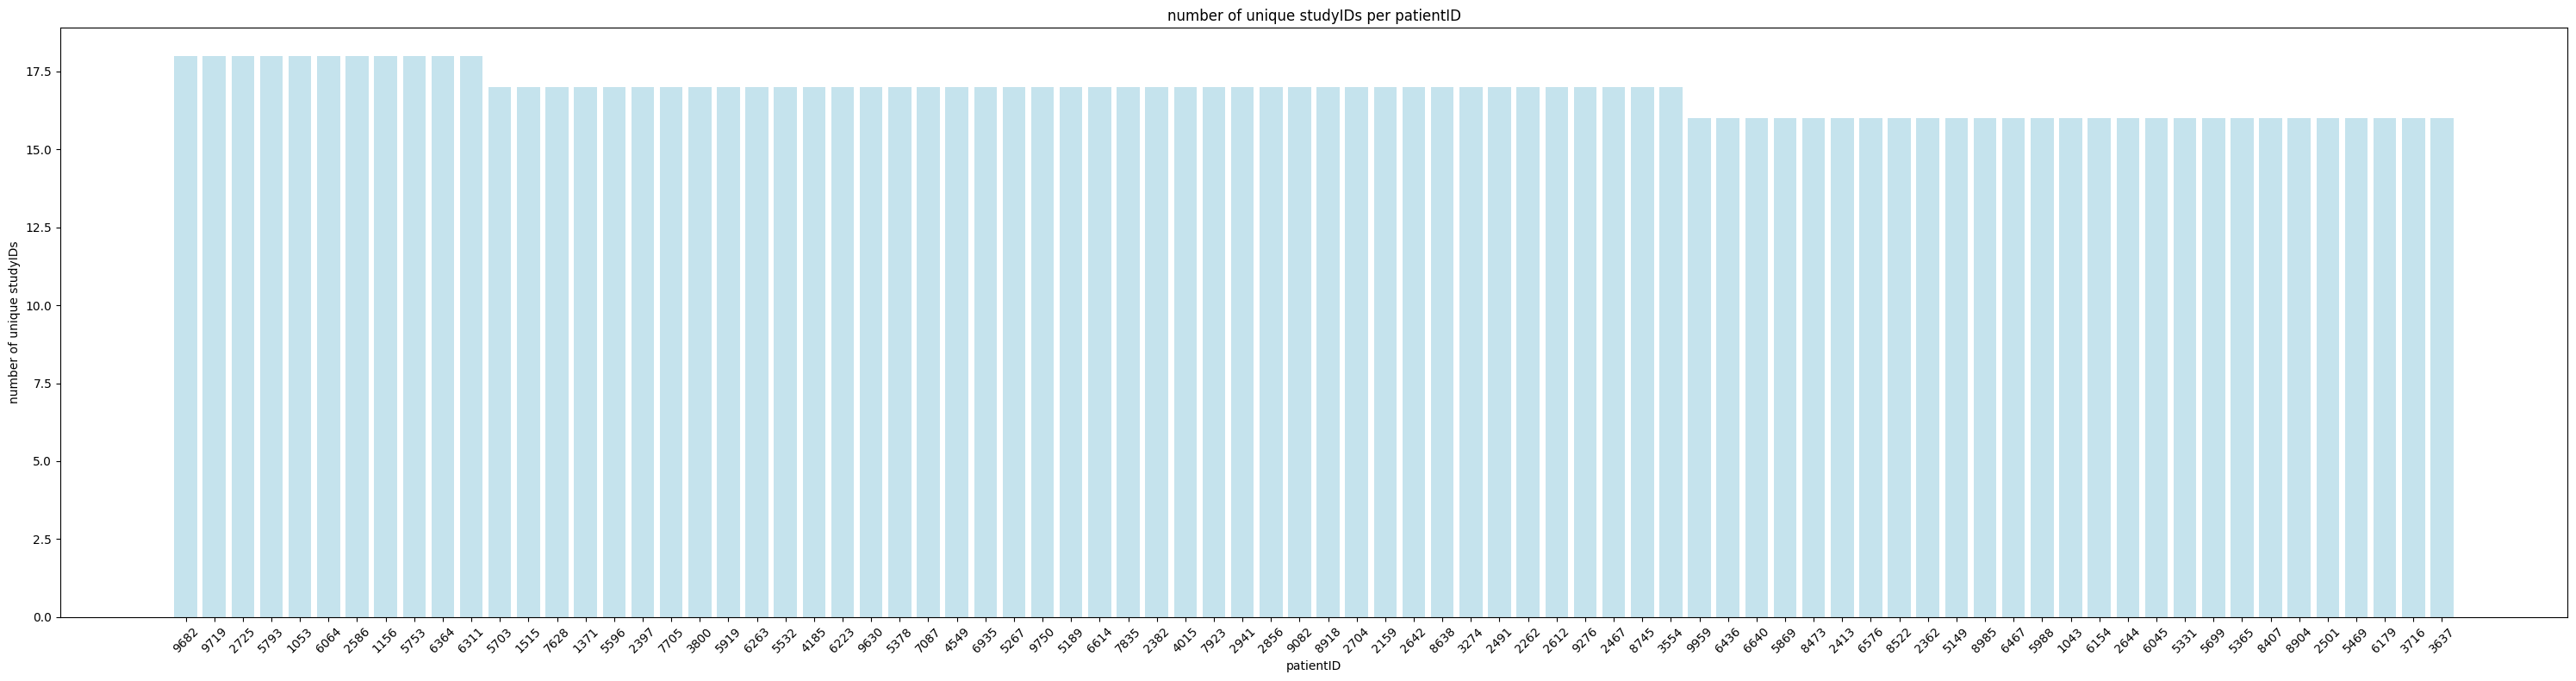

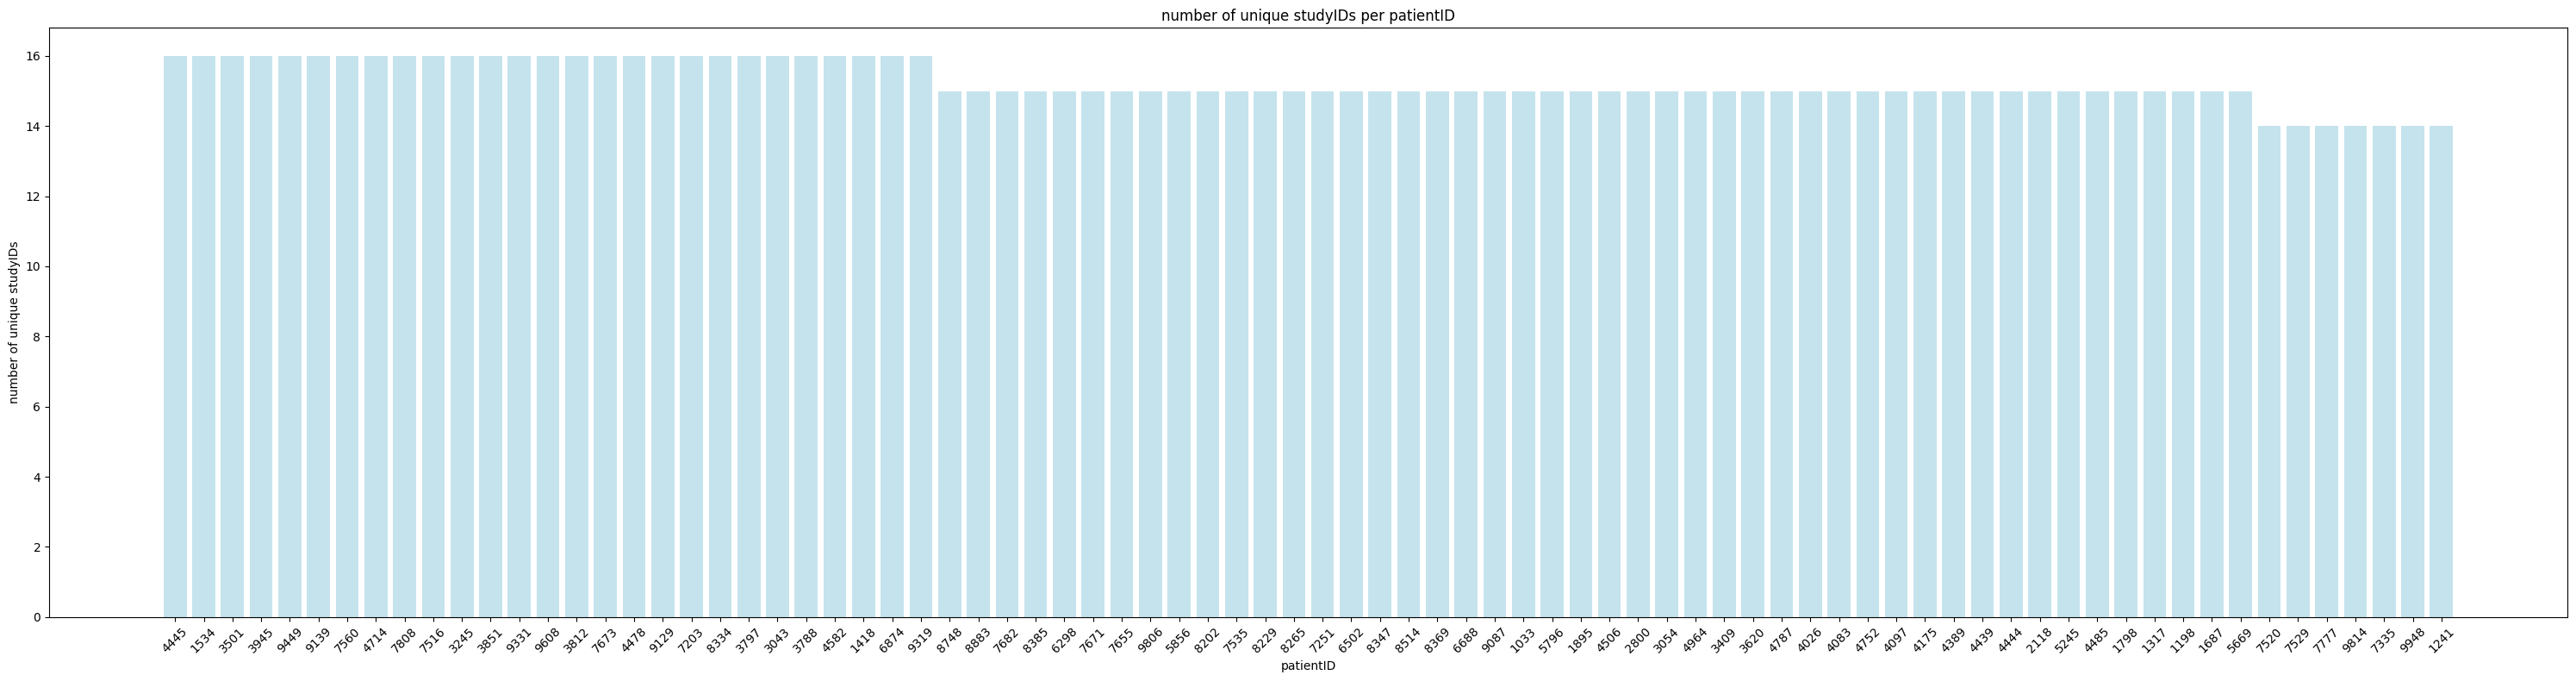

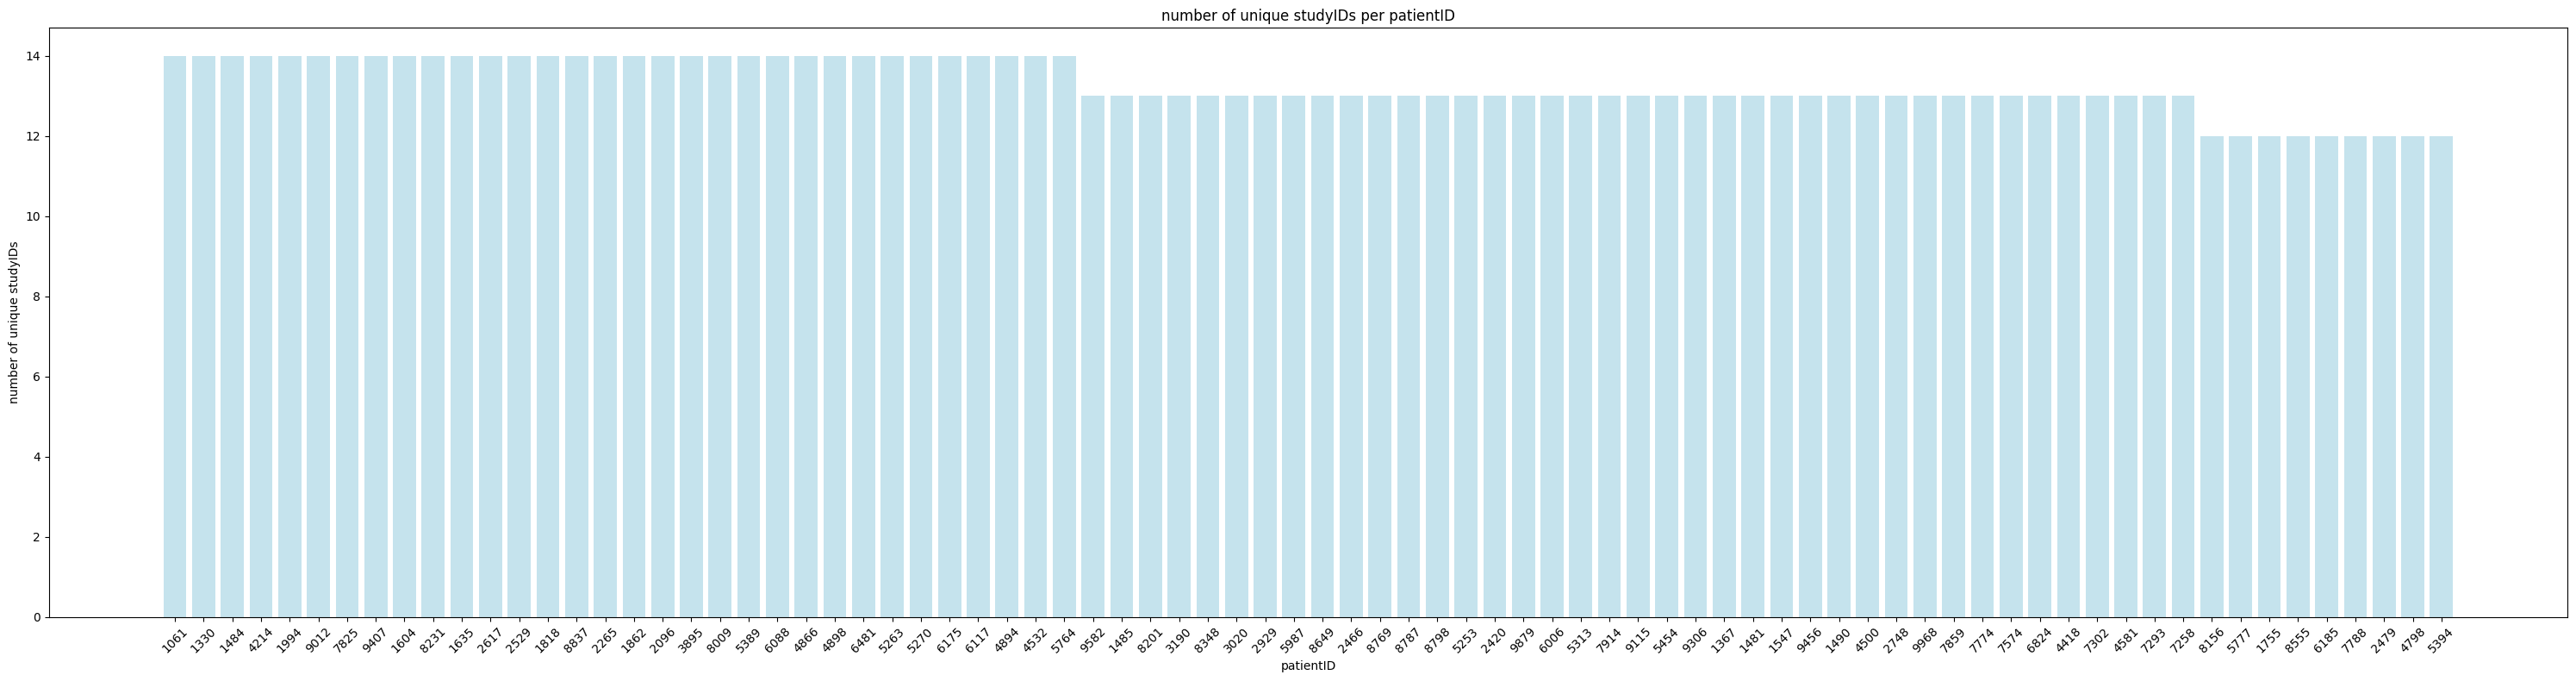

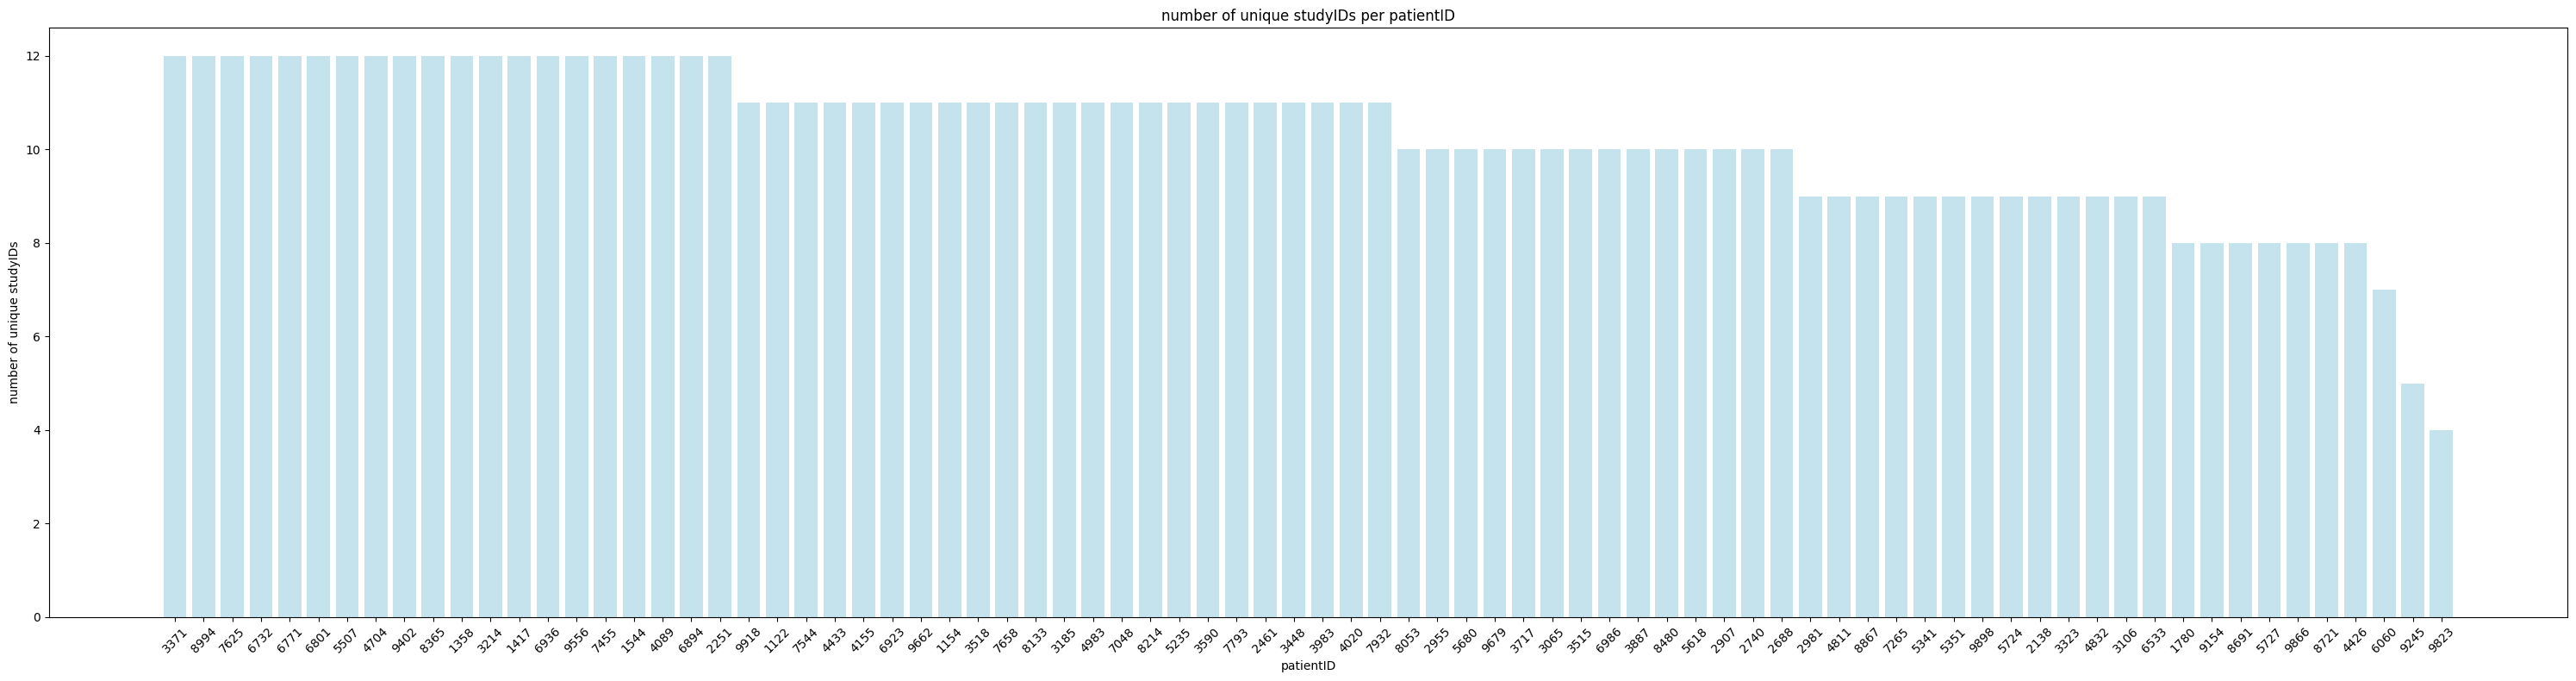

In [15]:
chunk_size = 80
ranges = list(range(0, df["patientID"].nunique(), chunk_size))
for i in ranges:
    plt.figure(figsize=(30,8))
    plt.bar(sorted_studies_counts_per_patient.index.astype(str).tolist()[i:i + chunk_size],
           sorted_studies_counts_per_patient.values[i:i + chunk_size], color="lightblue", alpha=0.7)
    plt.xlabel("patientID")
    plt.ylabel("number of unique studyIDs")
    plt.title("number of unique studyIDs per patientID")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## for every study: number of patients per category and corresponding date ranges

In [16]:
#changing timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")

In [17]:
# group by studyID and timestamp to find the interested date ranges per study
study_timestamp_ranges = df.groupby('studyID')['timestamp'].agg(['min', 'max'])

In [18]:
# get all possible timestamp ranges(intervals) for each study using the min max timestamps
timestamp_ranges = {}
for study_id, study_row in study_timestamp_ranges.iterrows():
    start_date = study_row['min']
    end_date = study_row['max']
    timestamp_ranges[study_id] = pd.date_range(start=start_date, end=end_date, freq='D')

In [19]:
# For each study and timestamp range, count the number of people per each category in the categorySharingChoices and save them in people_count_per_category_per_study_df
people_count_per_category_per_study_df = pd.DataFrame()
for study_id, timestamp_range in timestamp_ranges.items():
    for date_range in timestamp_range:
        # floor and ceiling by Day
        start_date = date_range.floor('D')
        end_date = date_range.ceil('D')
        
        study_data = df[(df['studyID'] == study_id) & (df['timestamp'] >= start_date) & (df['timestamp'] < end_date)]
        # get the counts here for the ranges captured in study_data
        study_counts = study_data.explode('categorySharingChoices')['categorySharingChoices'].value_counts().reset_index()
        study_counts.rename(columns={'categorySharingChoices': 'category'}, inplace=True)

        # make the resulting columns
        study_counts['studyID'] = study_id
        study_counts['date_range_start'] = start_date.strftime("%Y-%m-%d")
        study_counts['date_range_end'] = end_date.strftime("%Y-%m-%d")
        study_counts['date_range'] = f'{start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}'
        people_count_per_category_per_study_df = pd.concat([people_count_per_category_per_study_df, study_counts], ignore_index=True)

In [20]:
people_count_per_category_per_study_df

category  count  studyID  \
0                          05_Socioeconomic Status      1        1   
1                         01_Family Health History      1        1   
2      02_Current or Previous Disease or Condition      1        1   
3              03_Living Environment and Lifestyle      1        1   
4                                   04_Biospecimen      1        1   
...                                            ...    ...      ...   
36746                     06_Health Care Encounter     12      100   
36747                     01_Family Health History     11      100   
36748                   07_Laboratory Test Results     10      100   
36749                               04_Biospecimen      9      100   
36750                      05_Socioeconomic Status      6      100   

      date_range_start date_range_end                date_range  
0           2022-01-04     2022-01-05  2022-01-04 to 2022-01-05  
1           2022-01-10     2022-01-11  2022-01-10 to 2022-01-11  
2           2022-01-10     2022-01-11  2022-01-10 to 2022-01-11  
3           2022-01-10     2022-01-11  2022-01-10 to 2022-01-11  
4           2022-01-10     2022-01-11  2022-01-10 to 2022-01-11  
...                ...            ...                       ...  
36746       2022-02-12     2022-02-13  2022-02-12 to 2022-02-13  
36747       2022-02-12     2022-02-13  2022-02-12 to 2022-02-13  
36748       2022-02-12     2022-02-13  2022-02-12 to 2022-02-13  
36749       2022-02-12     2022-02-13  2022-02-12 to 2022-02-13  
36750       2022-02-12     2022-02-13  2022-02-12 to 2022-02-13  

[36751 rows x 6 columns]

In [21]:
df.sort_values(by='studyID', inplace=True)

# all unique category choice and element choices
unique_category_choices = set()
unique_element_choices = set()

for _, row in df.iterrows():
    unique_category_choices.update(row['categorySharingChoices'])
    unique_element_choices.update(row['elementSharingChoices'])

In [22]:
# group by studyID and timestamp to find the interested date ranges per study
study_timestamp_ranges = df.groupby('studyID')['timestamp'].agg(['min', 'max'])

In [23]:
# sort the choices alphabetically
sorted_category_choices = sorted(unique_category_choices)
sorted_element_choices = sorted(unique_element_choices)

# create dictionaries to store the count of unique choices for each study
category_choices_count = {study: {choice: 0 for choice in sorted_category_choices} for study in df['studyID'].unique()}
element_choices_count = {study: {choice: 0 for choice in sorted_element_choices} for study in df['studyID'].unique()}

In [24]:
# iterate through the df groupings per (patientID, studyID) to count the unique choices for each studies
for (patient_id, study_id), group in df.groupby(['patientID', 'studyID']):
    category_choices_set = set()
    element_choices_set = set()

    for category_choice in group['categorySharingChoices'].explode():
        if not pd.isnull(category_choice):
            category_choices_set.add(category_choice)

    for element_choice in group['elementSharingChoices'].explode():
        if not pd.isnull(element_choice):
            element_choices_set.add(element_choice)

    study = int(study_id)
    for choice in category_choices_set:
        category_choices_count[study][choice] += 1

    for choice in element_choices_set:
        element_choices_count[study][choice] += 1

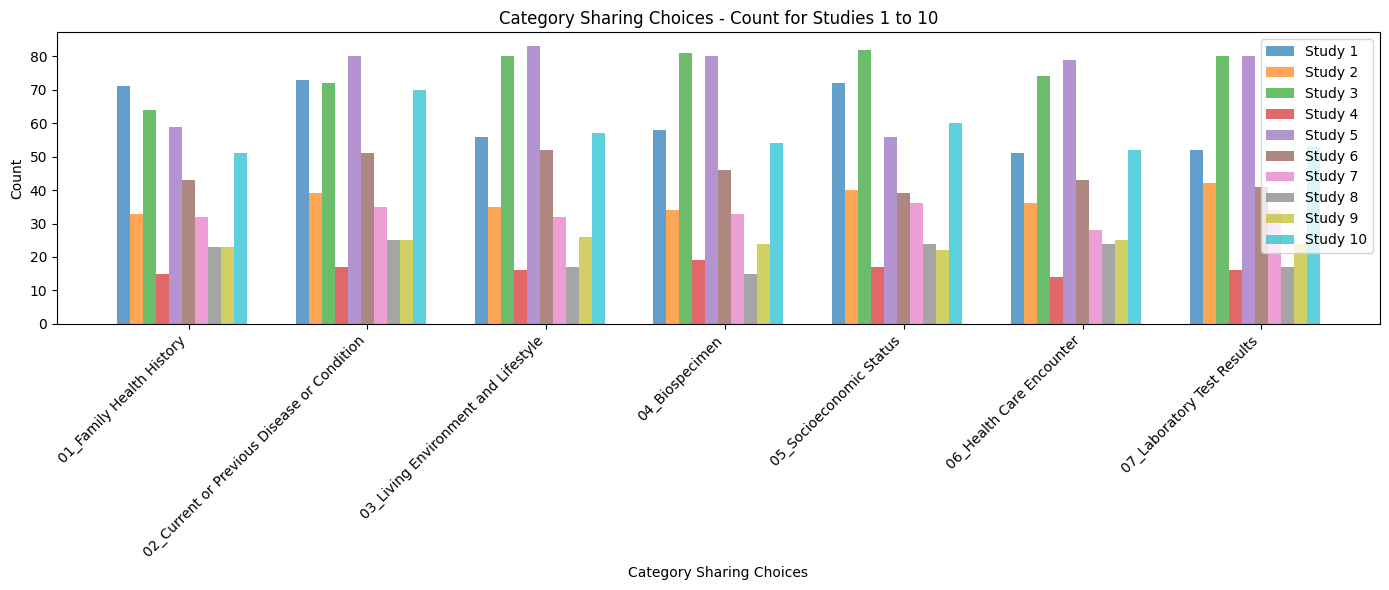

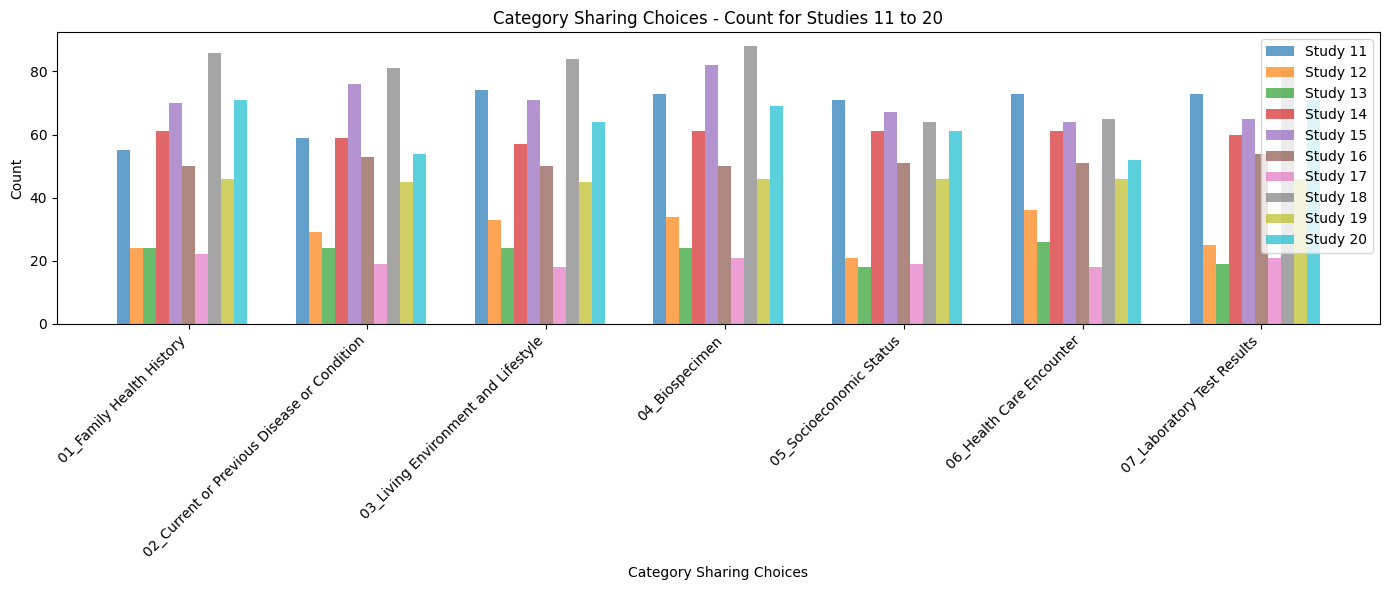

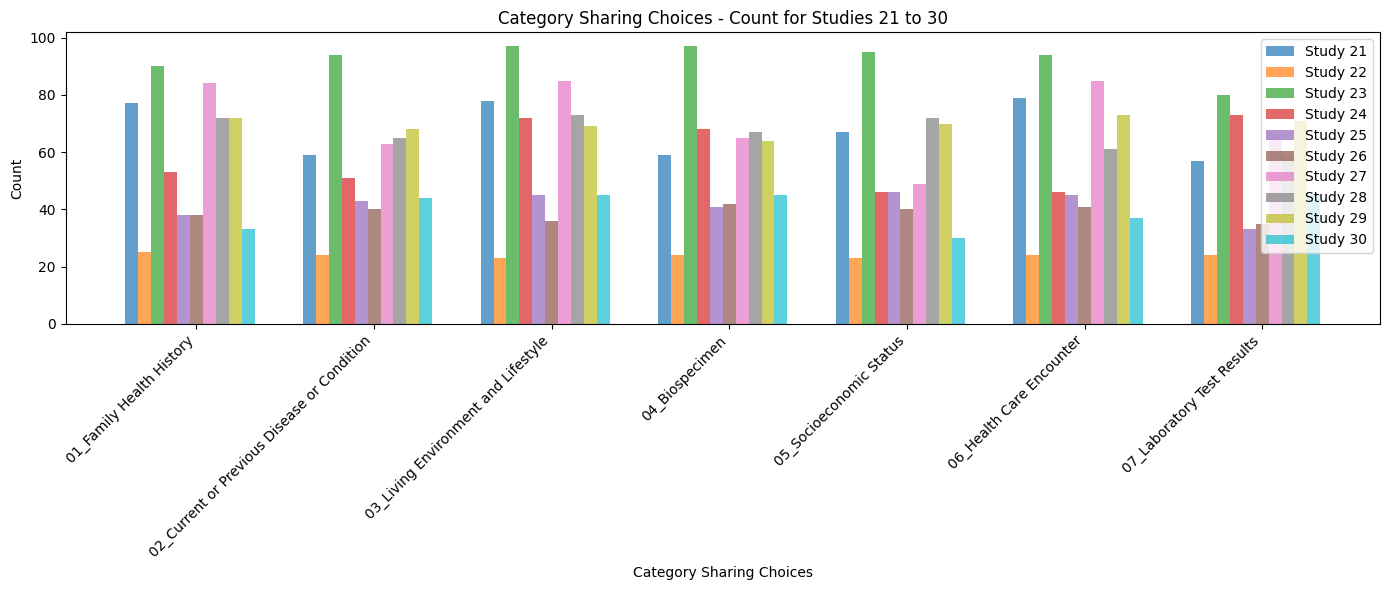

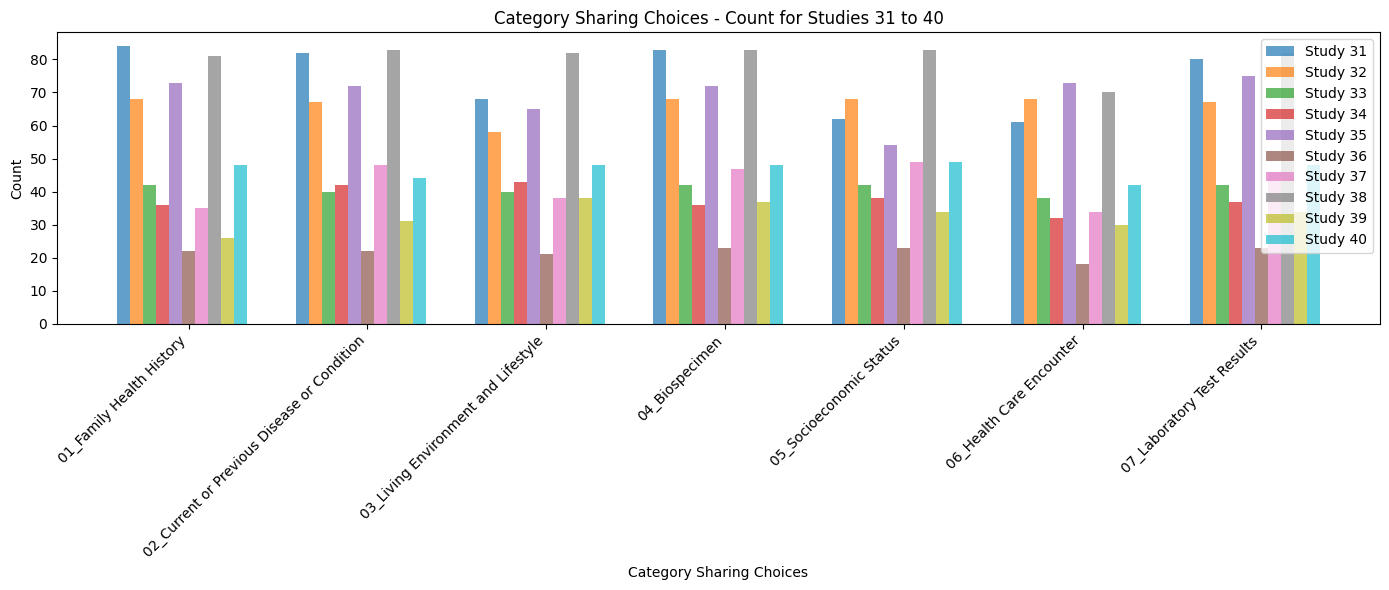

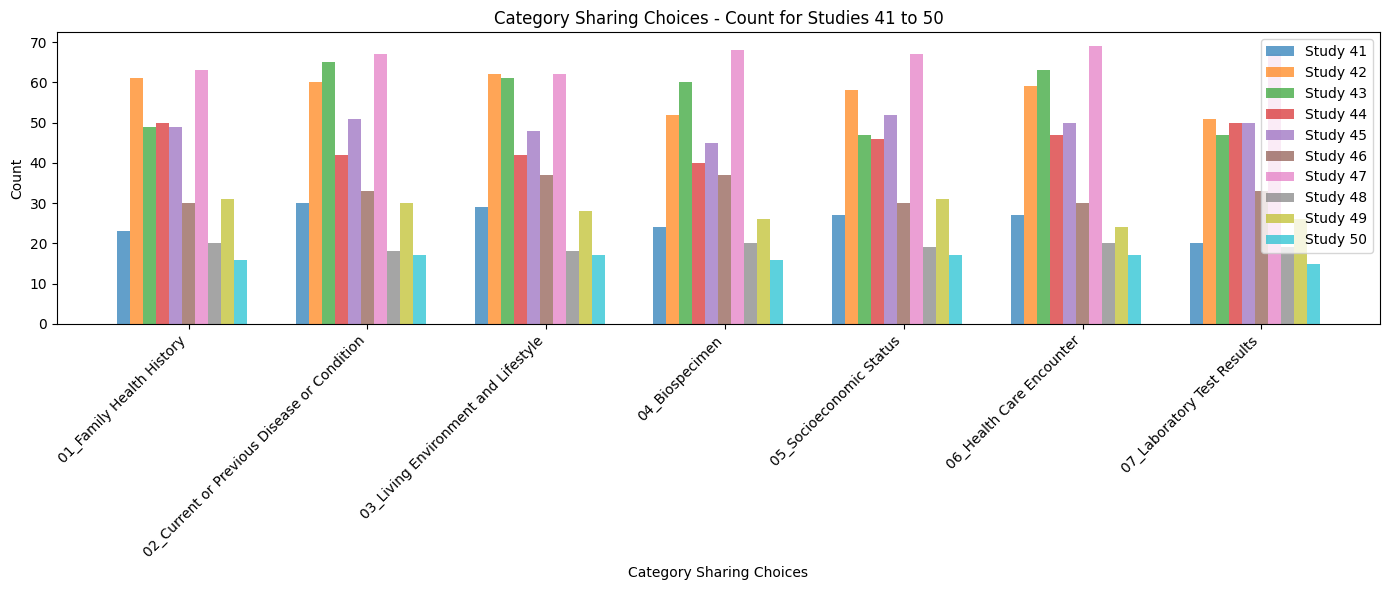

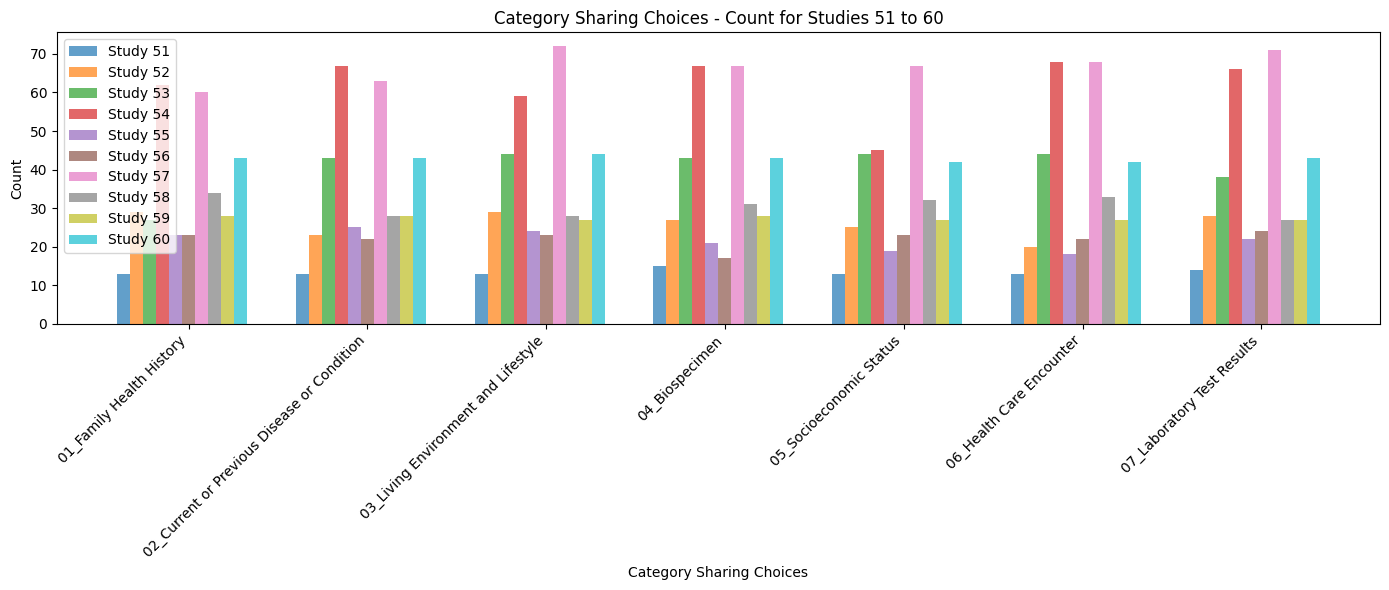

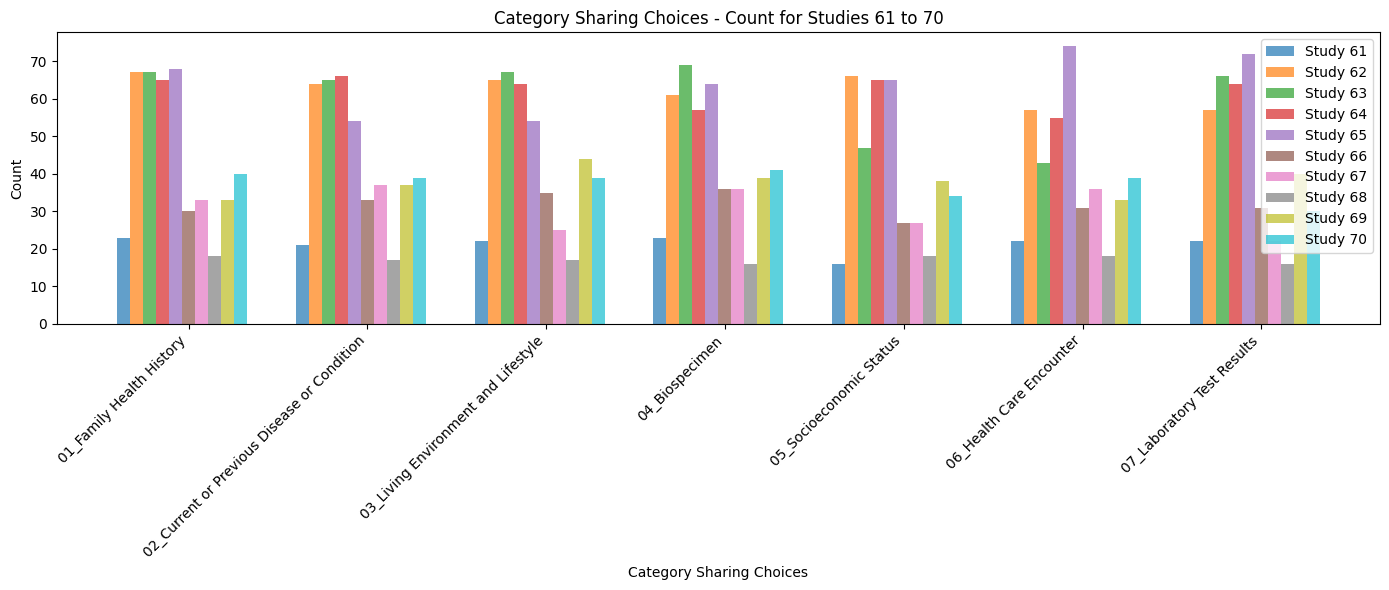

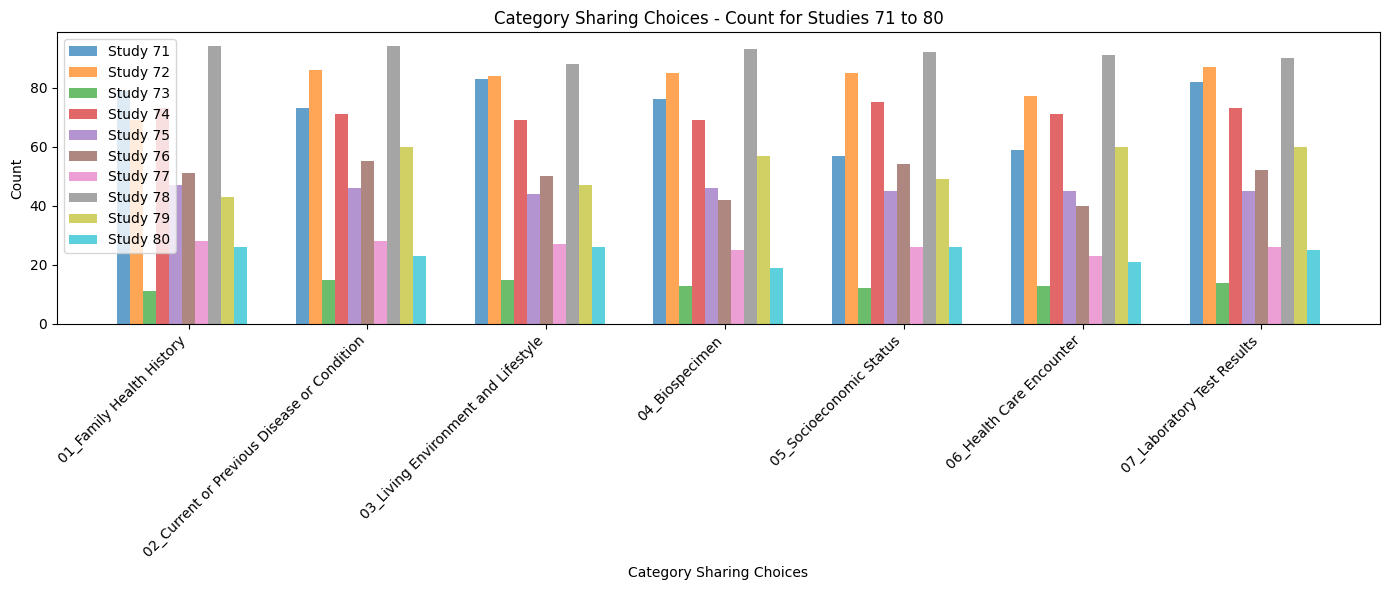

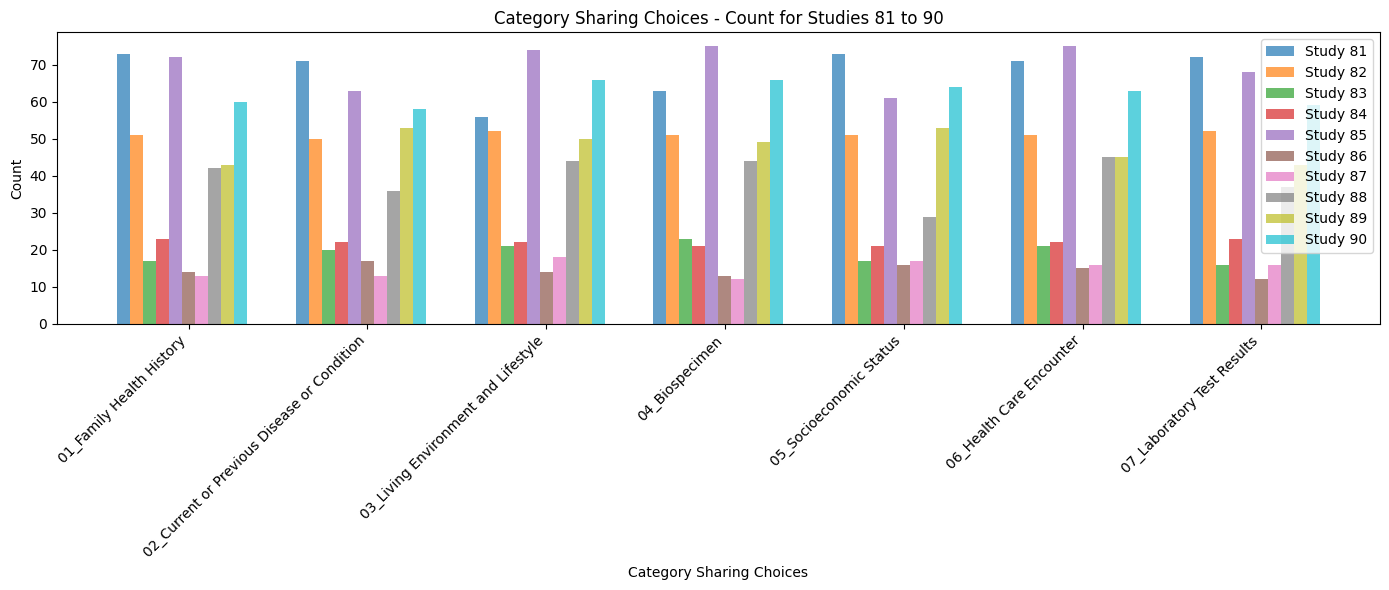

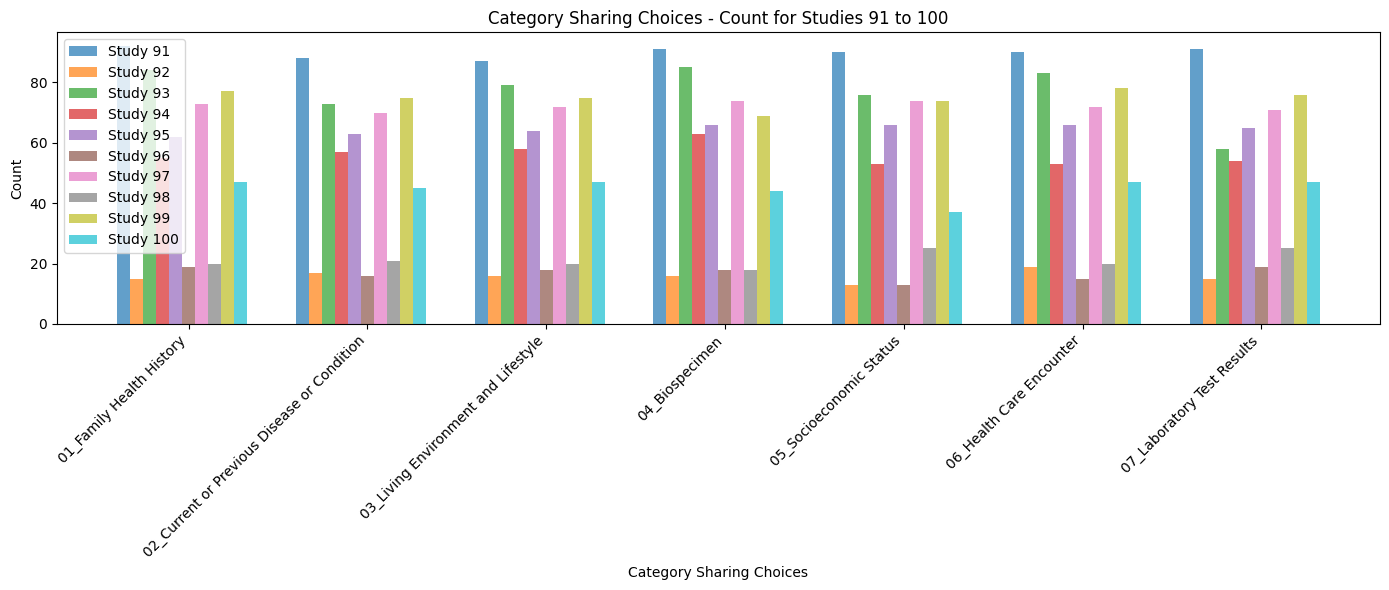

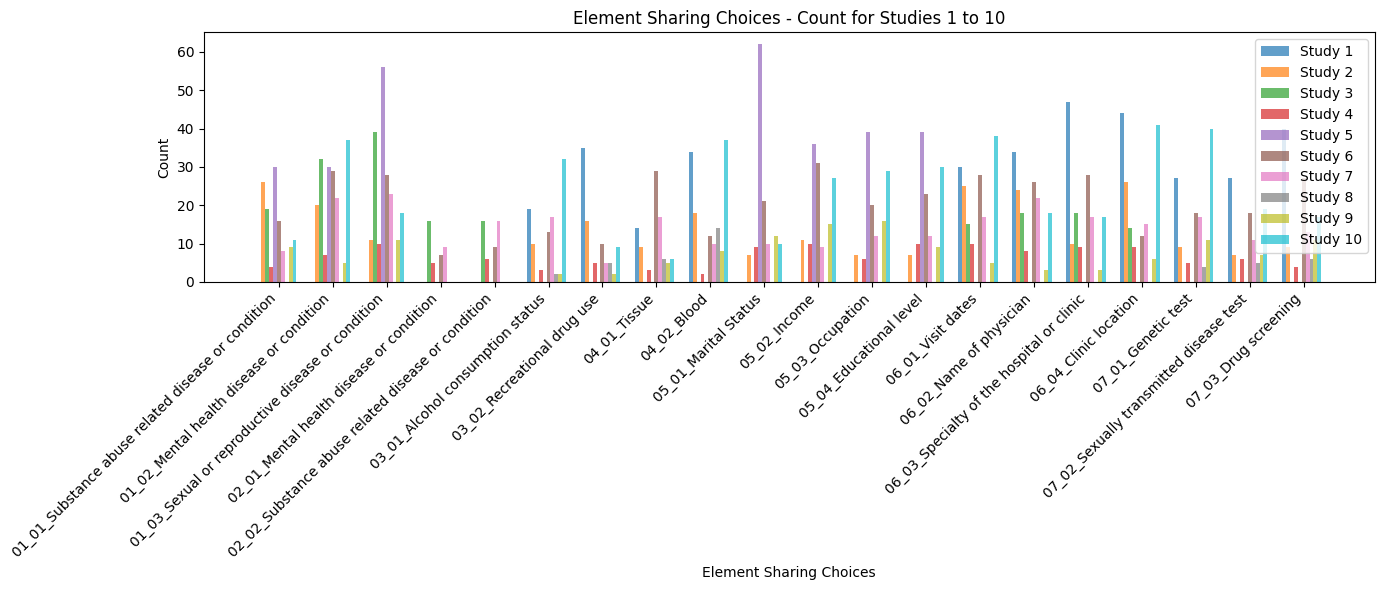

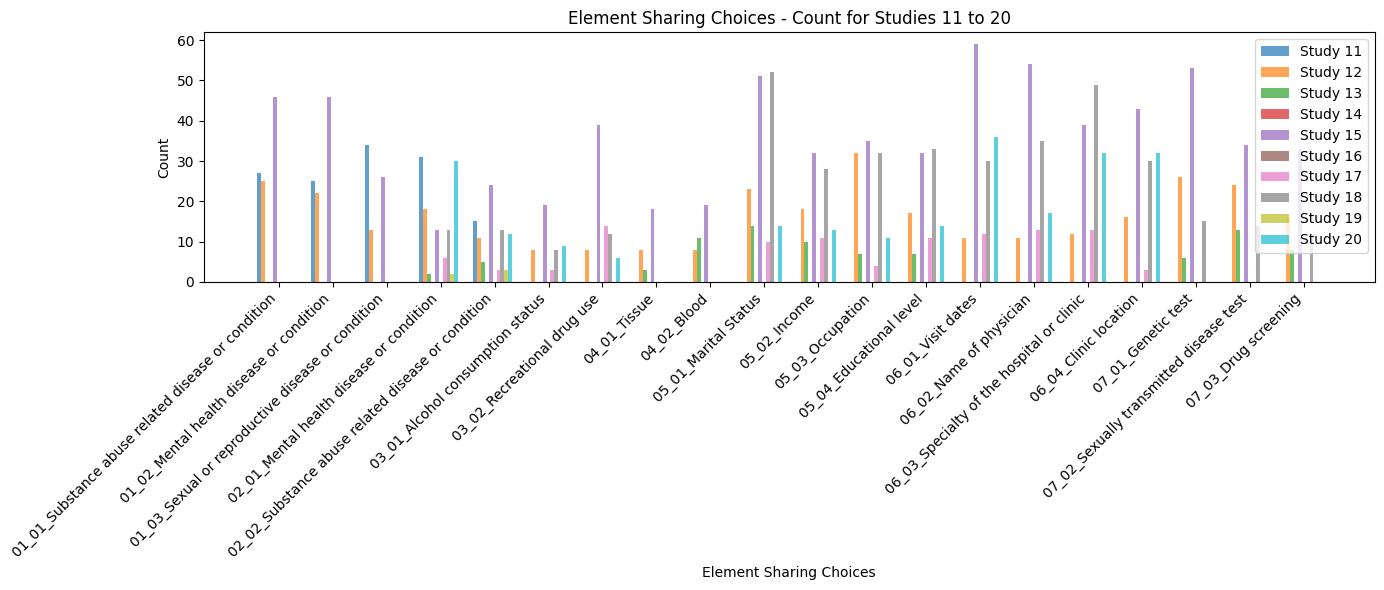

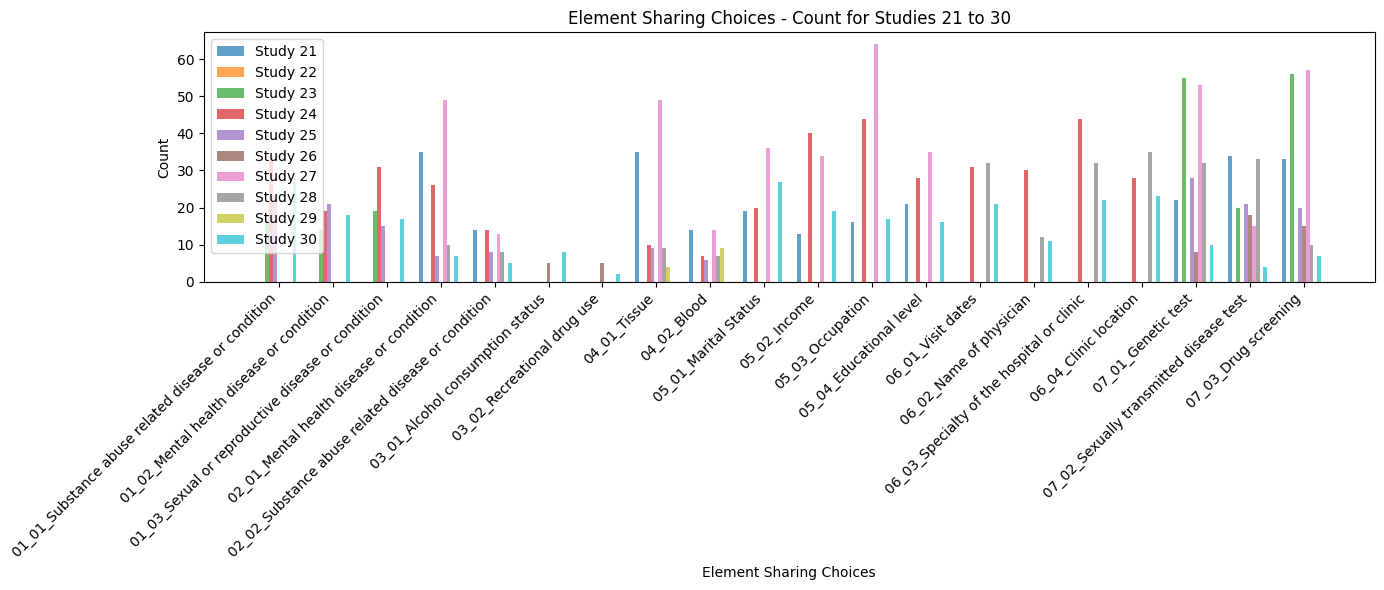

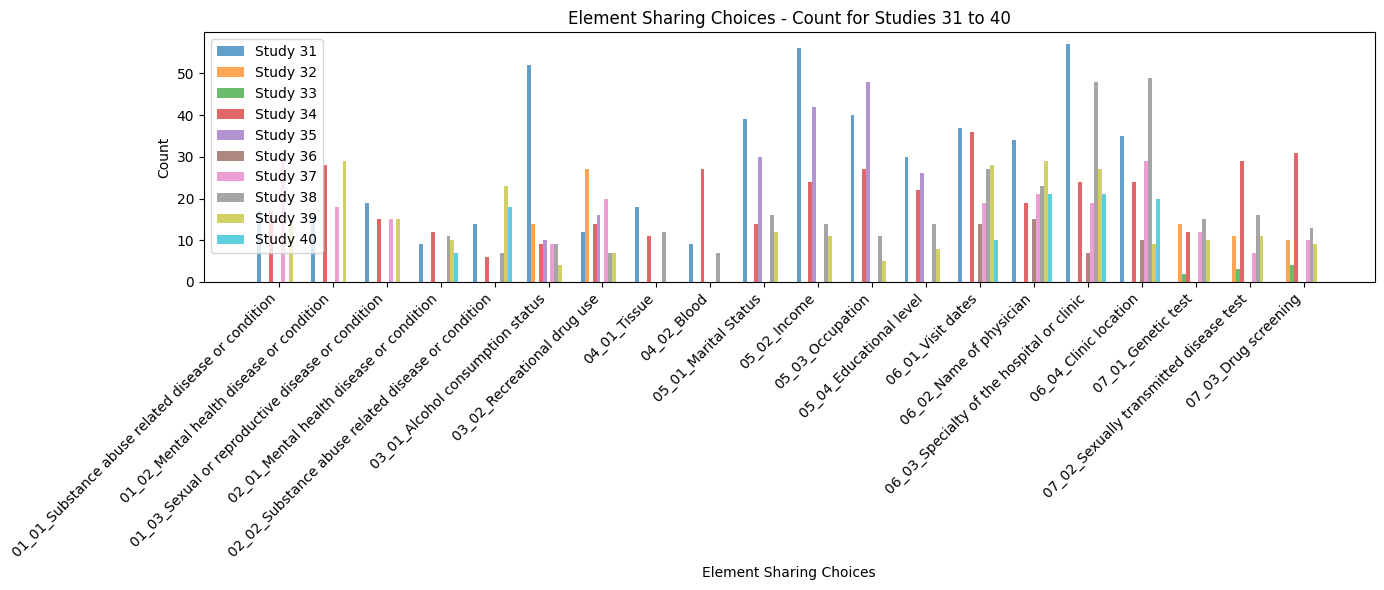

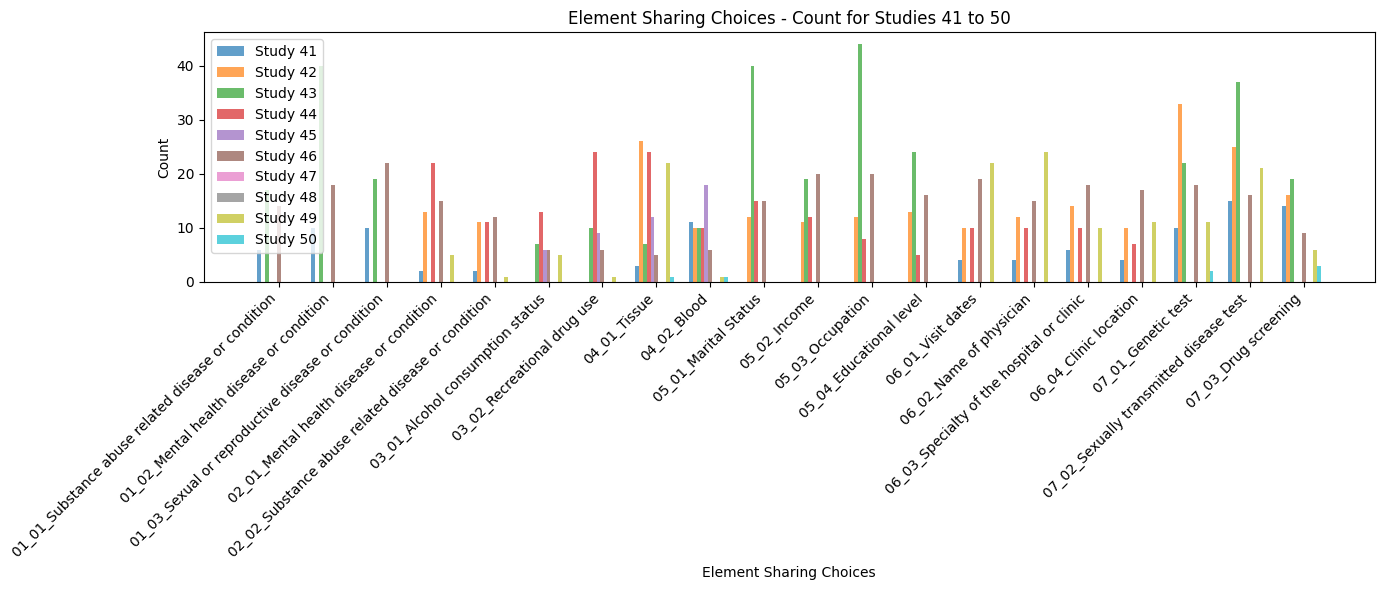

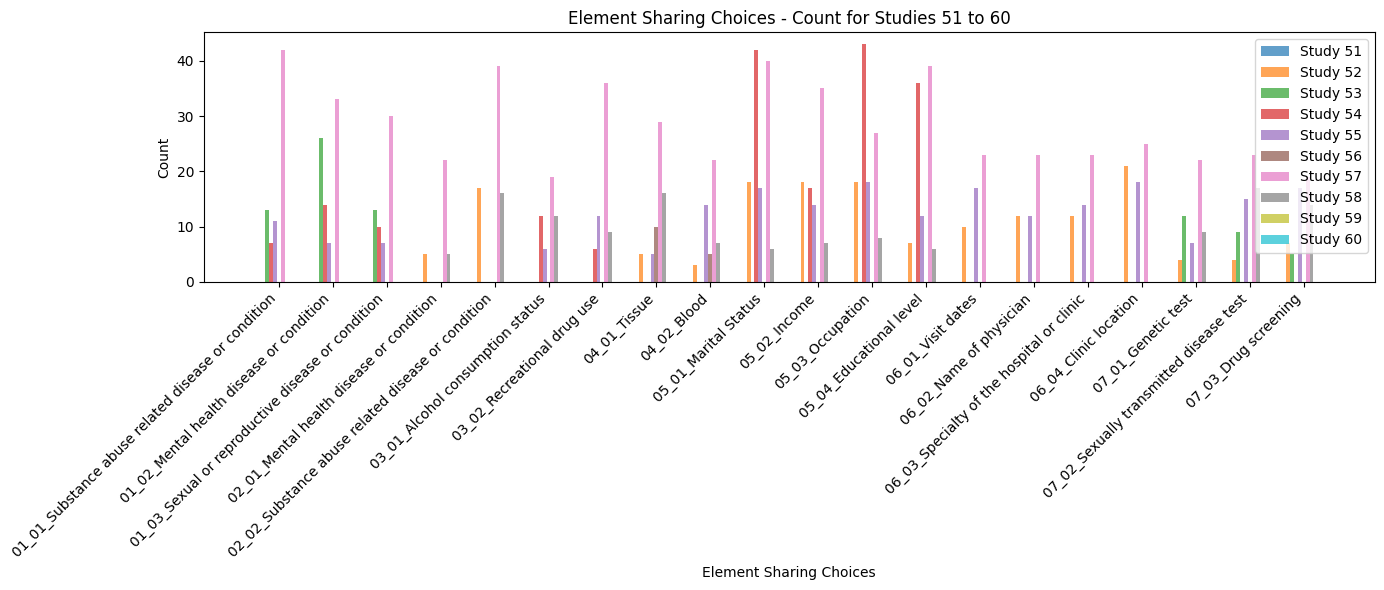

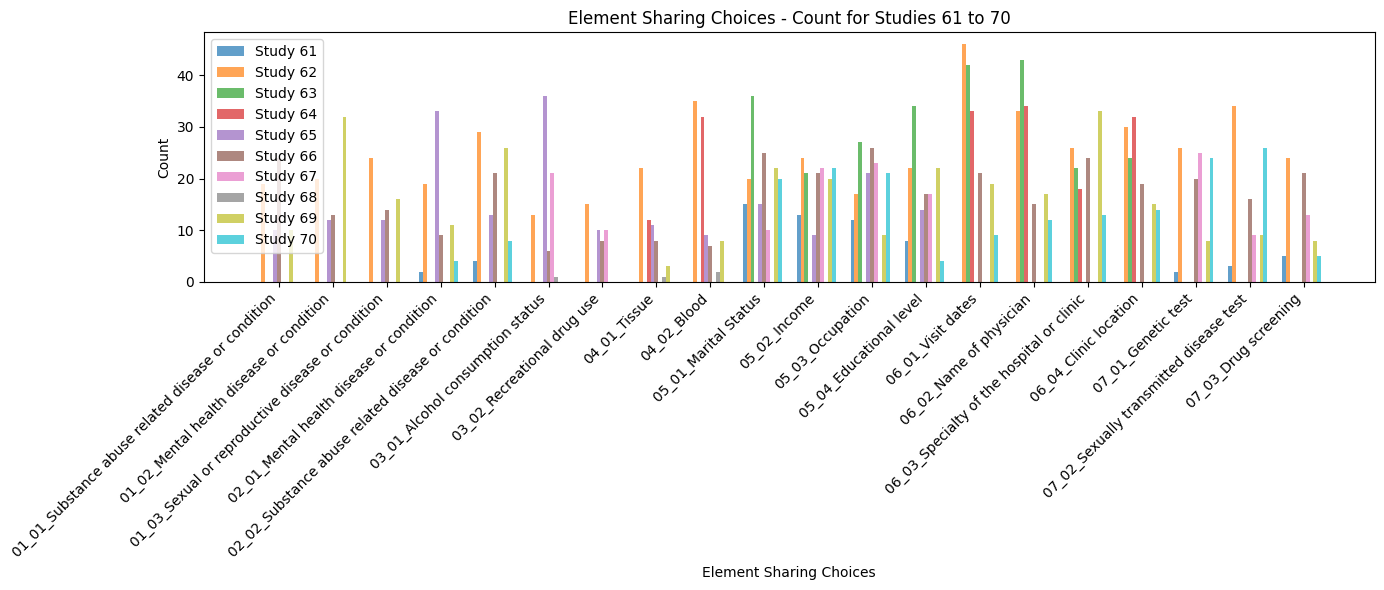

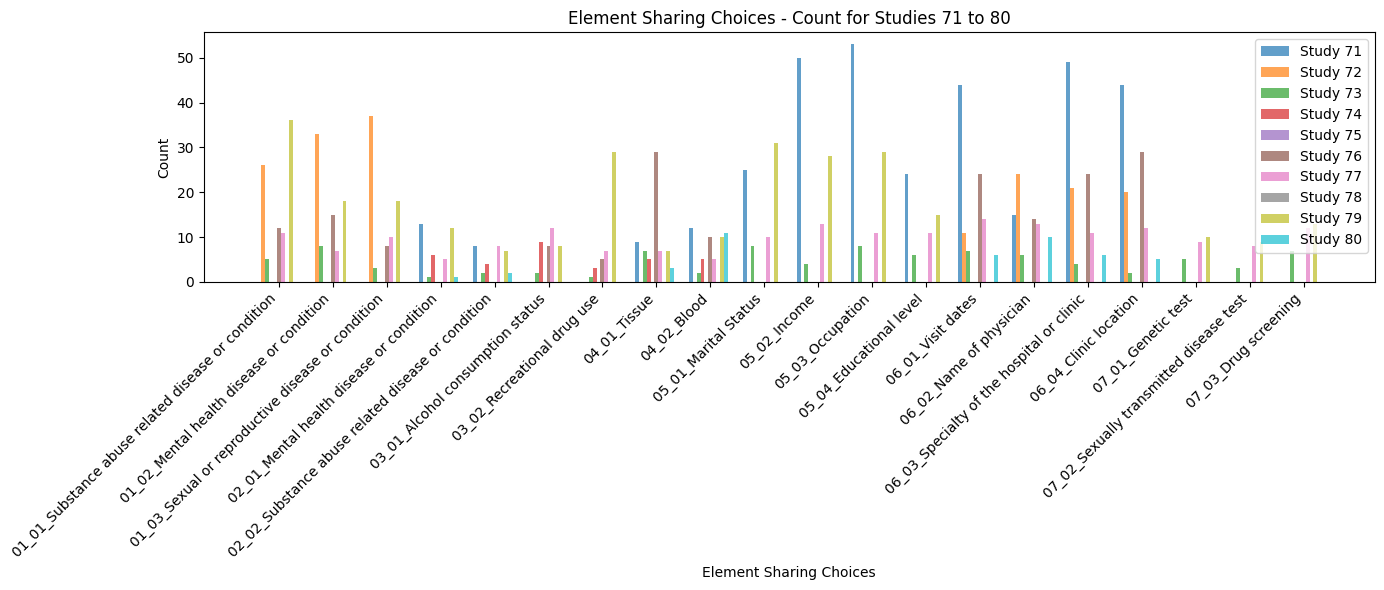

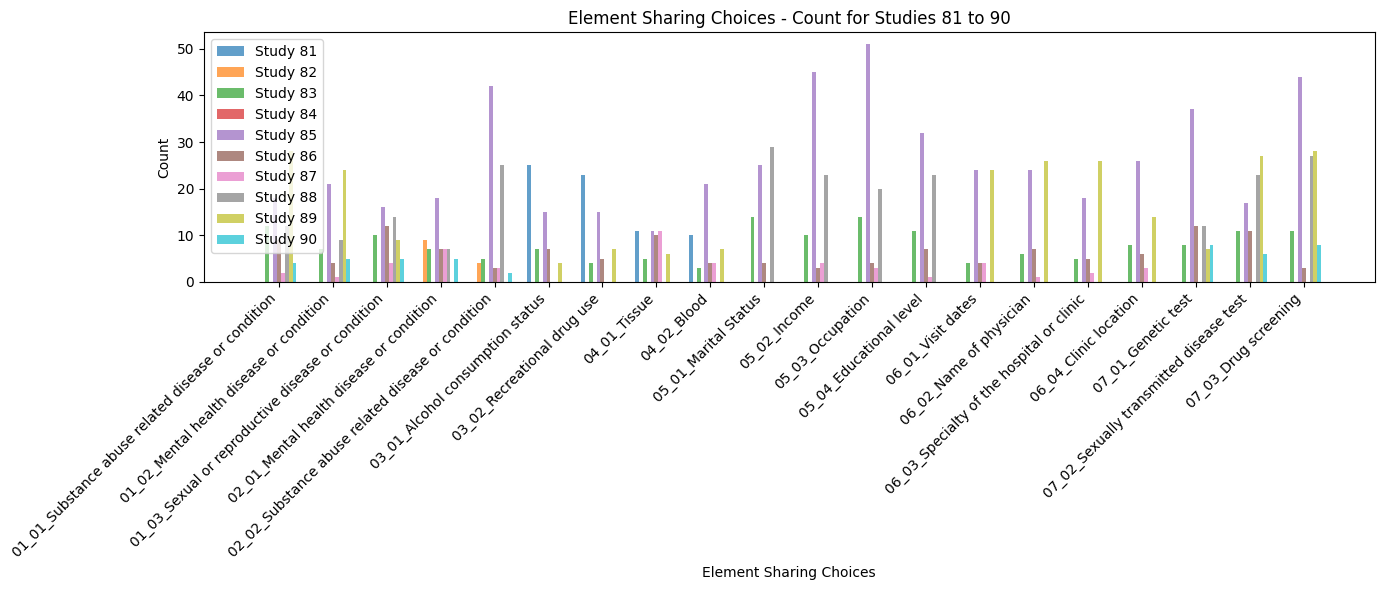

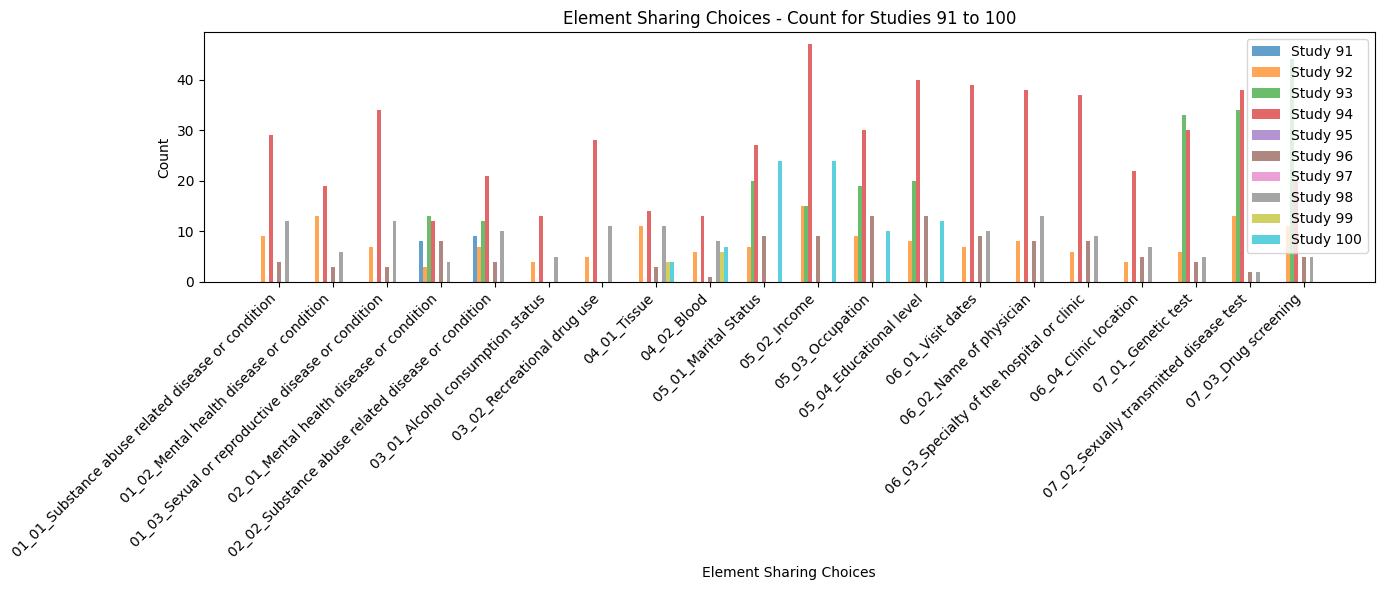

In [25]:
# reusuable for creating both category choices and element choices
def create_bar_graphs(data, choices, title):
    num_studies = len(df['studyID'].unique())
    num_graphs = (num_studies // 10) 

    for graph_num in range(num_graphs):
        start_index = graph_num * 10
        end_index = min((graph_num + 1) * 10, num_studies)
        plt.figure(figsize=(14, 6))
        x_values = np.arange(len(choices))
        width = 0.8 / (end_index - start_index + 1)

        for i, study in enumerate(df['studyID'].unique()[start_index:end_index]):
            study_values = [data[study][choice] for choice in choices]
            plt.bar(
                x_values + i * width,
                study_values,
                width=width,
                label=f'Study {study}',
                alpha=0.7,
                color=f'C{i}'
            )

        plt.xlabel(title)
        plt.ylabel('Count')
        plt.xticks(x_values + (end_index - start_index) * width / 2, choices, rotation=45, ha='right')
        plt.title(f'{title} - Count for Studies {start_index + 1} to {end_index}')
        plt.legend()
        plt.tight_layout()
        plt.show()

# bar graphs for categorySharingChoices
create_bar_graphs(category_choices_count, sorted_category_choices, 'Category Sharing Choices')

# bar graphs for elementSharingChoices
create_bar_graphs(element_choices_count, sorted_element_choices, 'Element Sharing Choices')

## unsorted line chart: x-axis → study ID, y-asis → unique category and unique element

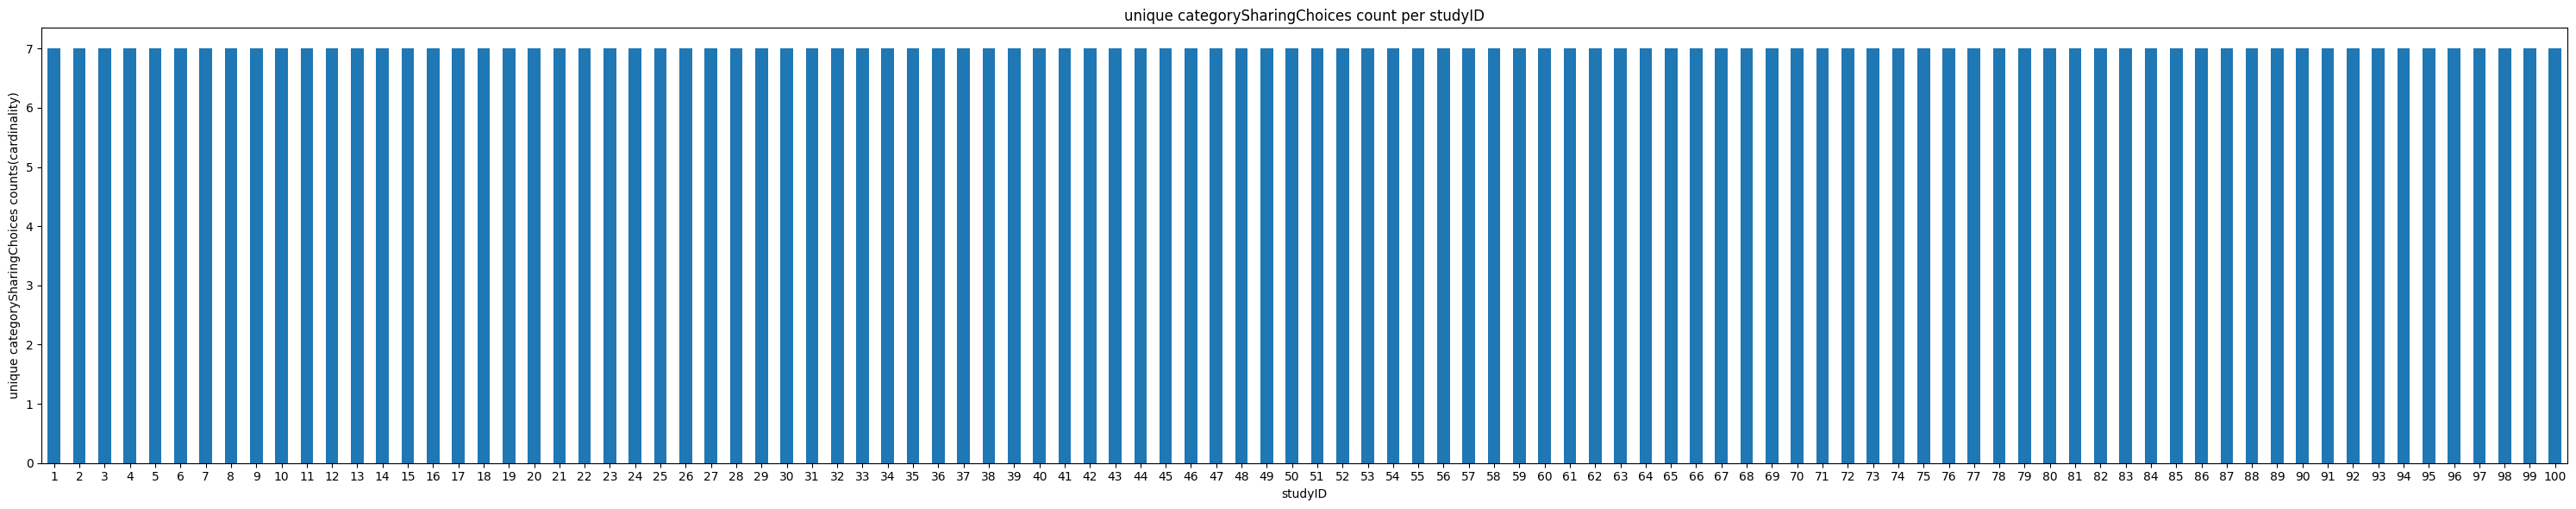

In [27]:
study_unique_category_counts = {}

for study_id, study_data in df.groupby('studyID'):
    unique_categories = []

    # get rows of the same studyID
    for index, row in study_data.iterrows():
        categories = row['categorySharingChoices']
        unique_categories.extend(categories)

    # get unique category counts for this studyID
    unique_category_count = len(set(unique_categories))

    study_unique_category_counts[study_id] = unique_category_count

unique_category_df = pd.DataFrame.from_dict(study_unique_category_counts, orient='index')
unique_category_df.rename(columns={'nan':'No Selection'}, inplace=True)
# plot graph with studyIDs on the x-axis and unique category counts on the y-axis
plt.figure(figsize=(30, 6))
unique_category_df.plot(kind='bar', ax=plt.gca(), legend=None)
plt.xlabel('studyID')
plt.ylabel('unique categorySharingChoices counts(cardinality)')
plt.title('unique categorySharingChoices count per studyID')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

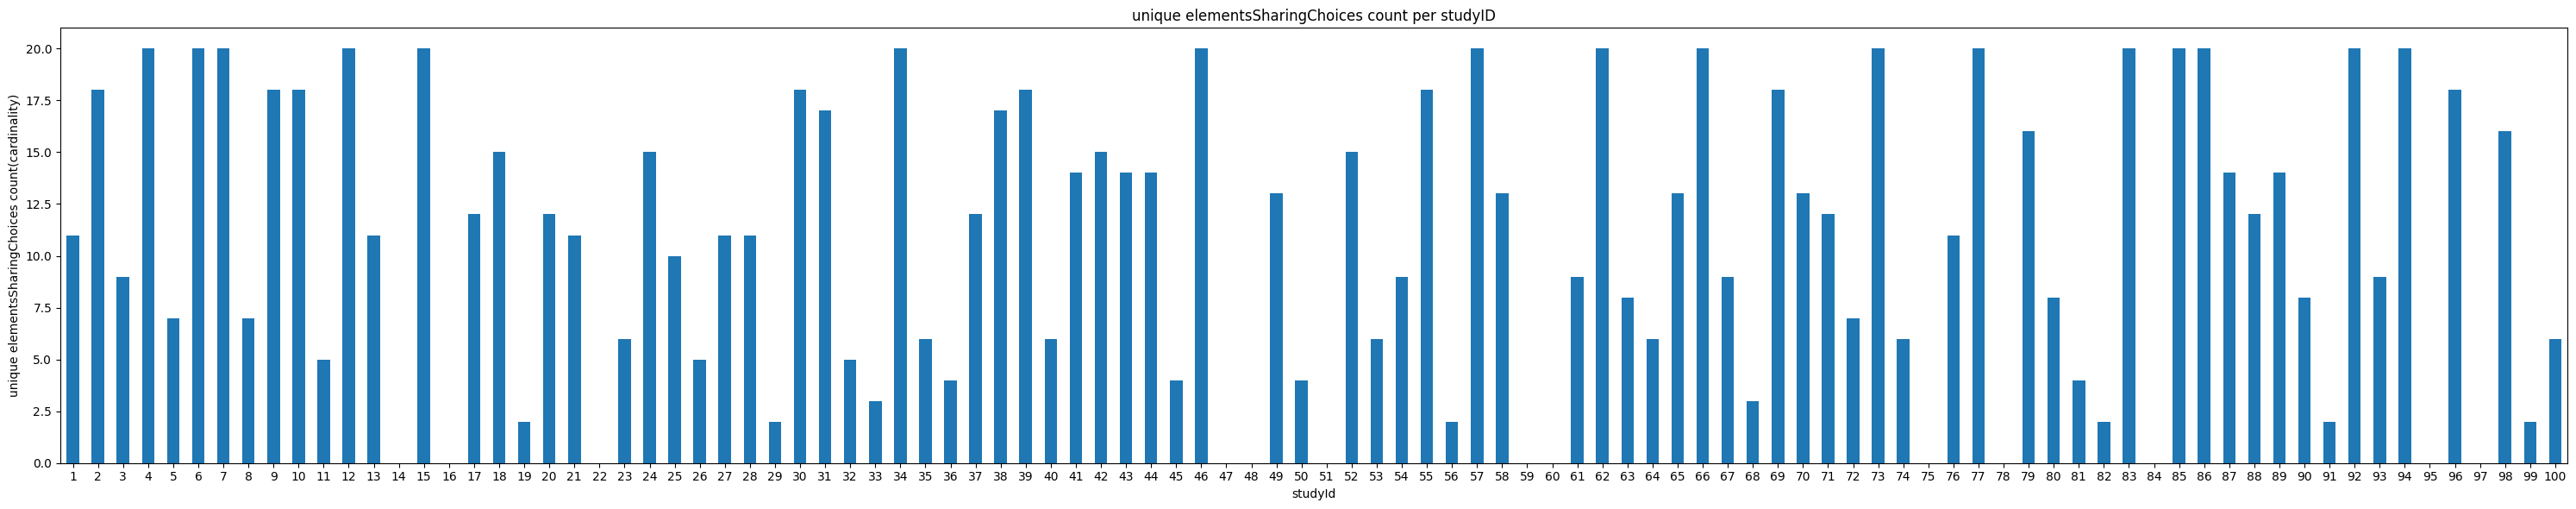

In [28]:
study_unique_element_counts = {}

for study_id, study_data in df.groupby('studyID'):
    unique_elements = []

    # get unique elementSharingChoices for the current study
    for index, row in study_data.iterrows():
        elements = row['elementSharingChoices']
        unique_elements.extend(elements)

    # get elementSharingChoices count for this study
    unique_element_count = len(set(unique_elements))
    study_unique_element_counts[study_id] = unique_element_count

unique_element_df = pd.DataFrame.from_dict(study_unique_element_counts, orient='index')
unique_element_df.rename(columns={'nan':'No Selection'}, inplace=True)
# plot graph with studyIDs on the x-axis and unique elementSharingChoices counts on the y-axis
plt.figure(figsize=(30, 6))
unique_element_df.plot(kind='bar', ax=plt.gca(), legend=None)
plt.xlabel('studyId')
plt.ylabel('unique elementsSharingChoices count(cardinality)')
plt.title('unique elementsSharingChoices count per studyID')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

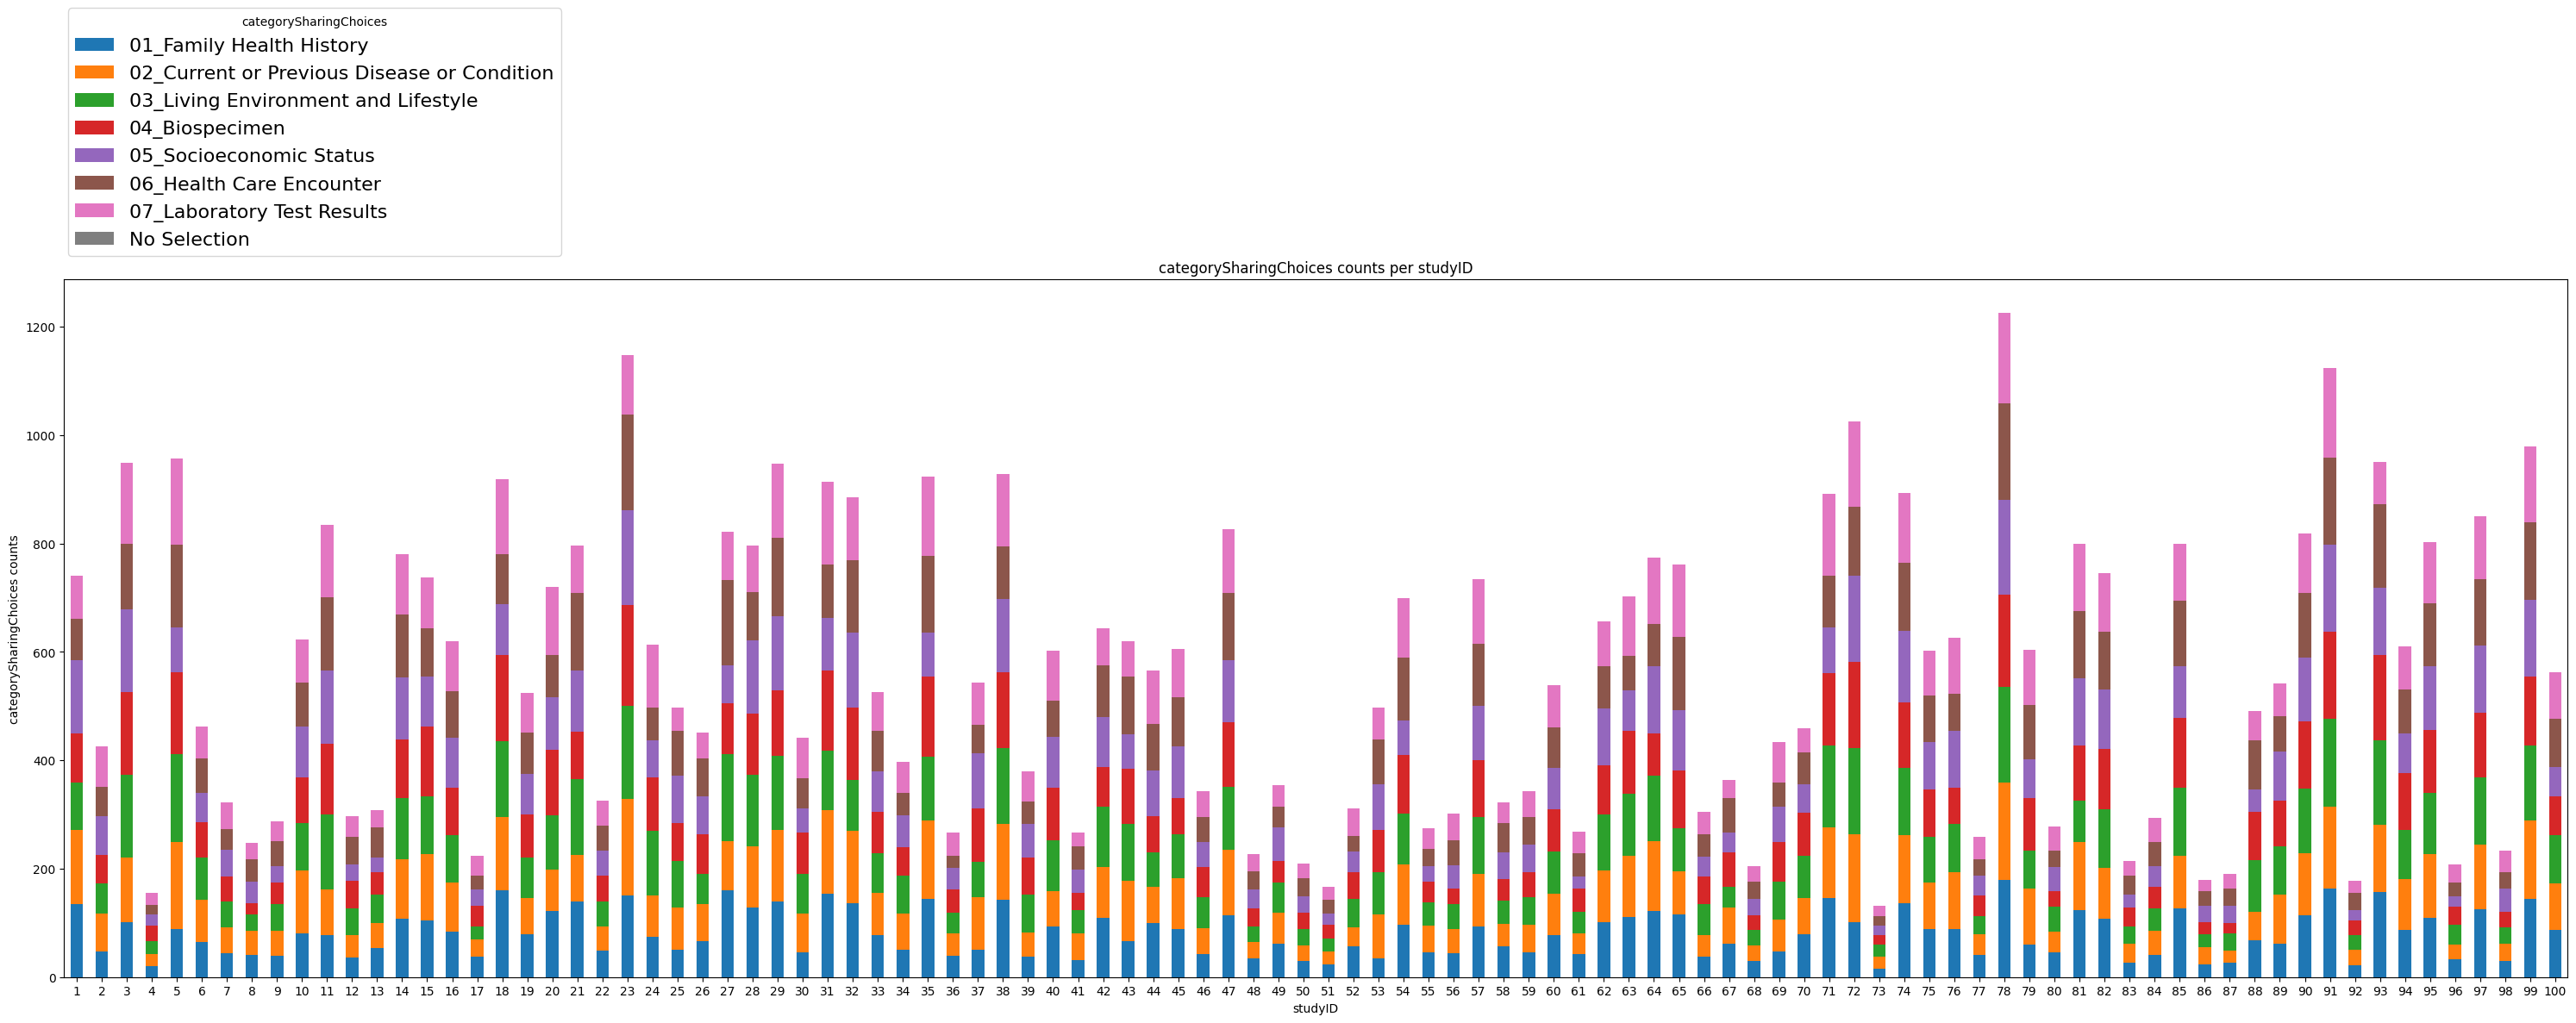

In [29]:
unique_study_ids = df['studyID'].unique()
study_category_counts = {}
for study_id in unique_study_ids:
    study_data = df[df['studyID'] == study_id]
    unique_categories = study_data['categorySharingChoices'].explode().unique().astype(str)  # Convert to strings
    category_counts = study_data['categorySharingChoices'].explode().value_counts()
    # reindex the categorySharingChoices and counts by category name
    category_counts = category_counts.reindex(unique_categories)
    study_category_counts[study_id] = category_counts

category_df = pd.DataFrame(study_category_counts).T
category_df.rename(columns={'nan':'No Selection'}, inplace=True)
# plot the bar graph with study IDs on the x-axis and categorySharingChoices counts on the y-axis
plt.figure(figsize=(30, 12))
category_df.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('studyID')
plt.ylabel('categorySharingChoices counts')
plt.title('categorySharingChoices counts per studyID')
plt.xticks(rotation=0)
plt.legend(title='categorySharingChoices', bbox_to_anchor=(0.1, 1.02), loc='lower center', fontsize=16)
plt.tight_layout()
plt.show()

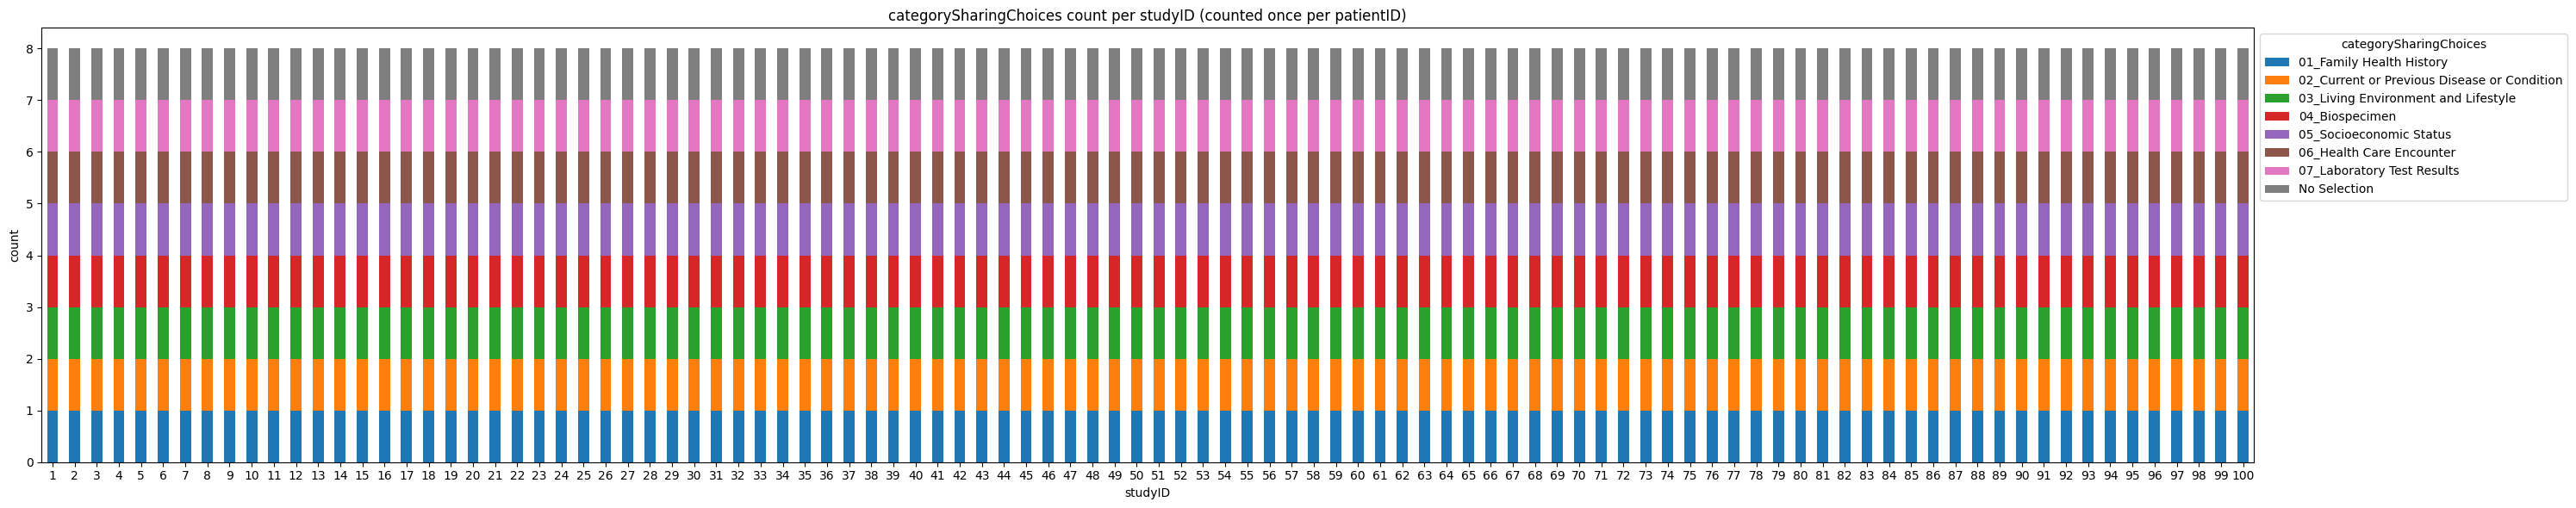

In [30]:
study_category_counts = {}

for study_id in unique_study_ids:
    study_data = df[df['studyID'] == study_id]
    # aux df with unique patient IDs and their categories
    unique_patient_categories = study_data.groupby('patientID')['categorySharingChoices'].first().explode().unique().astype(str)

    category_counts = {}
    # store categorySharingChoices counts for each patient
    for patient_category in unique_patient_categories:
        categories = patient_category.split(',')
        for category in categories:
            category_counts[category] = category_counts.get(category, 0) + 1

    study_category_counts[study_id] = pd.Series(category_counts)

category_df = pd.DataFrame(study_category_counts).T
category_df.rename(columns={'nan':'No Selection'}, inplace=True)

# plot the bar graph with studyIDs on the x-axis and categorySharingChoices counts on the y-axis
plt.figure(figsize=(30, 6))
category_df.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('studyID')
plt.ylabel('count')
plt.title('categorySharingChoices count per studyID (counted once per patientID)')
plt.xticks(rotation=0)
plt.legend(title='categorySharingChoices', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

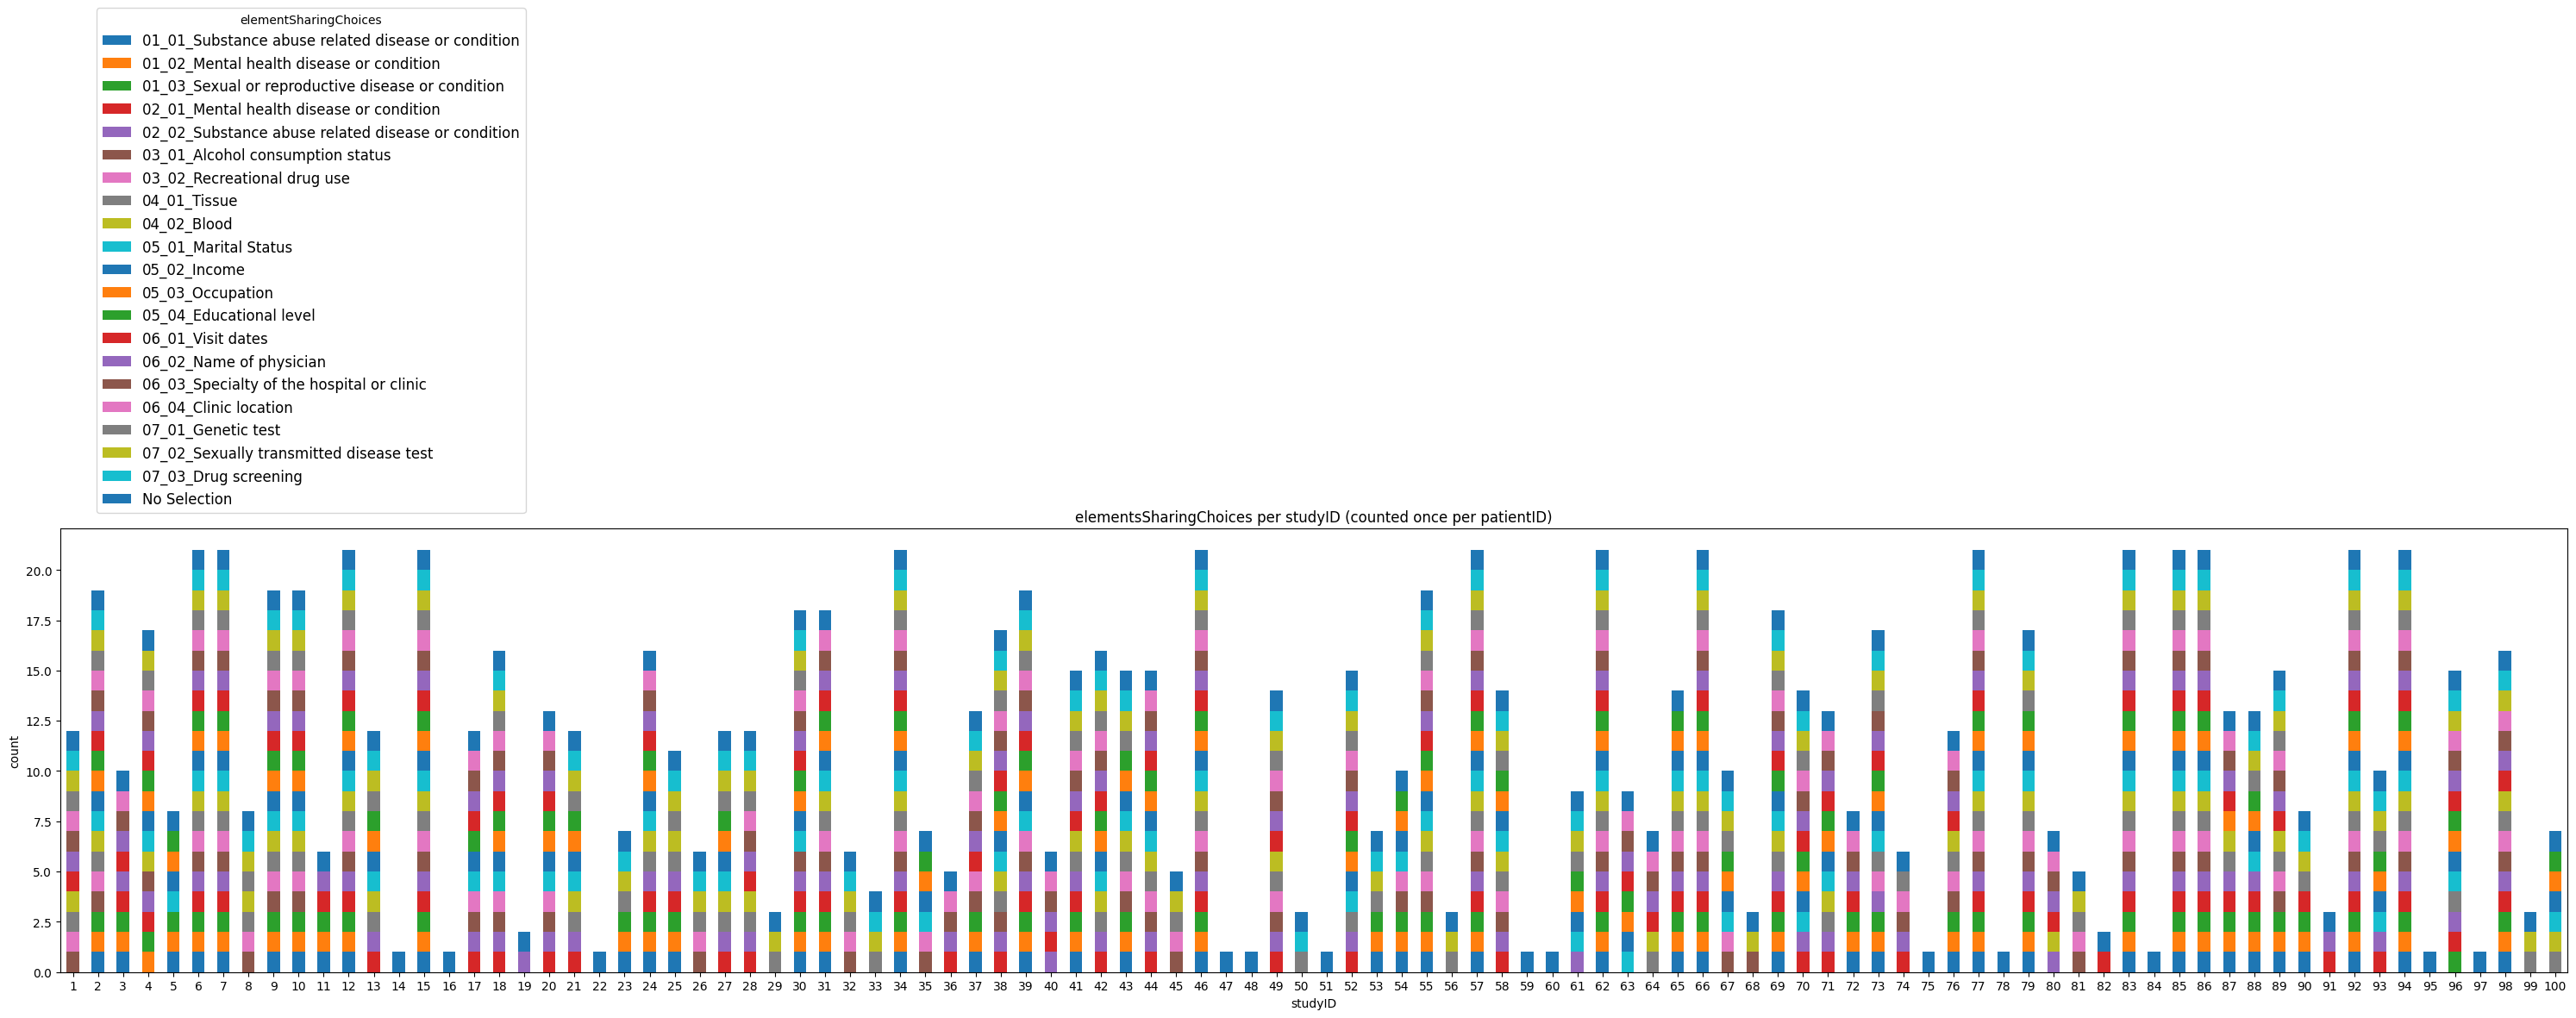

In [50]:
unique_study_ids = df['studyID'].unique()

study_element_counts = {}
for study_id in unique_study_ids:
    study_data = df[df['studyID'] == study_id]

    # aux dataframe with unique patientIDs and their elements
    unique_patient_elements = study_data.groupby('patientID')['elementSharingChoices'].first().explode().unique().astype(str)

    # store element sharing counts for each patient
    element_counts = {}
    for patient_element in unique_patient_elements:
        elements = patient_element.split(',')
        for element in elements:
            element_counts[element] = element_counts.get(element, 0) + 1

    study_element_counts[study_id] = pd.Series(element_counts)

element_df = pd.DataFrame(study_element_counts).T
element_df.rename(columns={'nan':'No Selection'}, inplace=True)
# plot the bar graph with studyIDs on the x-axis and elementSharingChoices counts on the y-axis
plt.figure(figsize=(30, 12))
element_df.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('studyID')
plt.ylabel('count')
plt.title('elementsSharingChoices per studyID (counted once per patientID)')
plt.xticks(rotation=0)
plt.legend(title='elementSharingChoices', bbox_to_anchor=(0.1, 1.02), loc='lower center', fontsize='large')
plt.tight_layout()
plt.show()

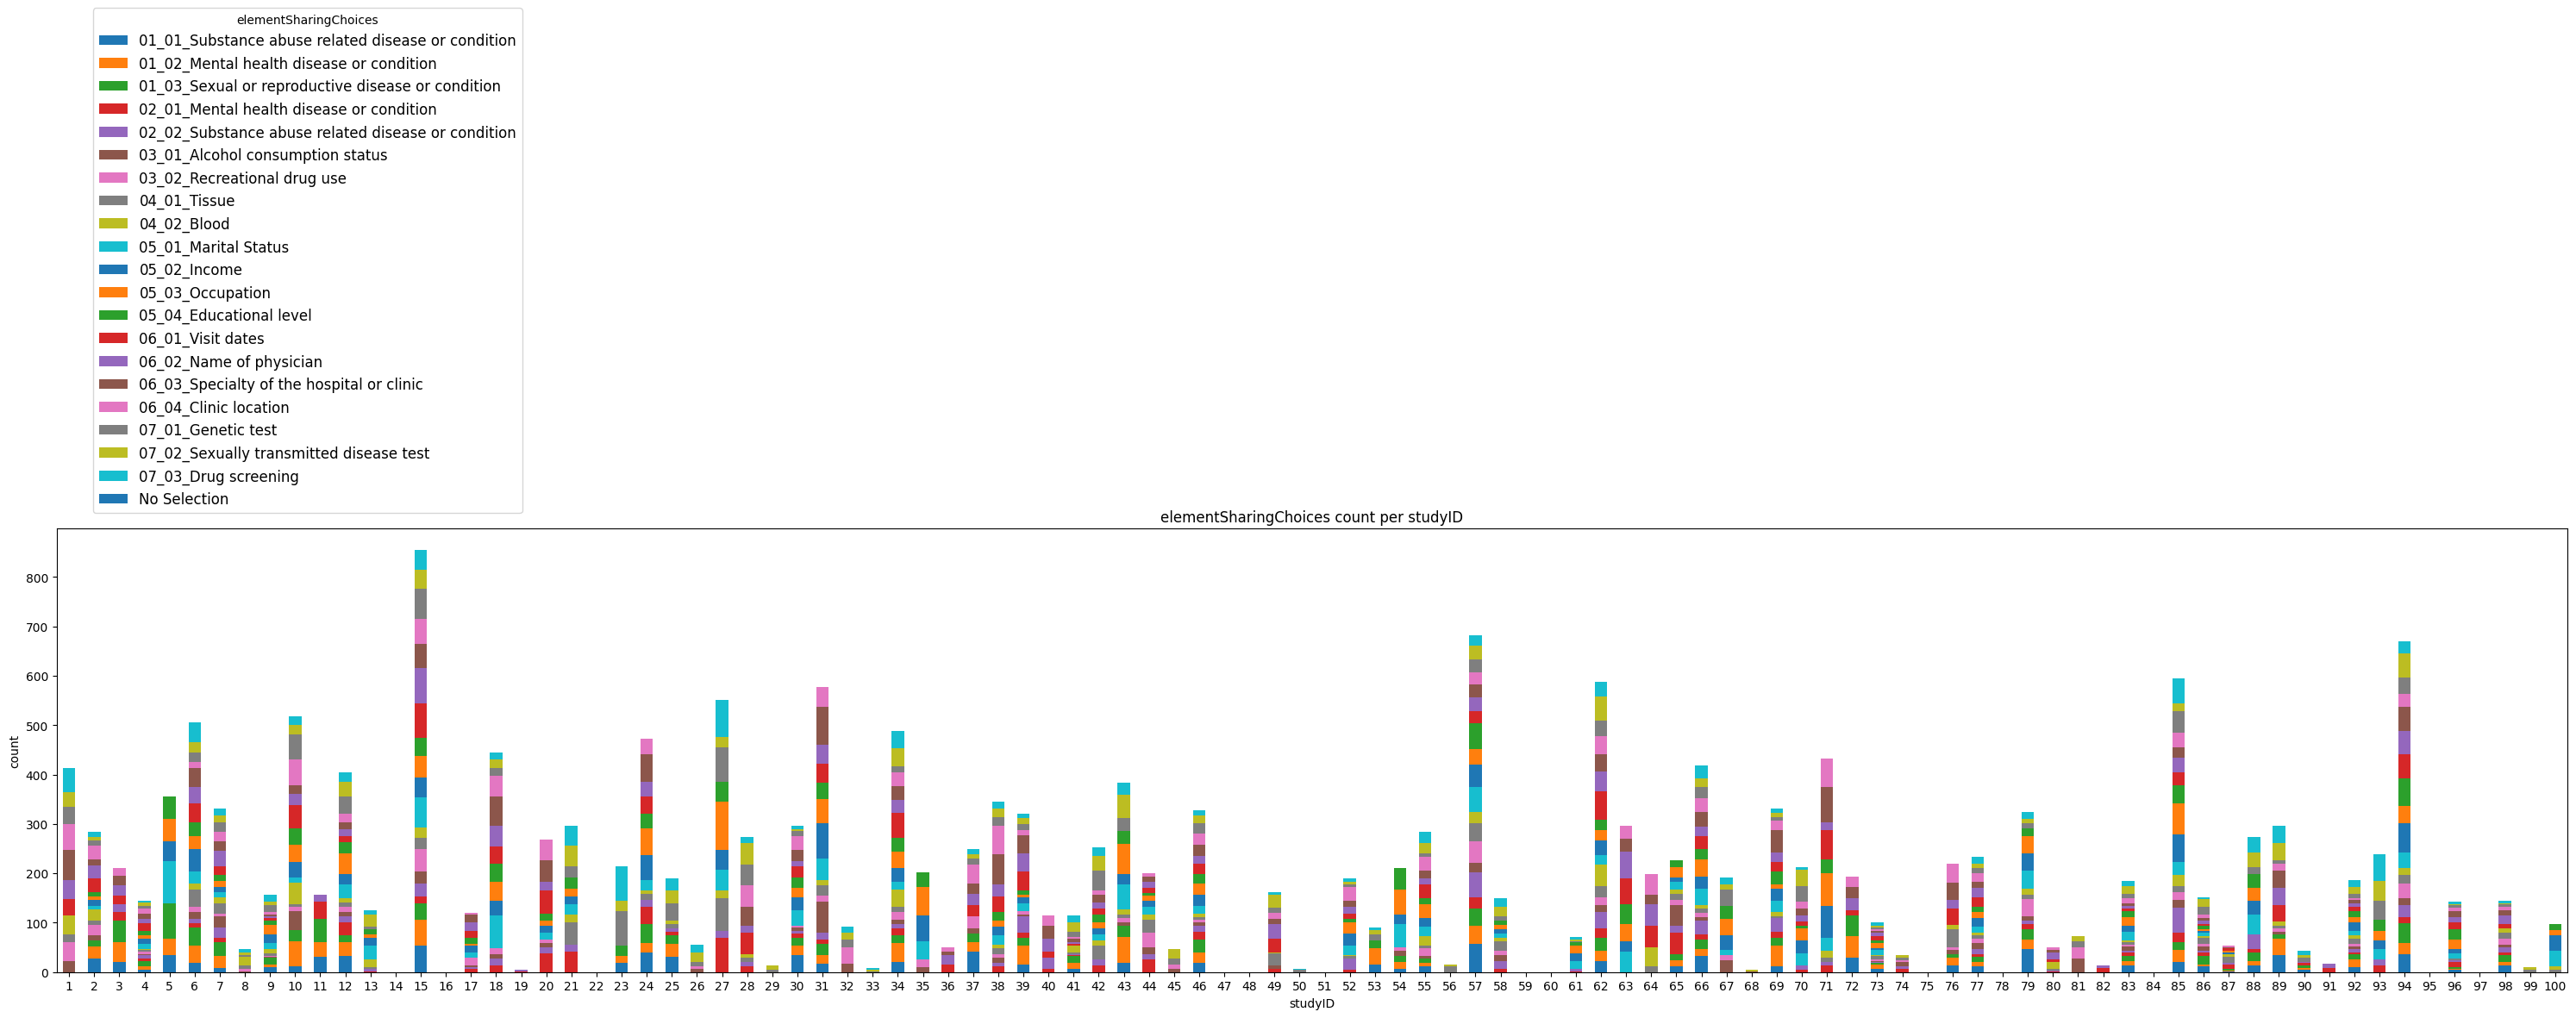

In [49]:
unique_study_ids = df['studyID'].unique()

study_element_counts = {}

for study_id in unique_study_ids:
    study_data = df[df['studyID'] == study_id]
    unique_elements = study_data['elementSharingChoices'].explode().unique().astype(str)
    element_counts = study_data['elementSharingChoices'].explode().value_counts()

    # reindex elementSharingCounts counts by its names
    element_counts = element_counts.reindex(unique_elements)
    study_element_counts[study_id] = element_counts

element_df = pd.DataFrame(study_element_counts).T
element_df.rename(columns={'nan':'No Selection'}, inplace=True)
# bar graph with studyIDs on the x-axis and elementSharingChoices counts on the y-axis
plt.figure(figsize=(30, 12))
element_df.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('studyID')
plt.ylabel('count')
plt.title('elementSharingChoices count per studyID')
plt.xticks(rotation=0)
plt.legend(title='elementSharingChoices', bbox_to_anchor=(0.1, 1.02), loc='lower center', fontsize='large')
plt.tight_layout()
plt.show()

## plotting average min and max number of entries per patient per study

In [33]:
patient_study_counts = df.groupby(['patientID', 'studyID']).size().reset_index(name='count')
average_patient_counts = patient_study_counts.groupby('patientID')['count'].mean().reset_index(name='average_count')

In [34]:
patient_counts = []
patient_labels = []
for _,row in average_patient_counts.iterrows():
    patient_counts.append(row[1])
    patient_labels.append(str(int(row[0])))

In [35]:
chunk_size = 80

C:\Users\skim0\AppData\Local\Temp\ipykernel_39168\191927147.py:10: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(-0.5, len(patient_labels[i:i + chunk_size]),0.5)


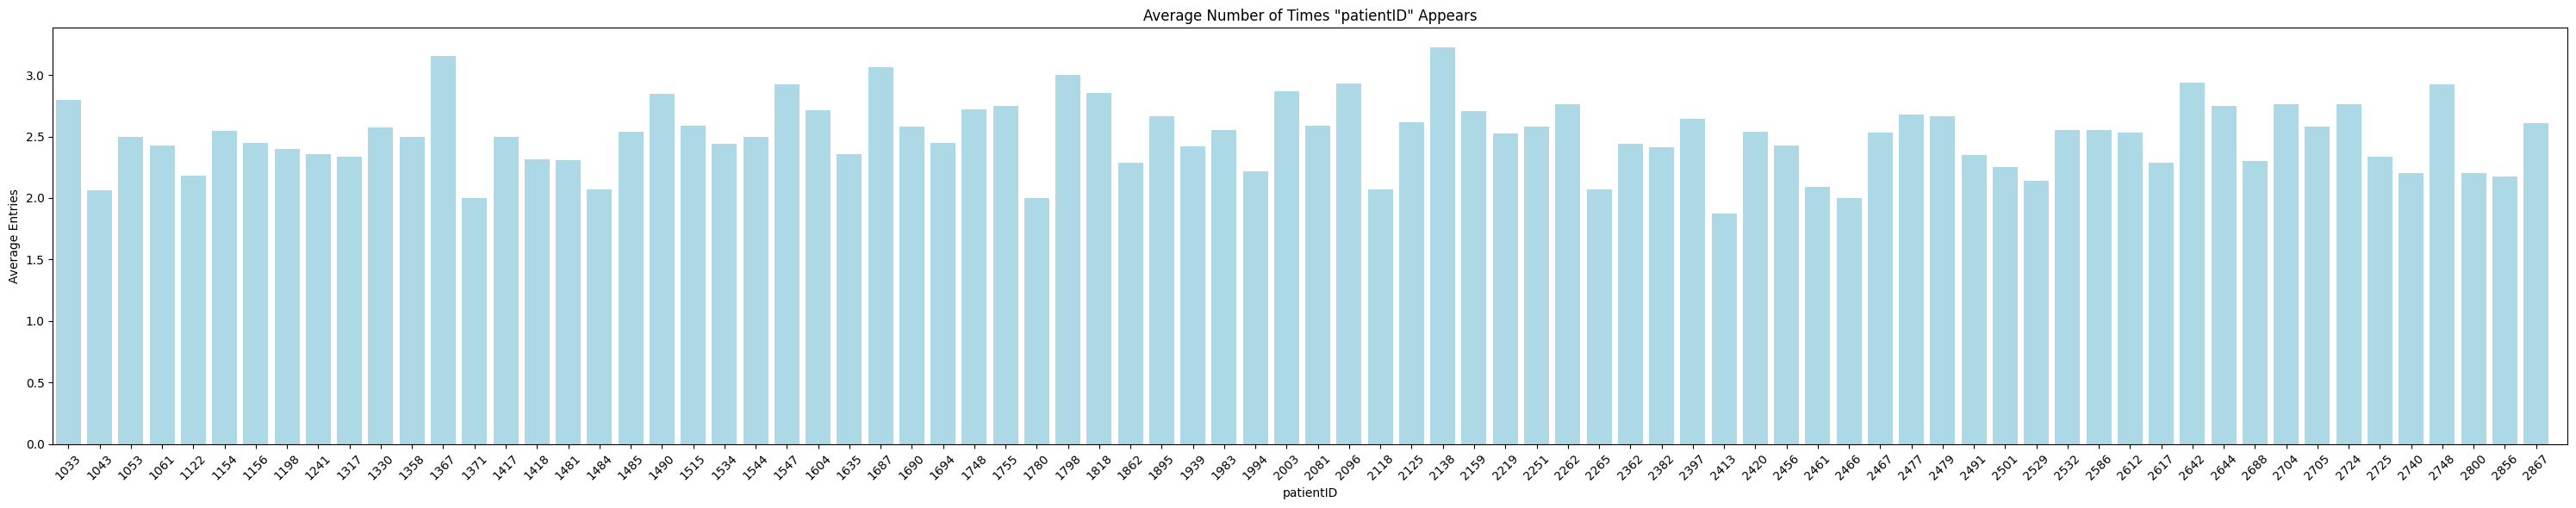

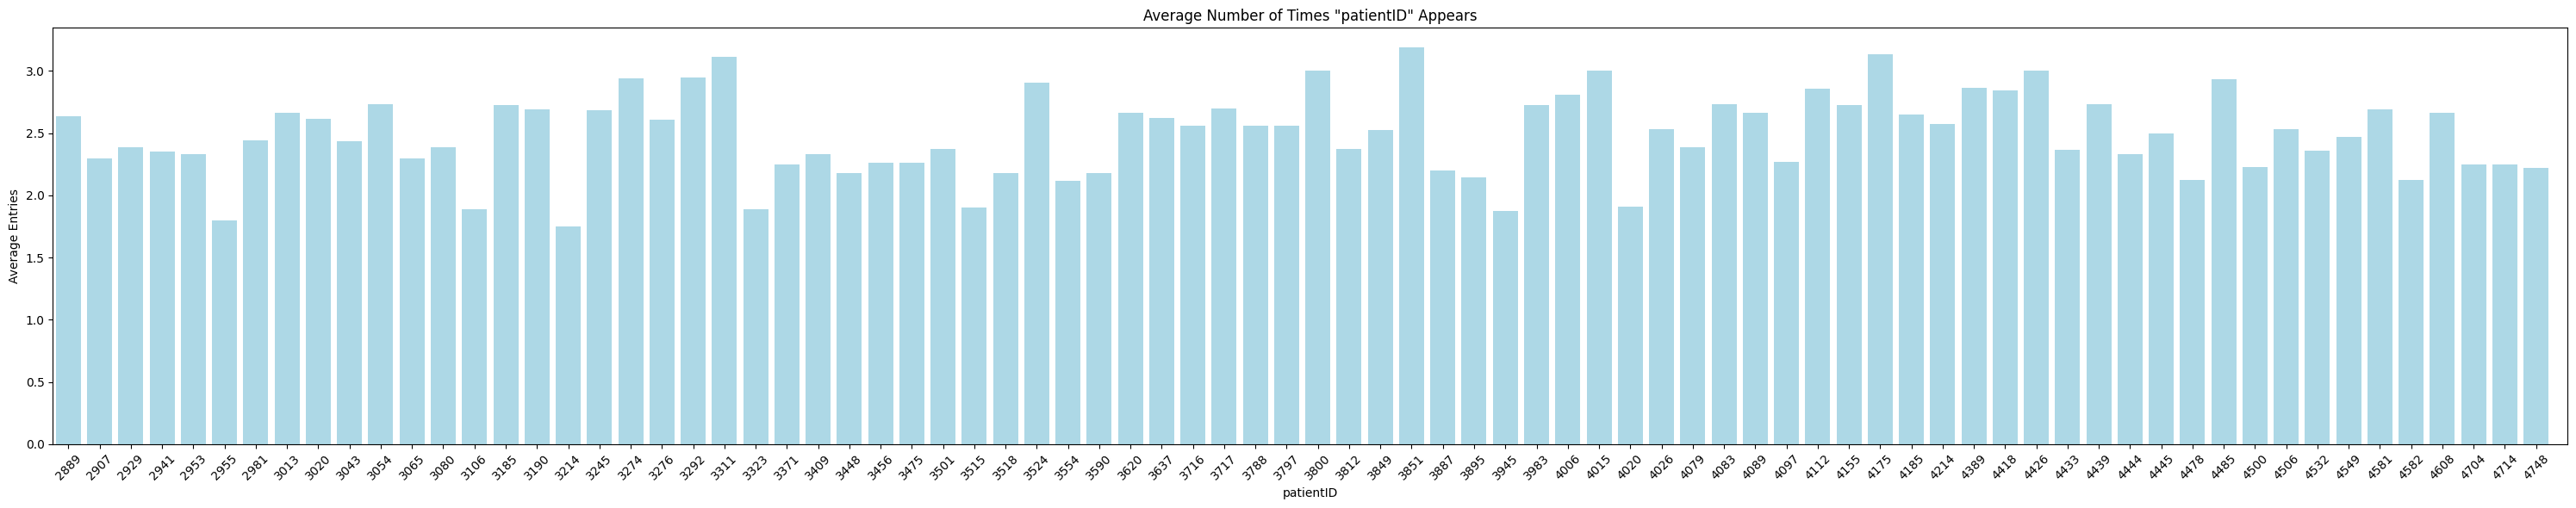

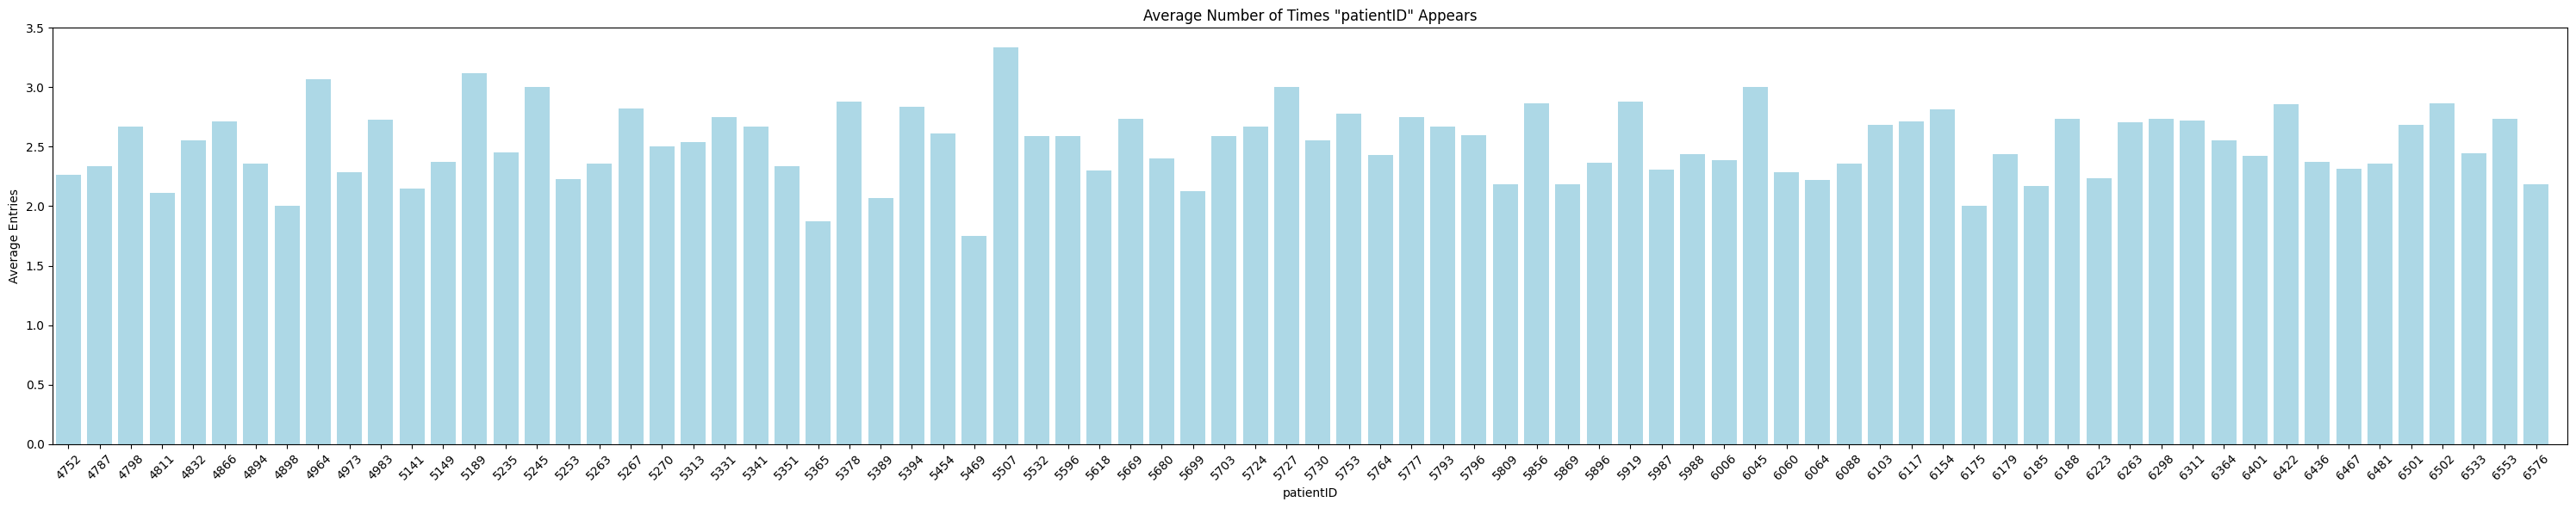

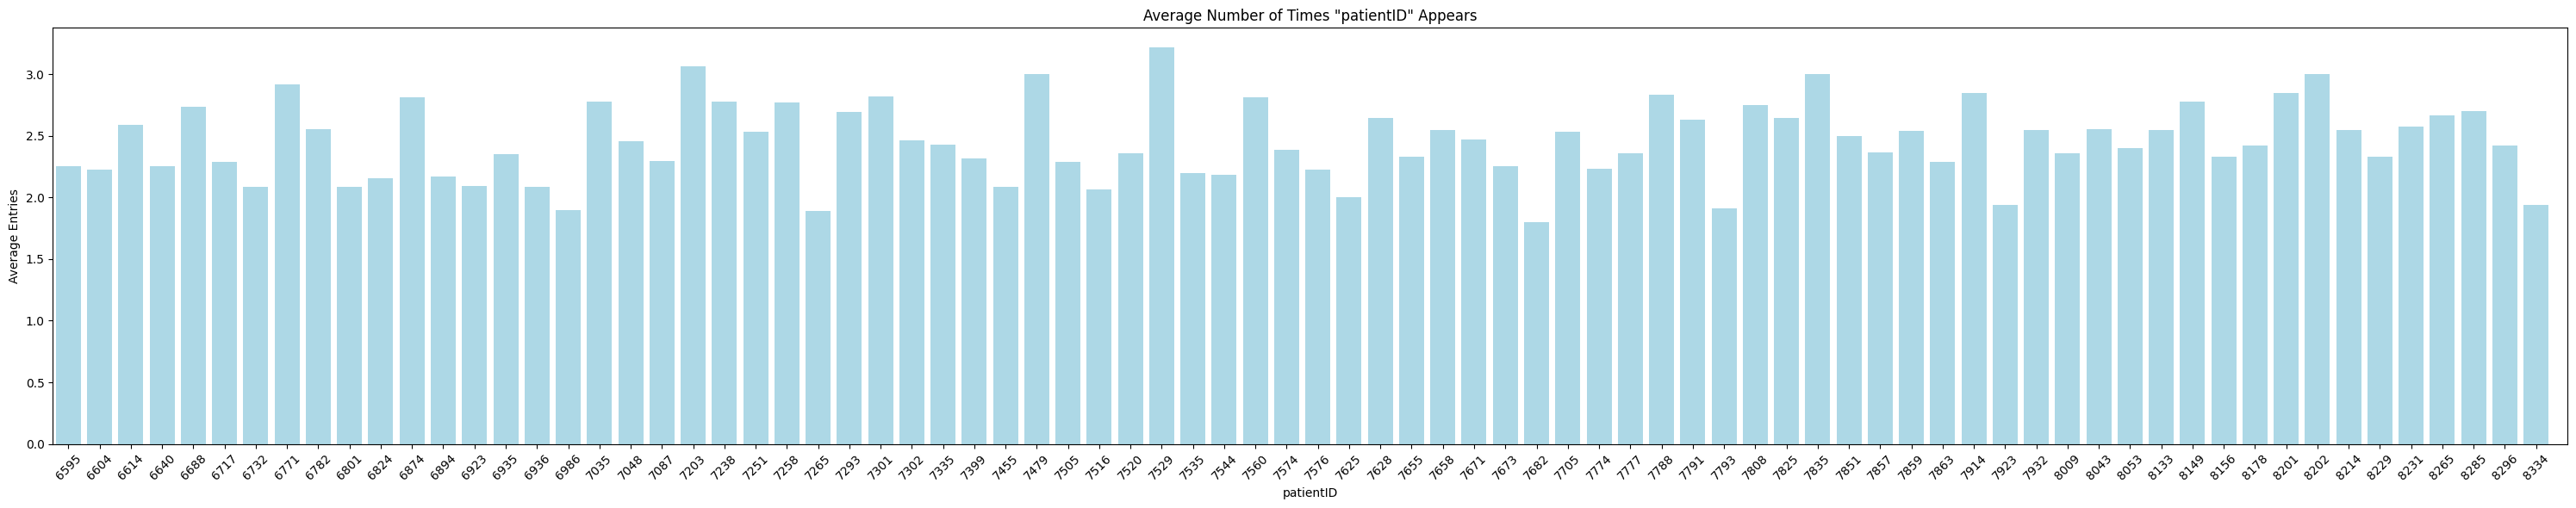

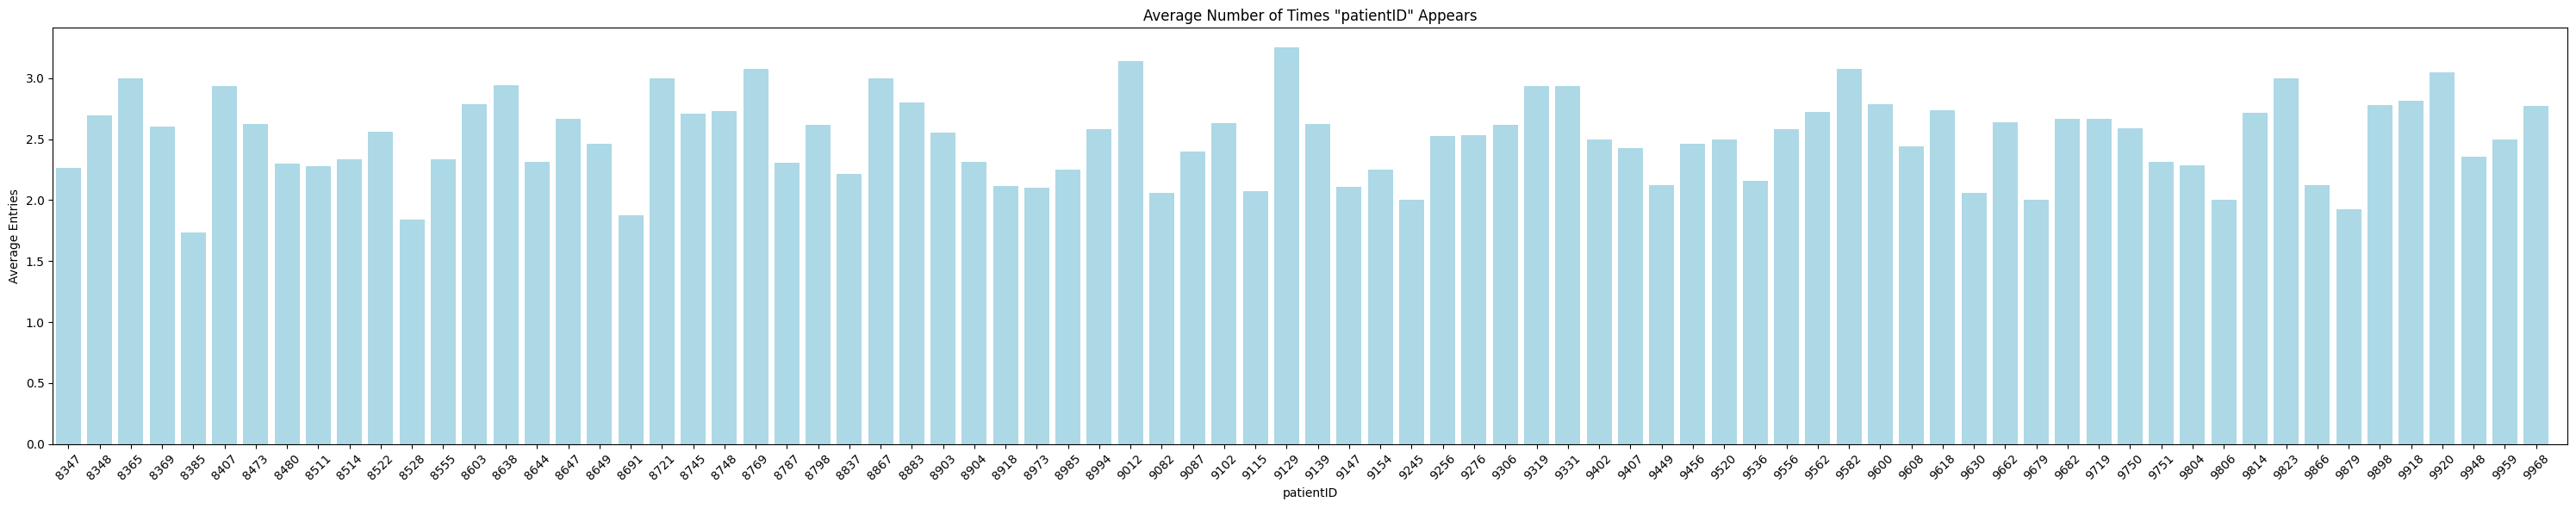

In [36]:
ranges = list(range(0, len(patient_counts), chunk_size))
for index,i in enumerate(ranges):
    plt.figure(figsize=(30,6))
    plt.bar(patient_labels[i:i + chunk_size], patient_counts[i:i + chunk_size], color='lightblue')
    plt.xlabel('patientID')
    plt.ylabel('Average Entries')
    plt.title(f'Average Number of Times "patientID" Appears')
    plt.xticks(patient_labels[i:i + chunk_size], rotation=45)
    
    plt.xlim(-0.5, len(patient_labels[i:i + chunk_size]),0.5)
    plt.tight_layout()
    #plt.savefig(f'avgNumberOfTimesPatientIDAppears_Graph{index+3}.png')
    plt.show()

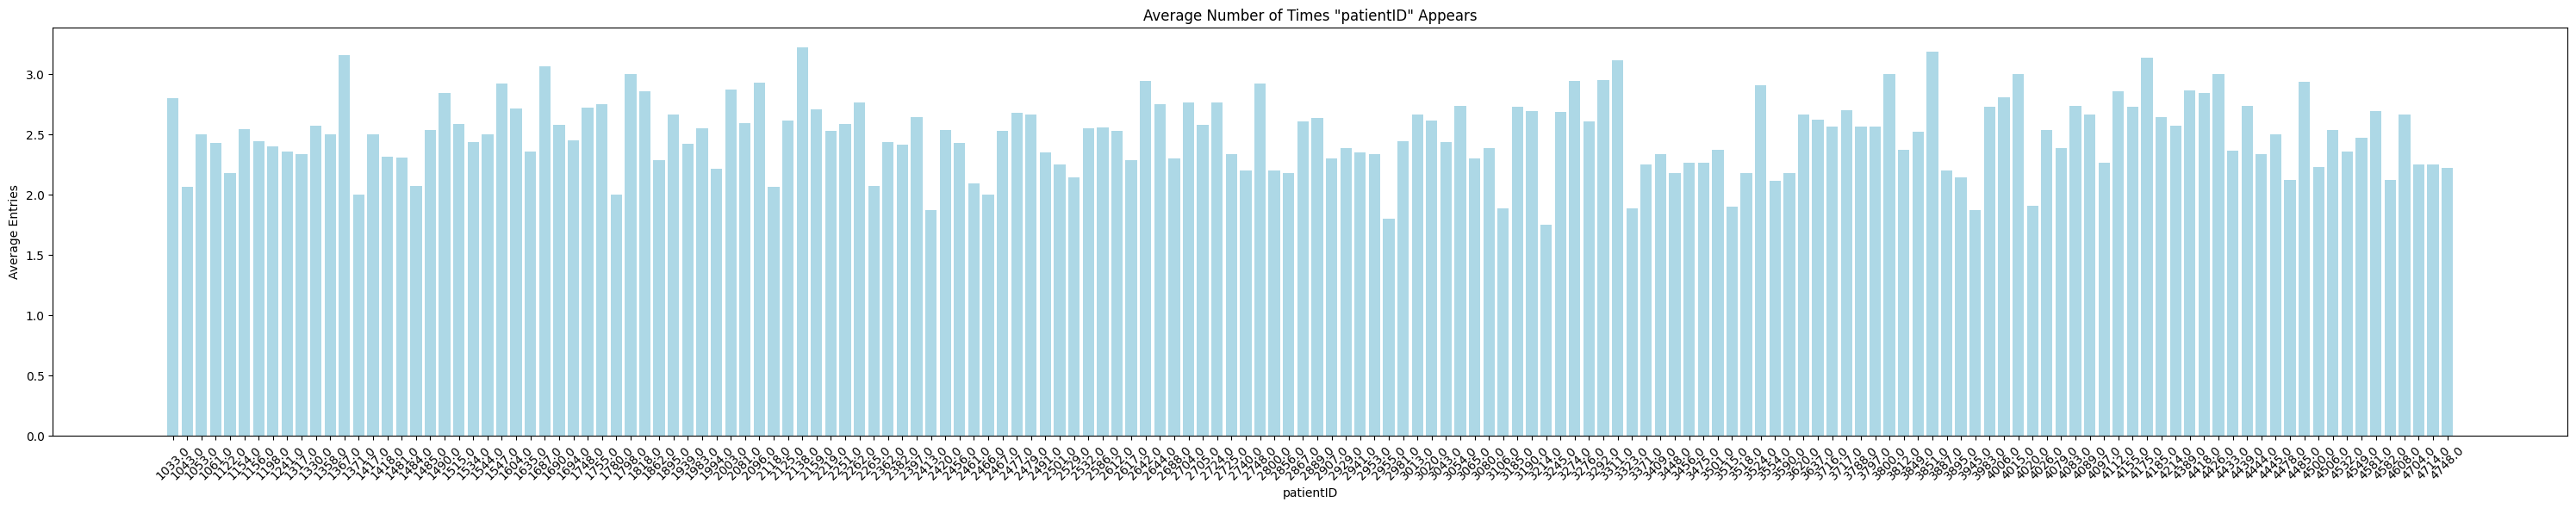

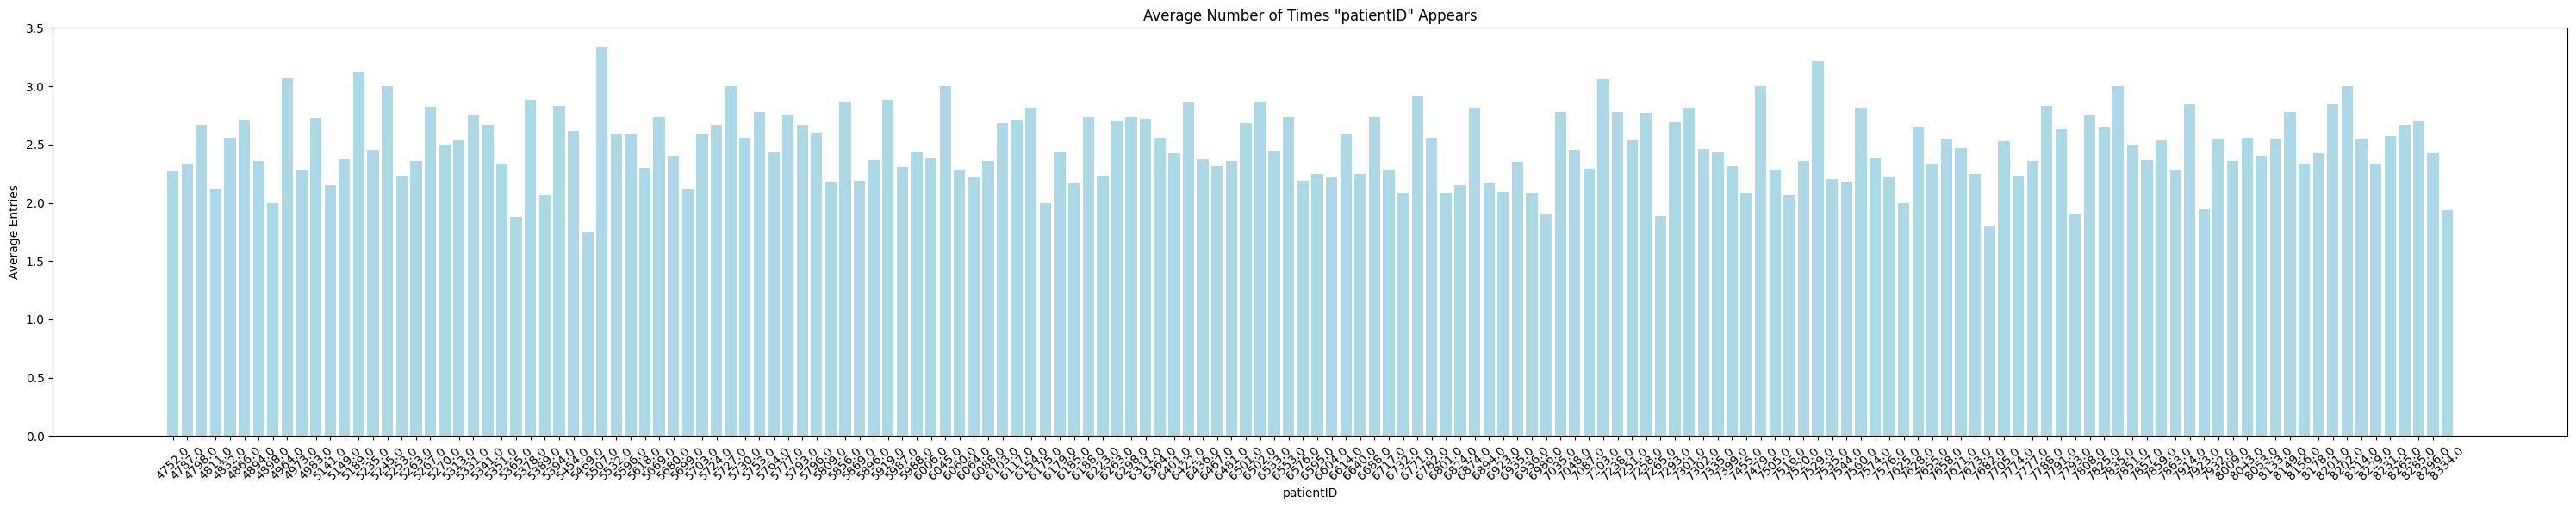

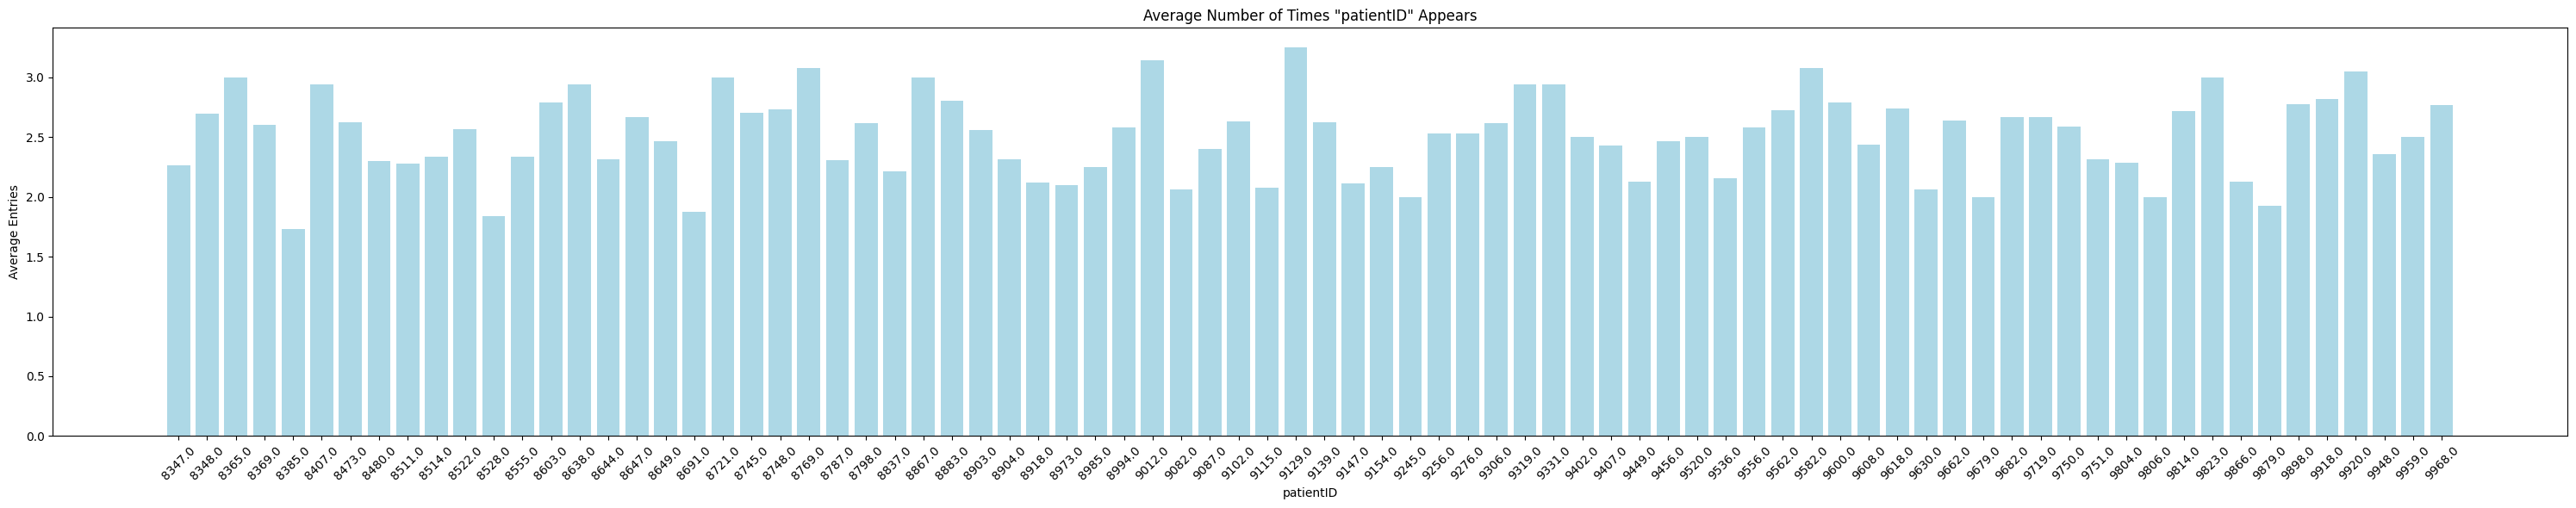

In [37]:
patient_counts = []
patient_labels = []
for _, row in average_patient_counts.iterrows():
    patient_labels.append(str(row[0]))
    patient_counts.append(row[1])
    
chunk_size = 160
ranges = list(range(0, len(patient_counts), chunk_size))

# viz by ranges 
for _, i in enumerate(ranges):
    plt.figure(figsize=(30, 6))
    plt.bar(patient_labels[i:i + chunk_size], patient_counts[i:i + chunk_size], color='lightblue')
    plt.xlabel('patientID')
    plt.ylabel('Average Entries')
    plt.title(f'Average Number of Times "patientID" Appears')
    plt.xticks(patient_labels[i:i + chunk_size], rotation=45)
    plt.tight_layout()
    plt.show()

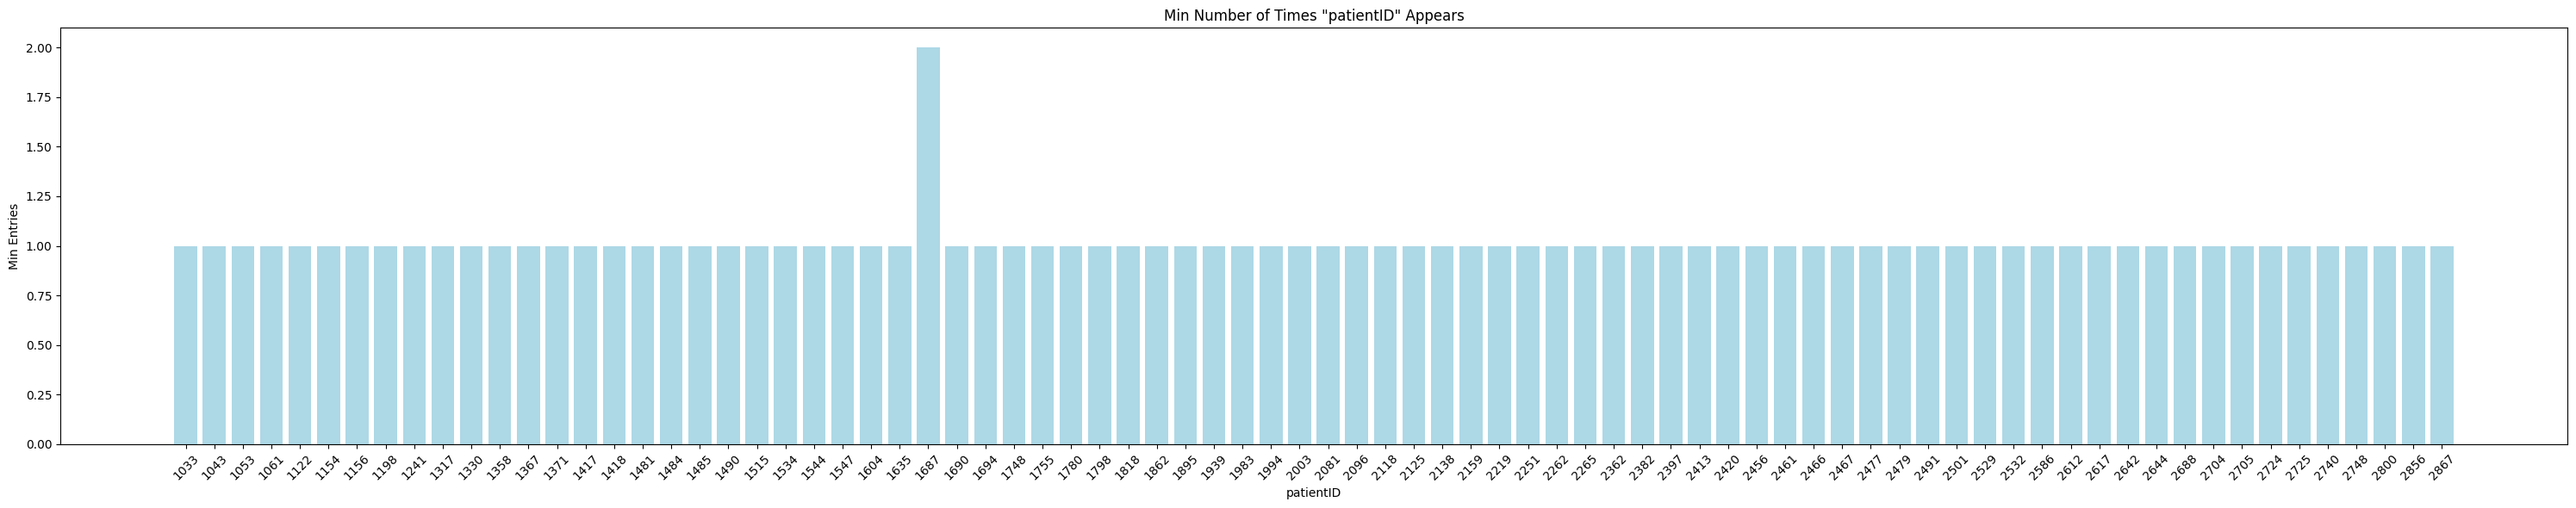

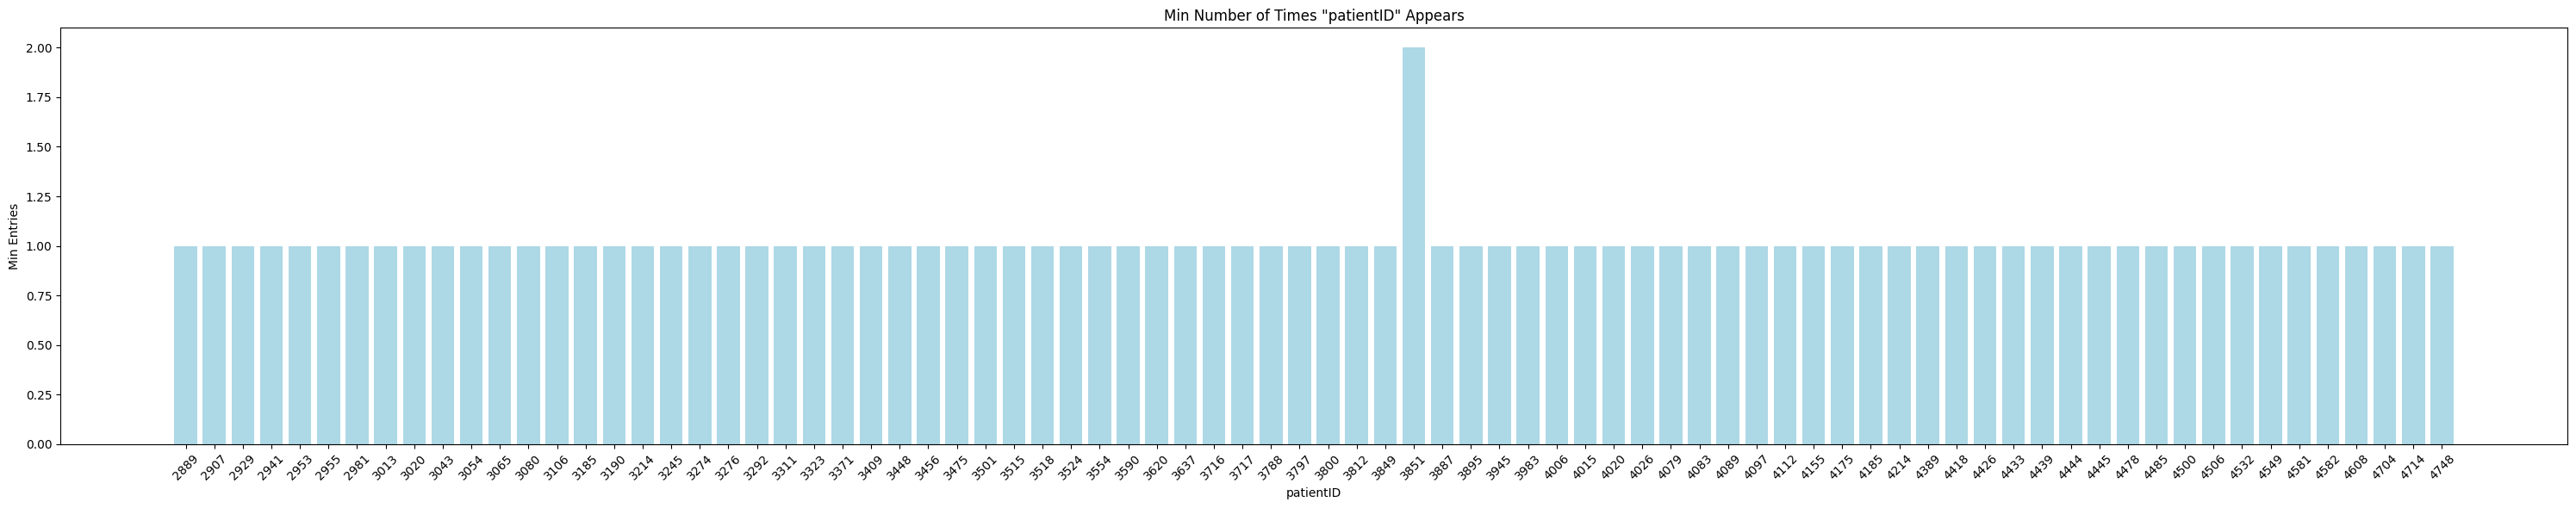

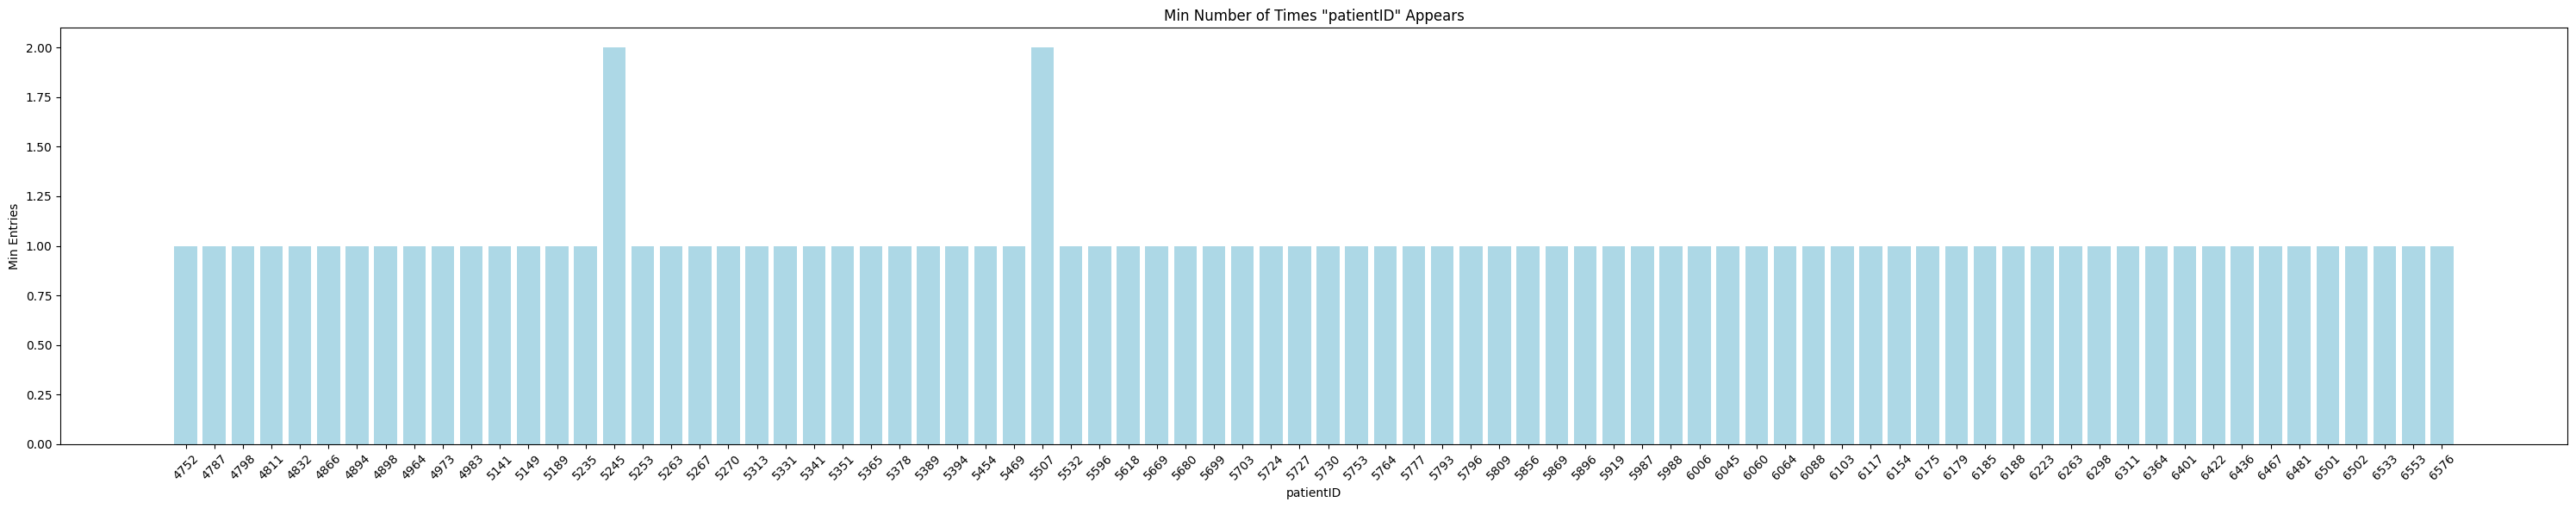

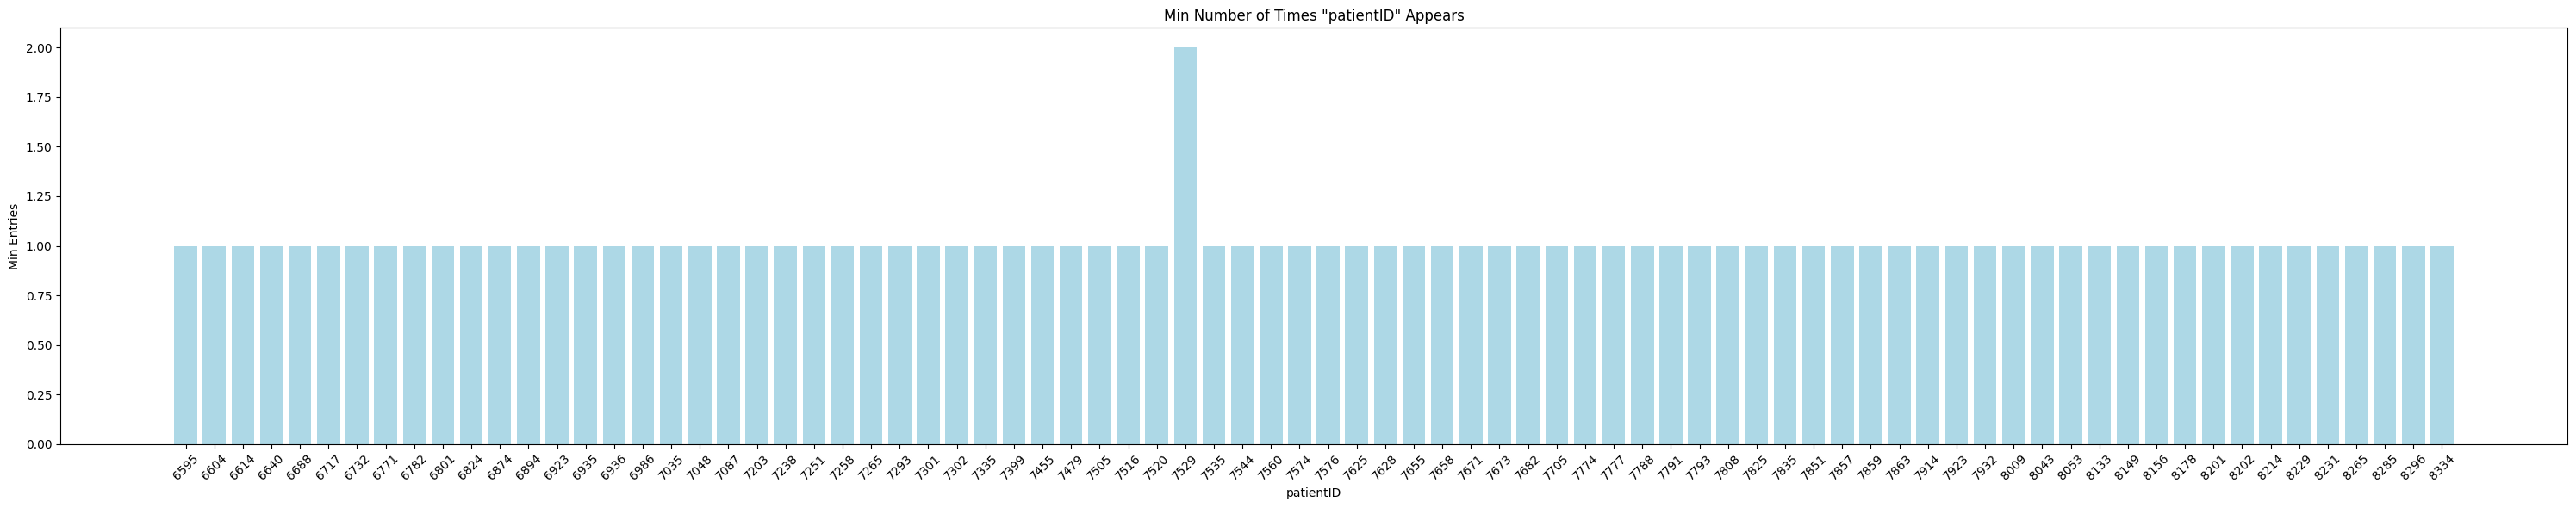

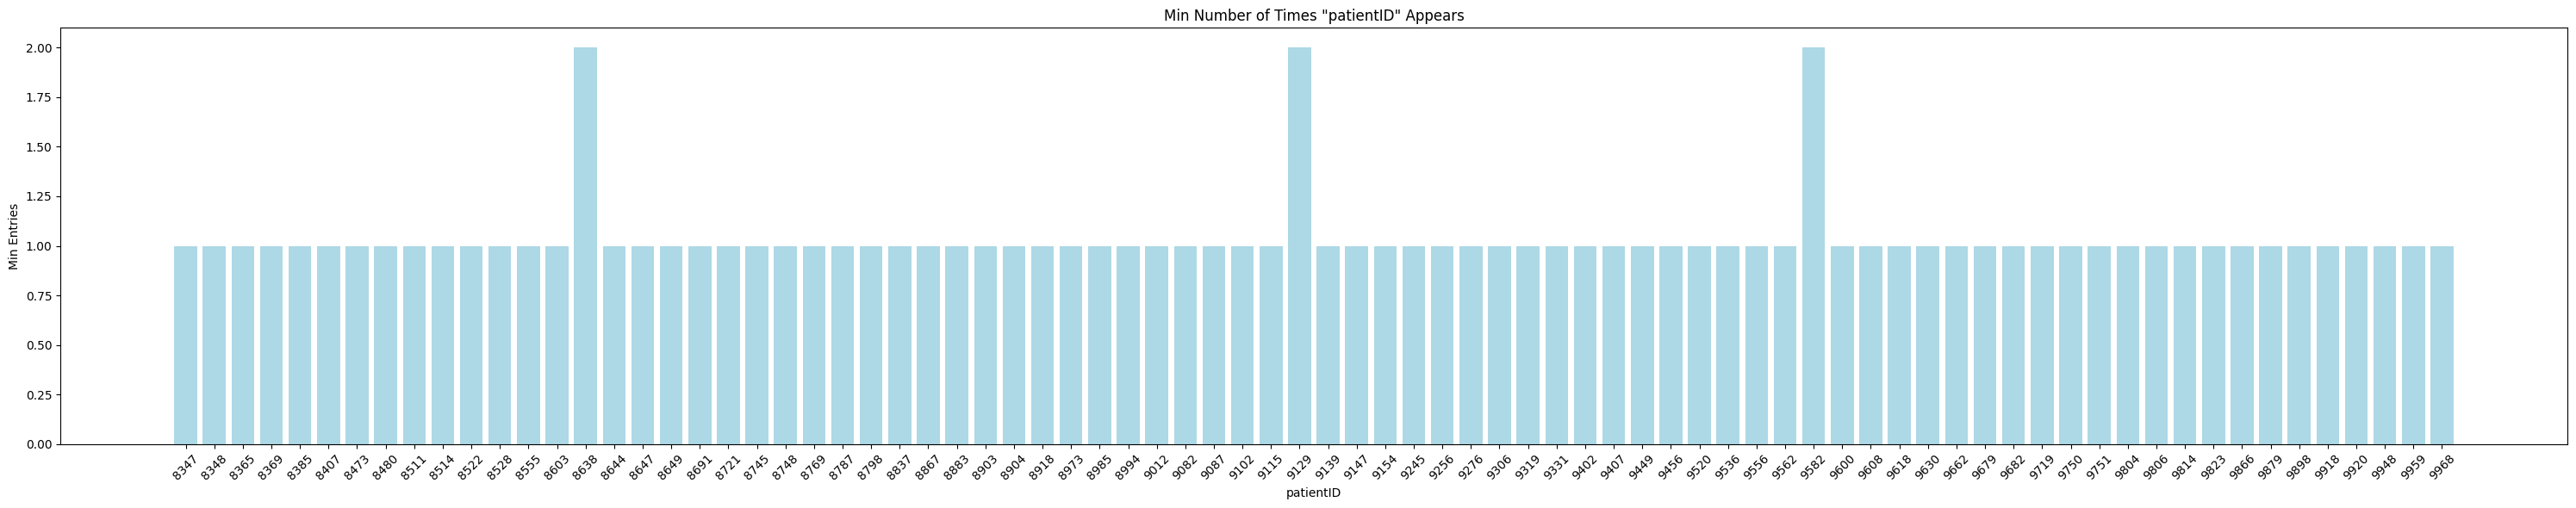

In [38]:
min_patient_counts = patient_study_counts.groupby('patientID')['count'].min().reset_index(name='min_count')
patient_counts = []
patient_labels = []
for _, row in min_patient_counts.iterrows():
    patient_labels.append(str(row[0]))
    patient_counts.append(row[1])
    
chunk_size = 80
ranges = list(range(0, len(patient_counts), chunk_size))

# viz by ranges 
for _, i in enumerate(ranges):
    plt.figure(figsize=(30, 6))
    plt.bar(patient_labels[i:i + chunk_size], patient_counts[i:i + chunk_size], color='lightblue')
    plt.xlabel('patientID')
    plt.ylabel('Min Entries')
    plt.title(f'Min Number of Times "patientID" Appears')
    plt.xticks(patient_labels[i:i + chunk_size], rotation=45)
    plt.tight_layout()
    plt.show()

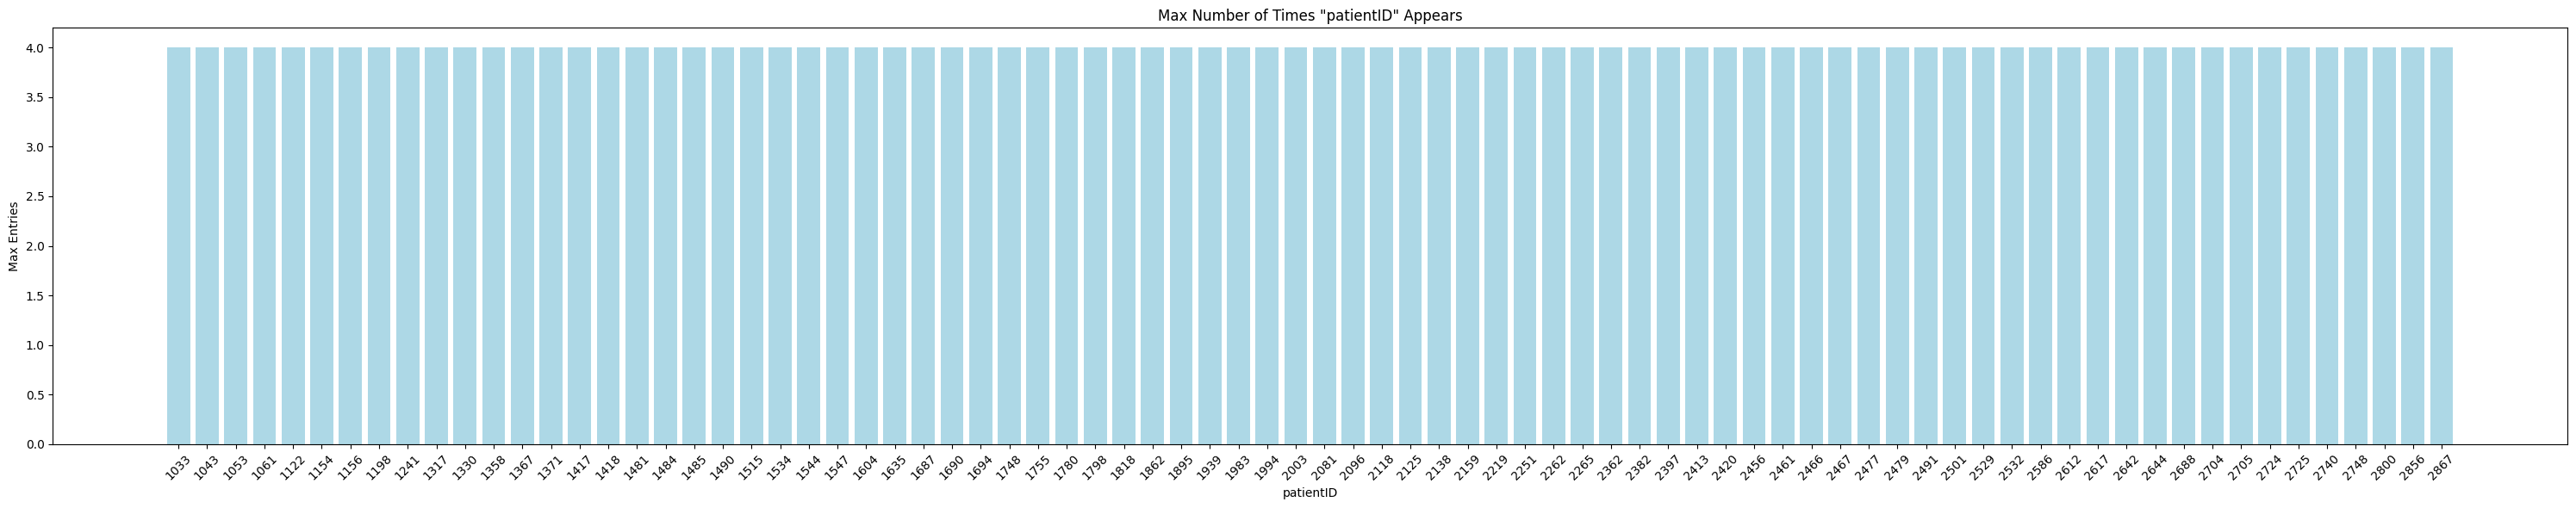

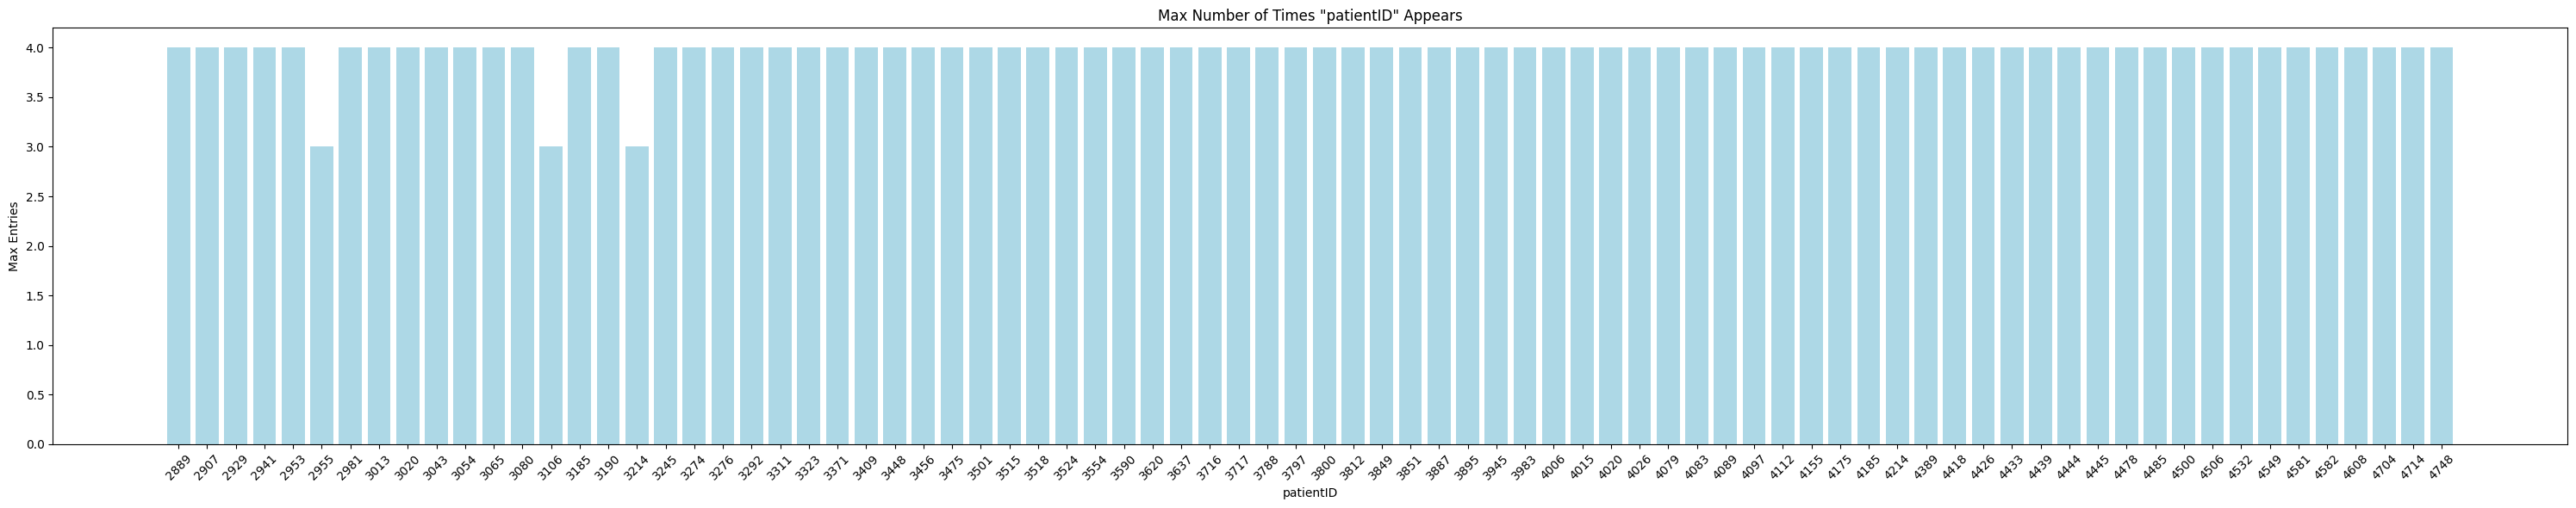

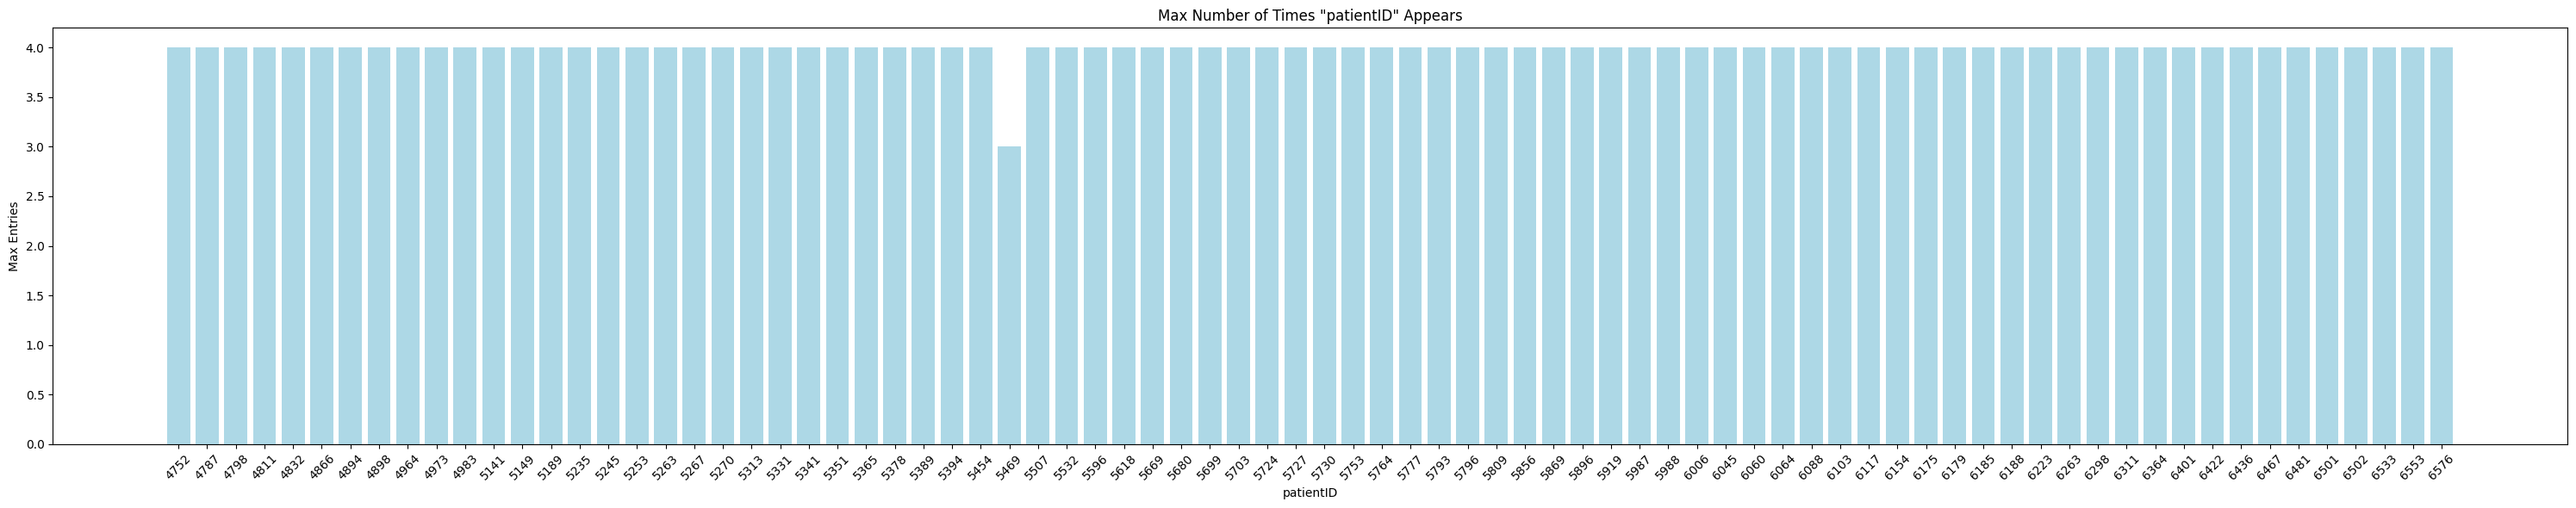

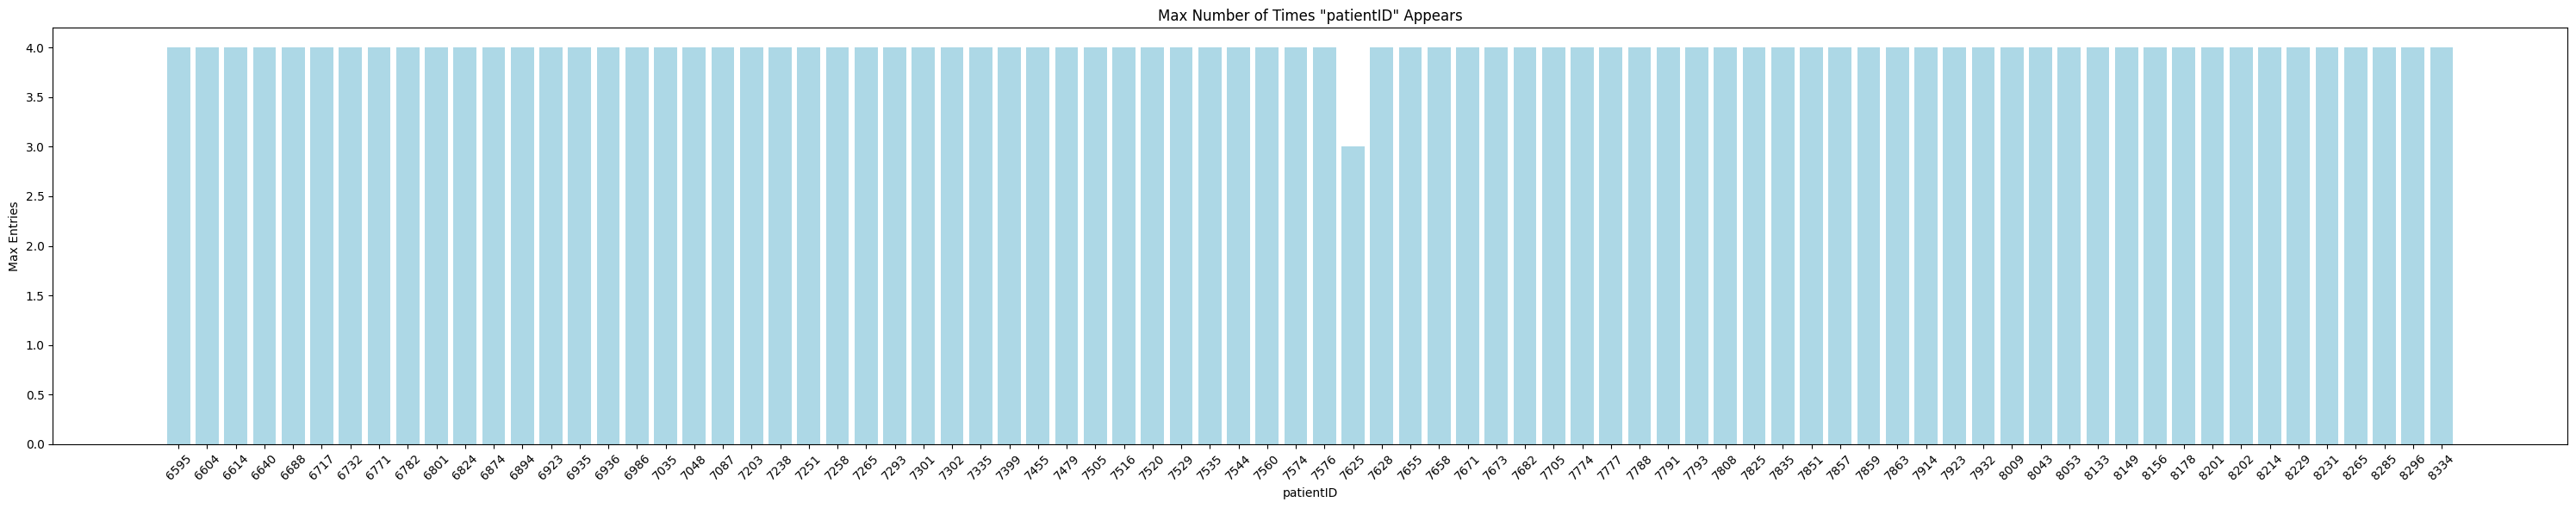

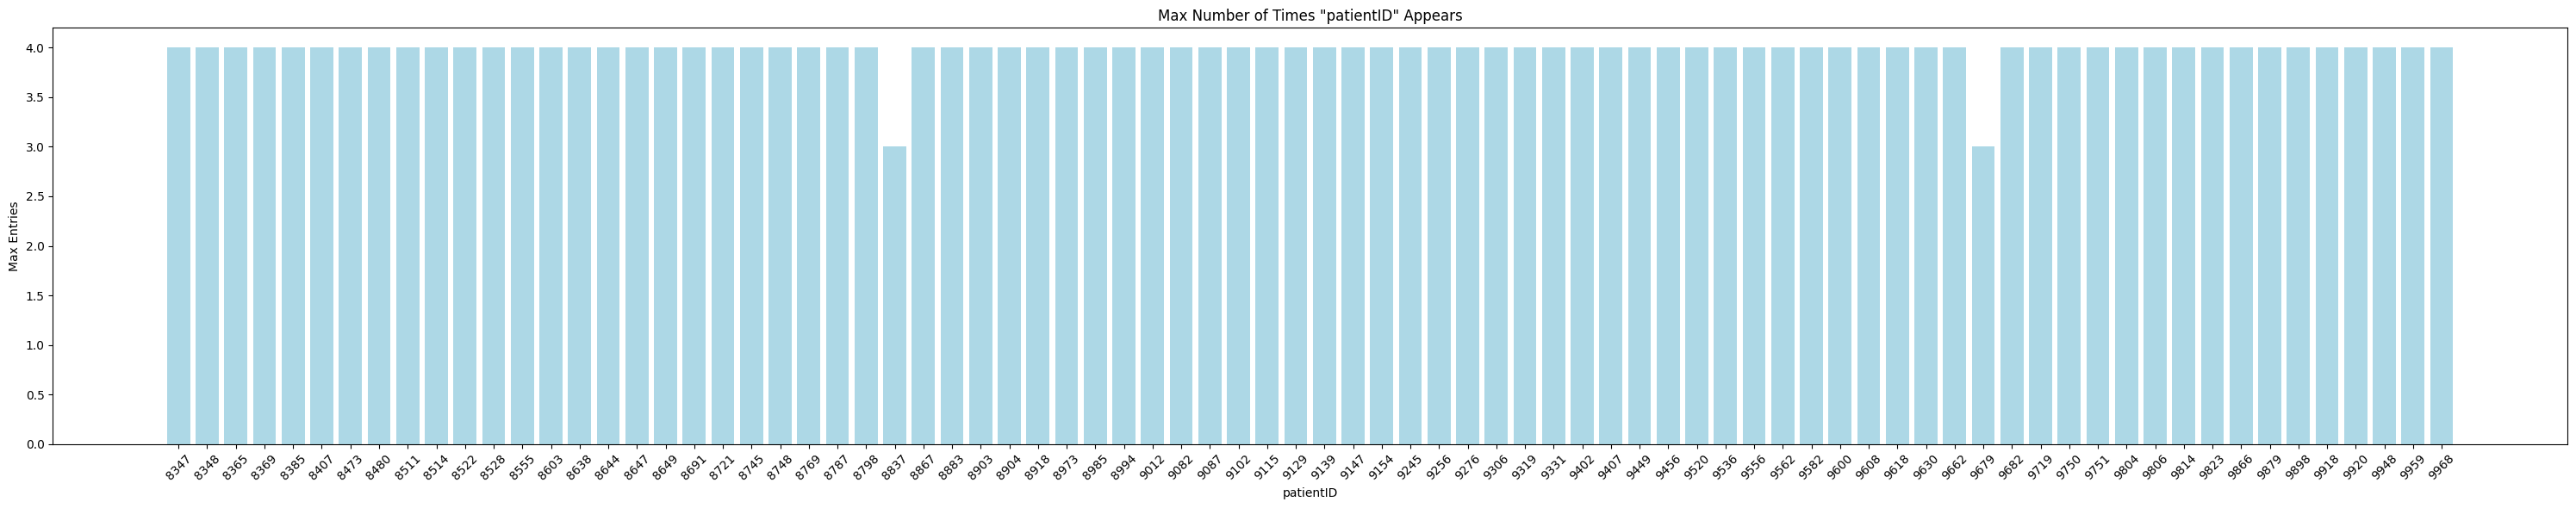

In [39]:
max_patient_counts = patient_study_counts.groupby('patientID')['count'].max().reset_index(name='max_count')
patient_counts = []
patient_labels = []
for _, row in max_patient_counts.iterrows():
    patient_labels.append(str(row[0]))
    patient_counts.append(row[1])
    
chunk_size = 80
ranges = list(range(0, len(patient_counts), chunk_size))

# viz by ranges 
for _, i in enumerate(ranges):
    plt.figure(figsize=(30, 6))
    plt.bar(patient_labels[i:i + chunk_size], patient_counts[i:i + chunk_size], color='lightblue')
    plt.xlabel('patientID')
    plt.ylabel('Max Entries')
    plt.title(f'Max Number of Times "patientID" Appears')
    plt.xticks(patient_labels[i:i + chunk_size], rotation=45)
    plt.tight_layout()
    plt.show()


## getting date ranges per patient per study

In [40]:
# group by (patientID, studyId) and get the min and max timestamps
min_max_dates_df = df.groupby(['patientID', 'studyID'])['timestamp'].agg(['min', 'max']).reset_index()
min_max_dates_df = min_max_dates_df.rename(columns={'min': 'min_date', 'max': 'max_date'})

In [41]:
min_max_dates_df

patientID  studyID            min_date            max_date
0          1033        5 2022-01-09 13:57:02 2022-09-03 23:11:27
1          1033       21 2022-03-19 01:43:02 2022-04-13 08:33:41
2          1033       22 2022-03-27 09:34:45 2022-04-22 01:42:57
3          1033       27 2022-05-15 14:30:29 2022-06-26 23:39:48
4          1033       29 2022-01-02 13:11:21 2022-01-06 21:51:24
...         ...      ...                 ...                 ...
6038       9968       64 2022-05-08 09:25:59 2022-09-03 18:22:55
6039       9968       70 2022-02-10 01:48:01 2022-07-29 12:44:53
6040       9968       74 2022-02-18 00:07:29 2022-02-18 00:07:29
6041       9968       78 2022-08-30 07:37:32 2022-09-27 02:27:47
6042       9968       91 2022-05-04 20:31:47 2022-06-13 01:27:50

[6043 rows x 4 columns]

## create graph where Y is number of patients and X is date that patients joined/entered

In [42]:
from datetime import timedelta

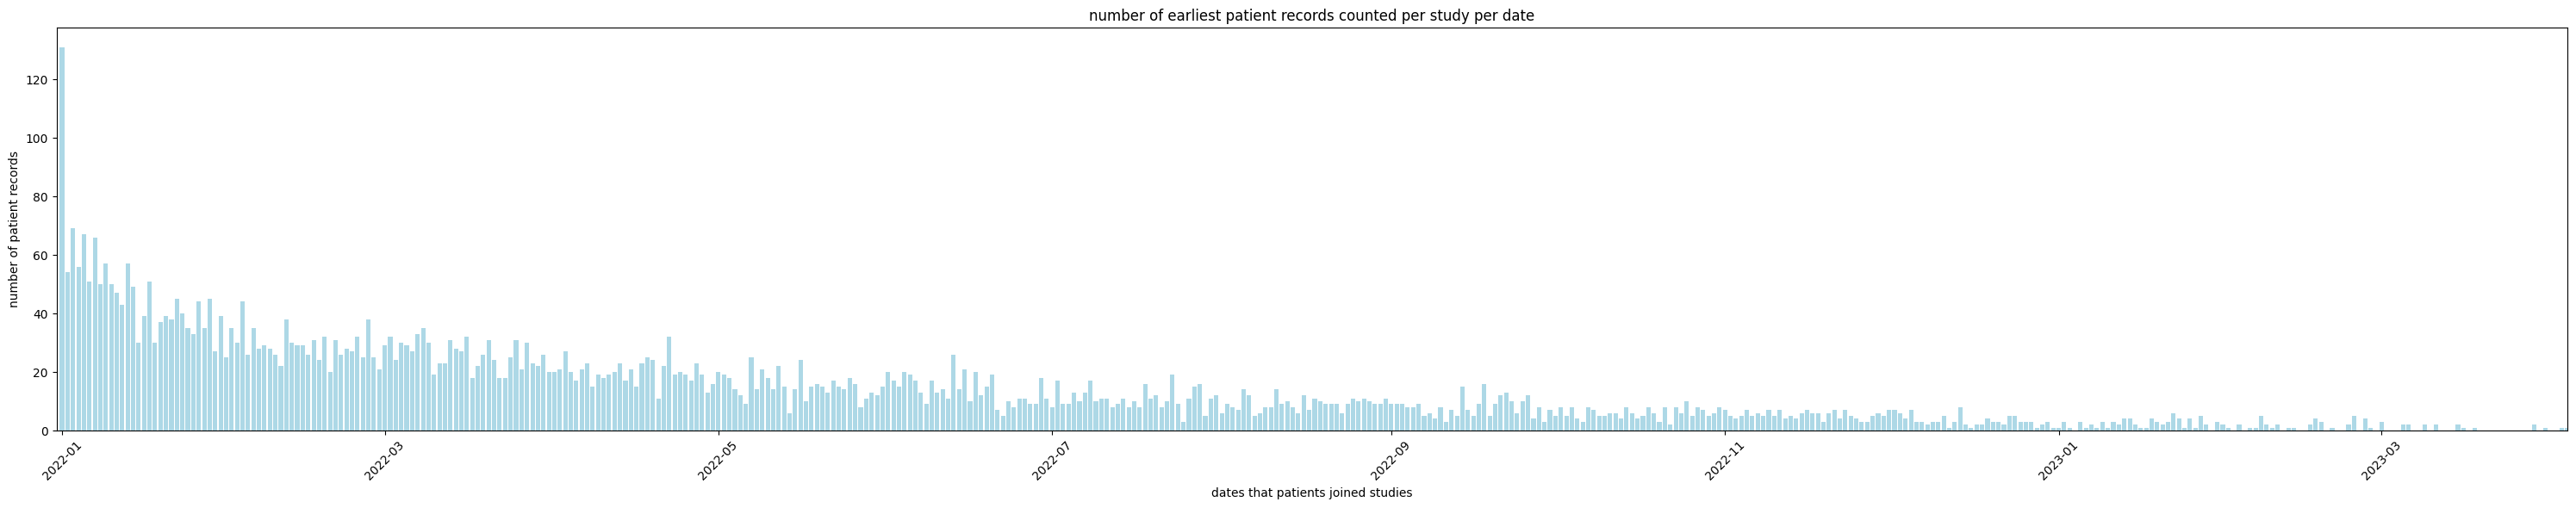

In [43]:
earliest_patient_record_per_study = df.groupby(["patientID","studyID"])["timestamp"].min().reset_index()
patient_joined_per_date = earliest_patient_record_per_study.groupby(pd.Grouper(key="timestamp",freq="D"))["patientID"].count()
plt.figure(figsize=(30, 6))
plt.bar(patient_joined_per_date.index, patient_joined_per_date.values, color='lightblue')
plt.xlabel('dates that patients joined studies')
plt.ylabel('number of patient records')
plt.title('number of earliest patient records counted per study per date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.xlim(patient_joined_per_date.index[0]-timedelta(days=1),patient_joined_per_date.index[-1])
#plt.savefig("earliestNumberOfPatientRecordsPerStudyPerDate_graph8.png")
plt.show()

notice that on sept 7th, there are 5 patient records that joined unique studies. However, there are 4 unique patient ids that joined that day.

| studyID | patientID |  timestamp  |
|--------:|----------:|:-----------:|
|      28 |      7859 | 2022-09-07  |
|      30 |      3851 | 2022-09-07  |
|      33 |      1358 | 2022-09-07  |
|      79 |      2612 | 2022-09-07  |
|      97 |      7859 | 2022-09-07  |

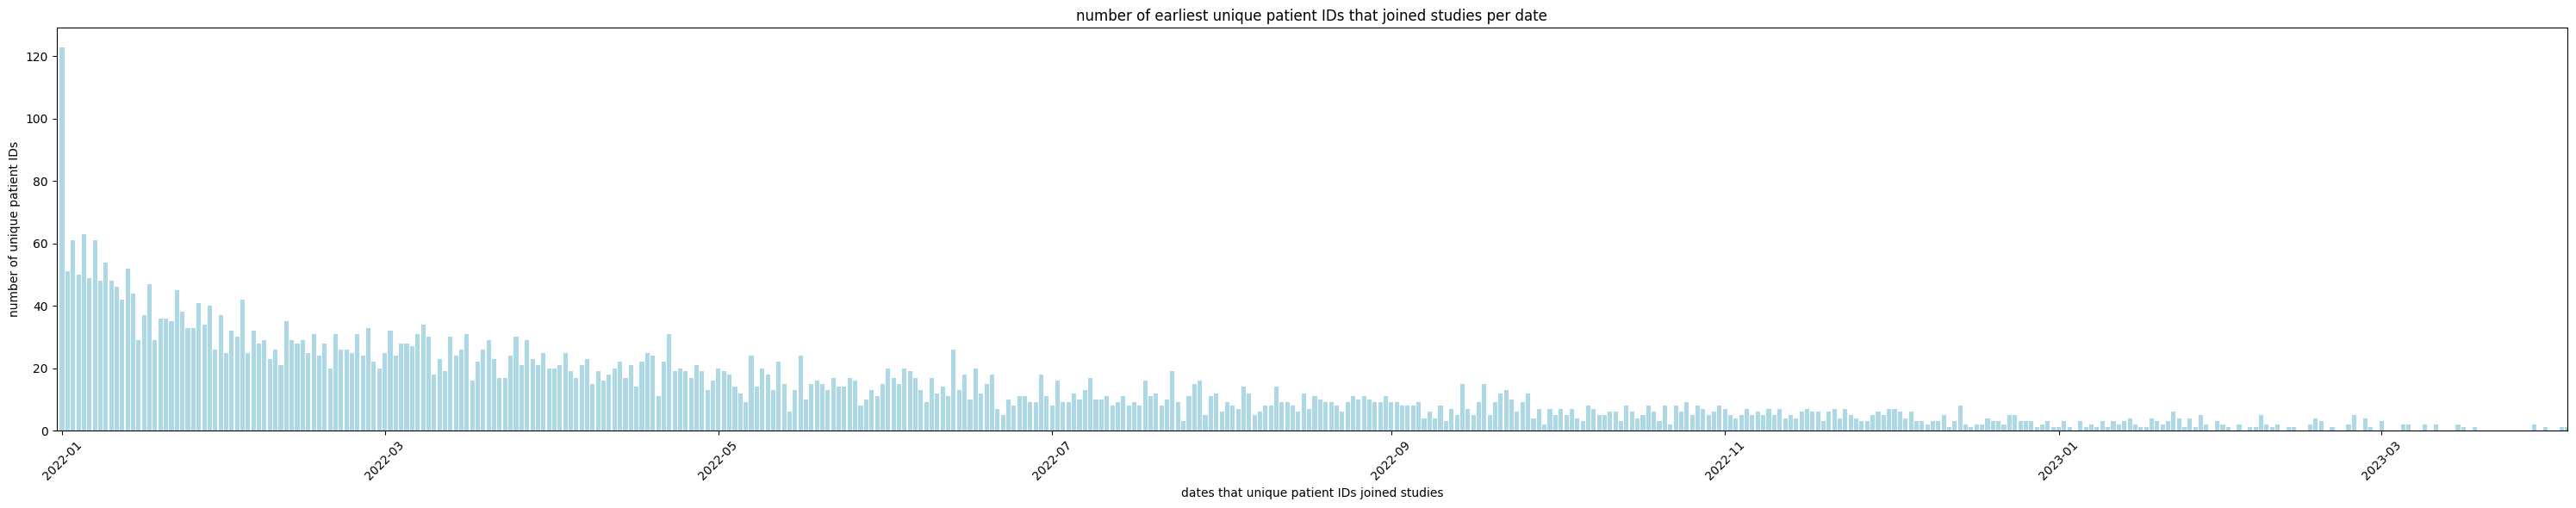

In [44]:
earliest_patient_record_per_study = df.groupby(["patientID","studyID"])["timestamp"].min().reset_index()
patient_joined_per_date = earliest_patient_record_per_study.groupby(pd.Grouper(key="timestamp",freq="D"))["patientID"].nunique()
plt.figure(figsize=(30, 6))
plt.bar(patient_joined_per_date.index, patient_joined_per_date.values, color='lightblue')
plt.xlabel('dates that unique patient IDs joined studies')
plt.ylabel('number of unique patient IDs')
plt.title('number of earliest unique patient IDs that joined studies per date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.xlim(patient_joined_per_date.index[0]-timedelta(days=1),patient_joined_per_date.index[-1])
plt.show()

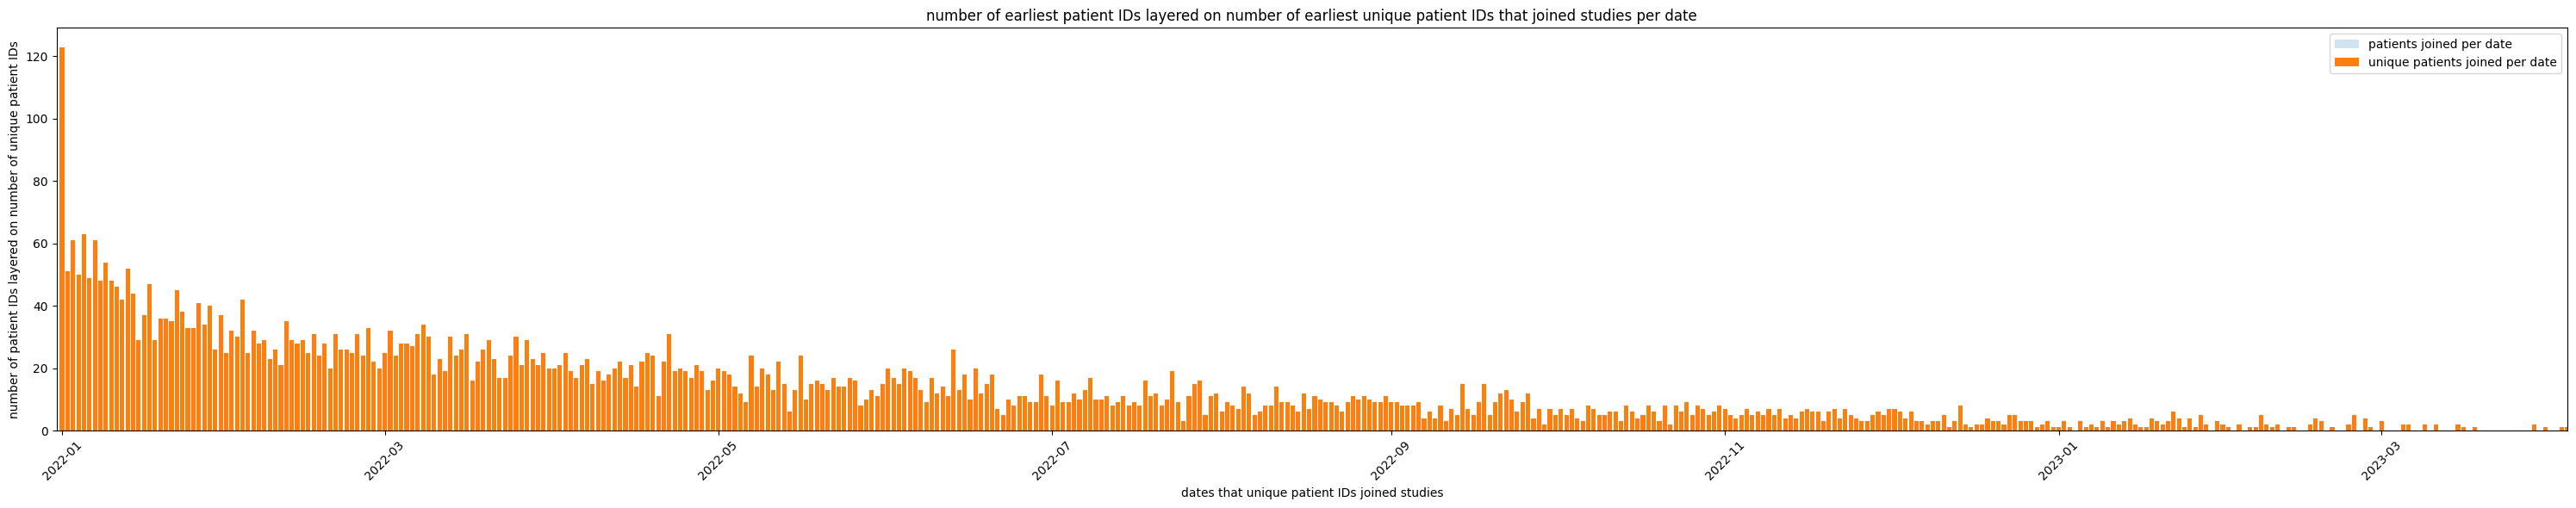

In [45]:
earliest_unique_patient_record_per_study = df.groupby(["patientID","studyID"])["timestamp"].min().reset_index()
unique_patient_joined_per_date = earliest_patient_record_per_study.groupby(pd.Grouper(key="timestamp",freq="D"))["patientID"].nunique()
plt.figure(figsize=(30, 6))
plt.bar(patient_joined_per_date.index, patient_joined_per_date.values, alpha=0.2, label="patients joined per date")
plt.bar(unique_patient_joined_per_date.index, unique_patient_joined_per_date.values,alpha=1, label="unique patients joined per date")
plt.xlabel('dates that unique patient IDs joined studies')
plt.ylabel('number of patient IDs layered on number of unique patient IDs')
plt.title('number of earliest patient IDs layered on number of earliest unique patient IDs that joined studies per date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()

plt.xlim(patient_joined_per_date.index[0]-timedelta(days=1),patient_joined_per_date.index[-1])
#plt.xlim(-0.5, len(patient_joined_per_date.values), 0.5)
plt.show()

## chunking across studies for the task above

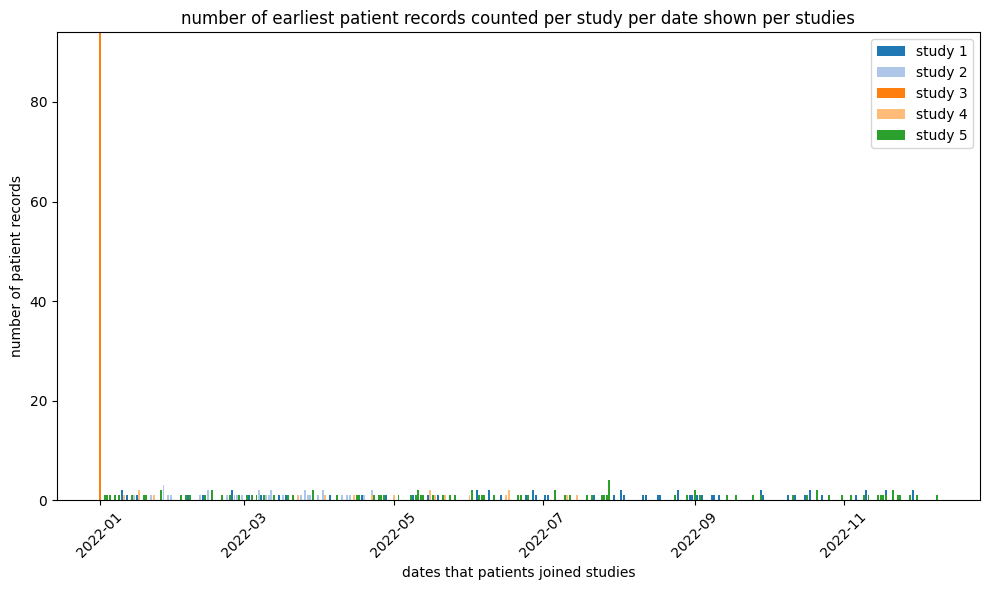

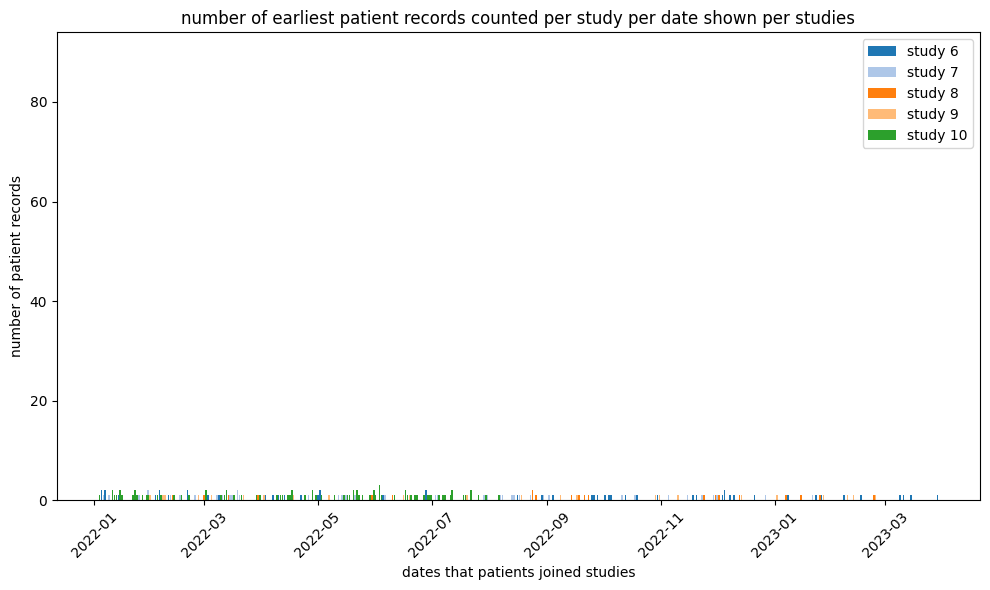

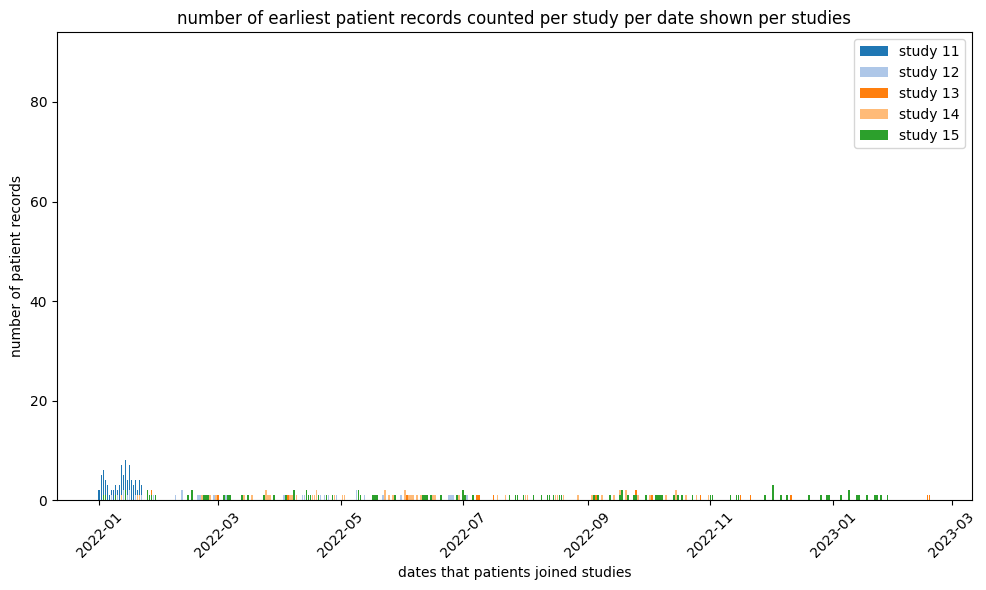

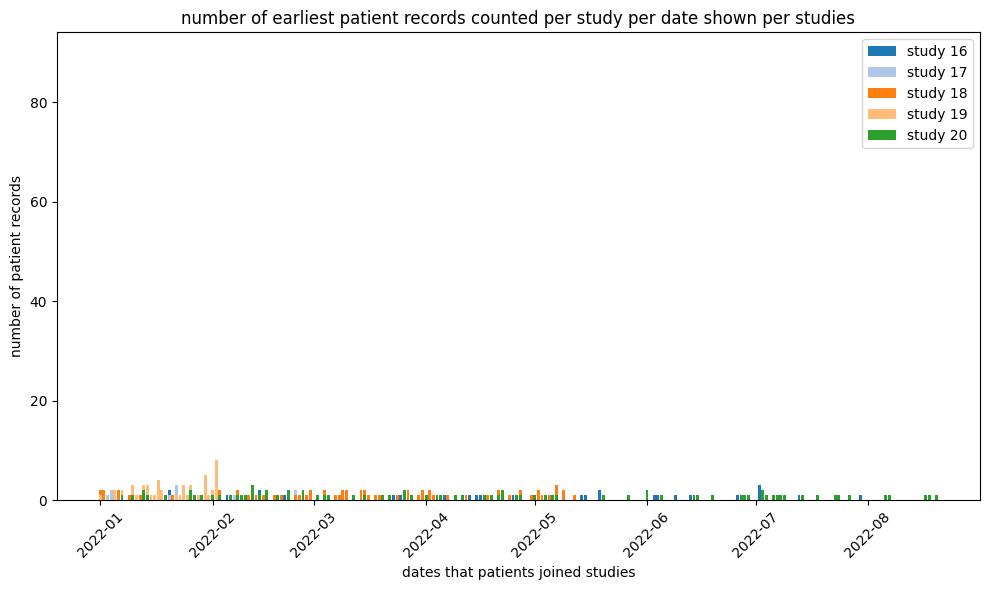

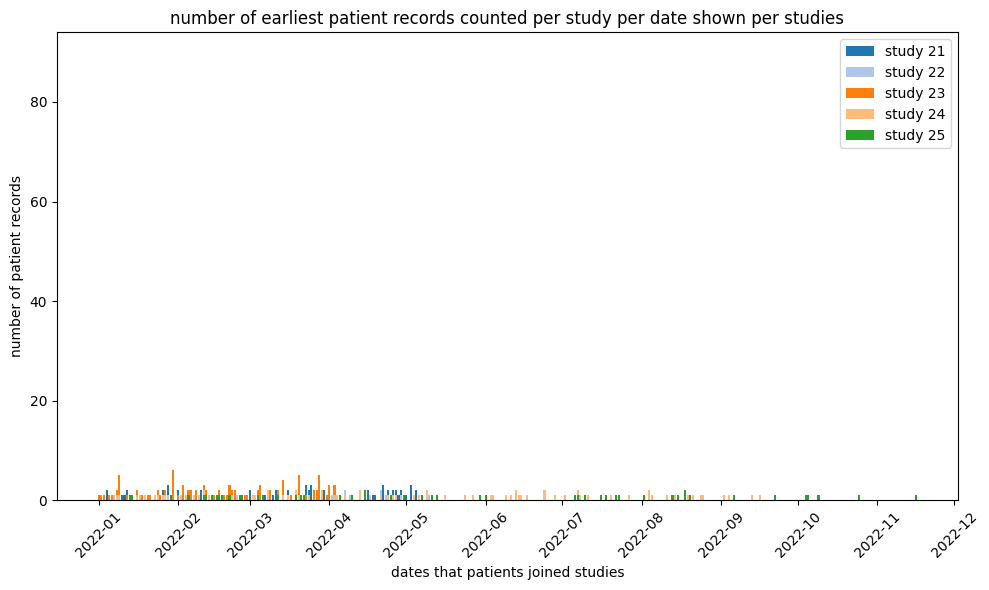

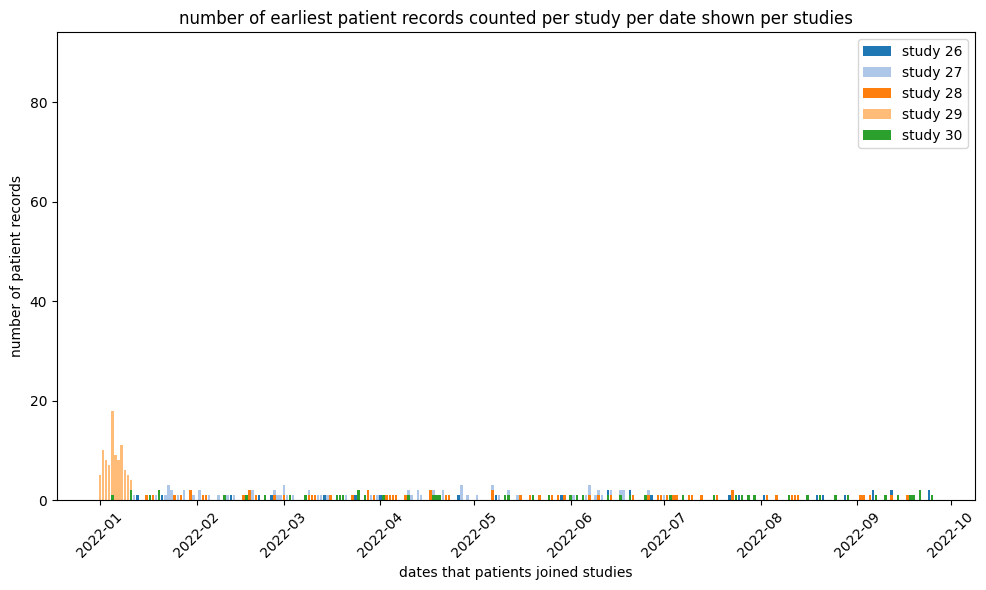

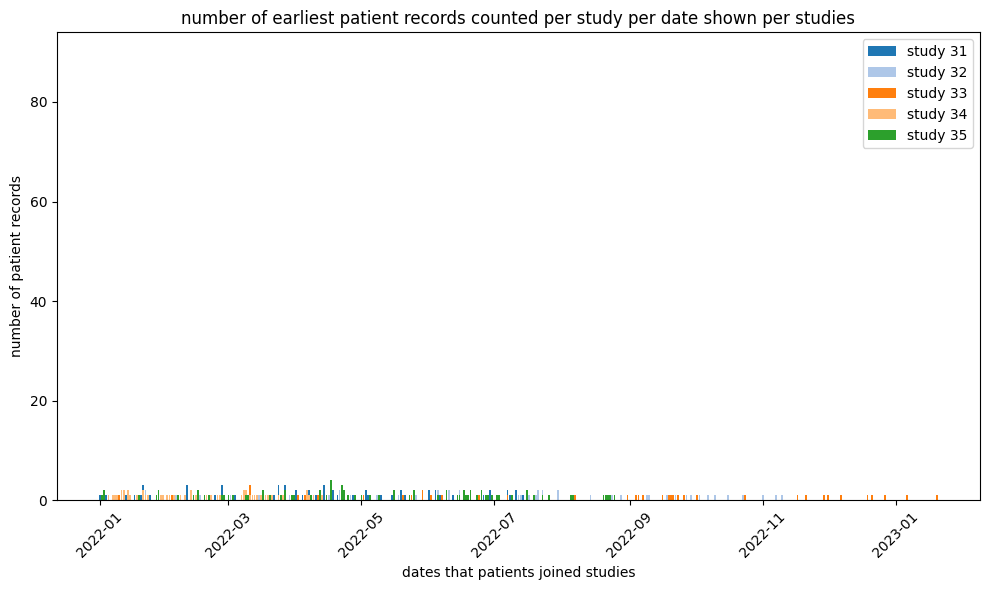

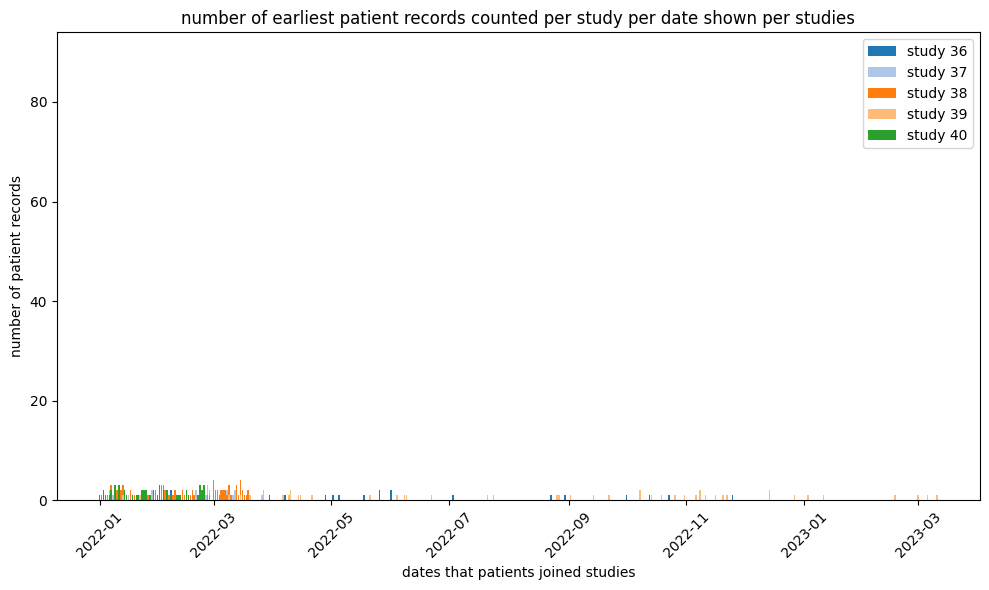

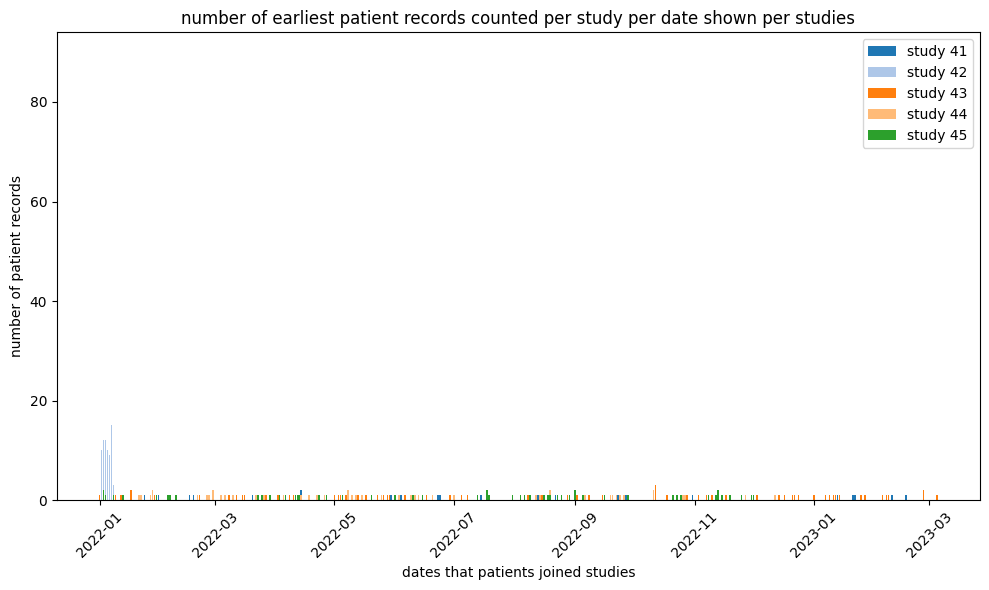

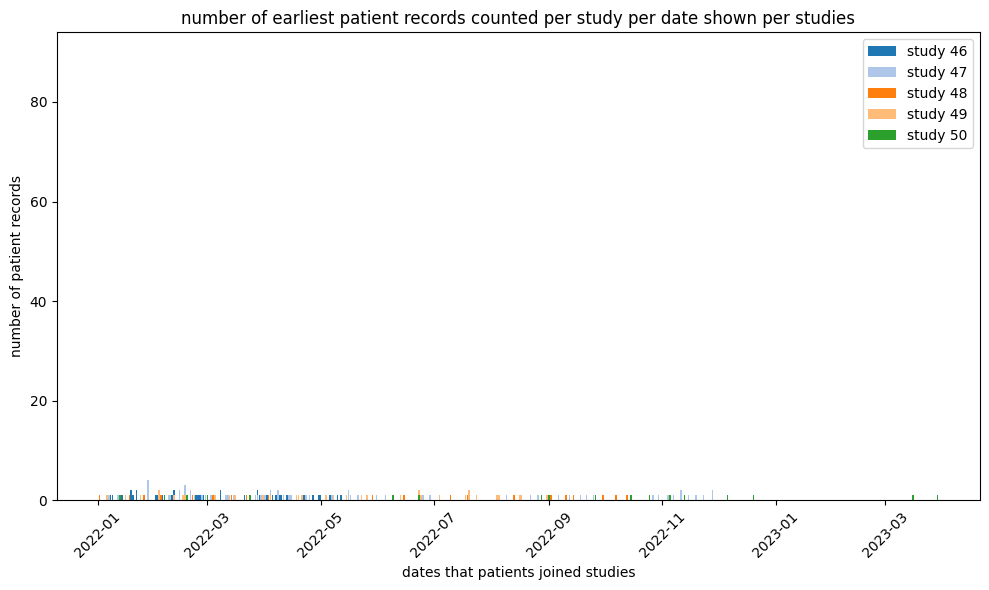

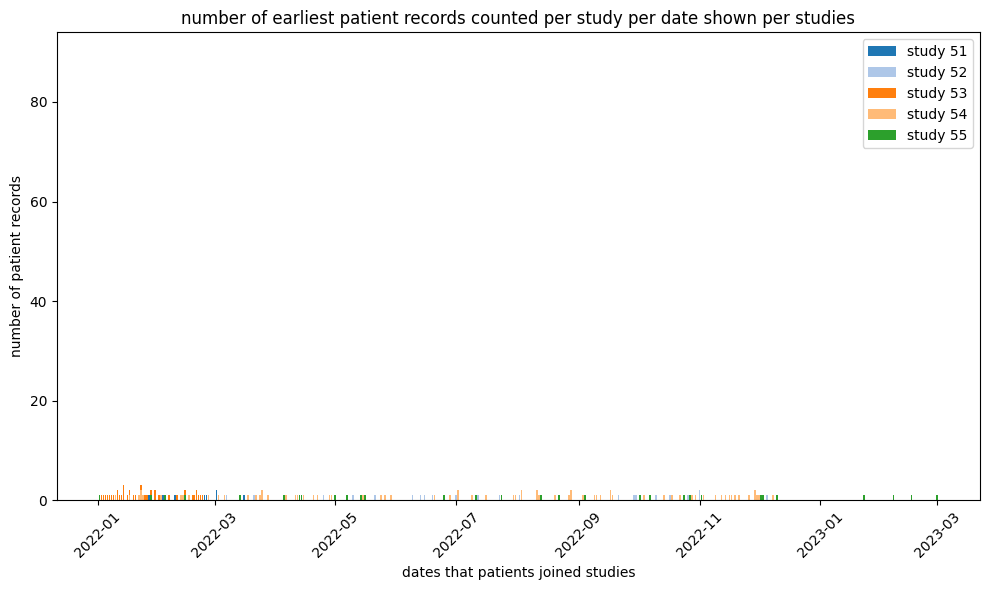

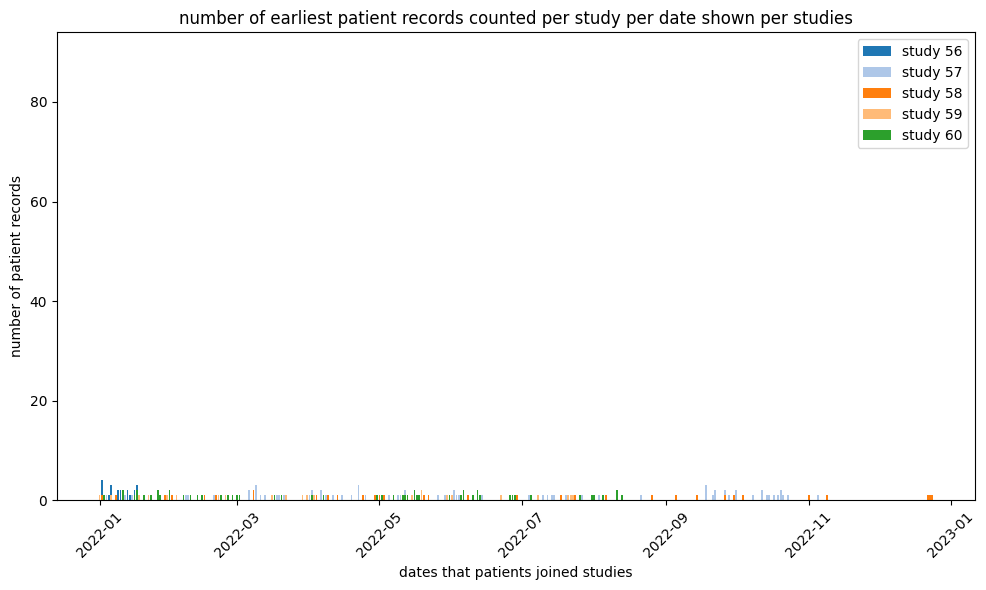

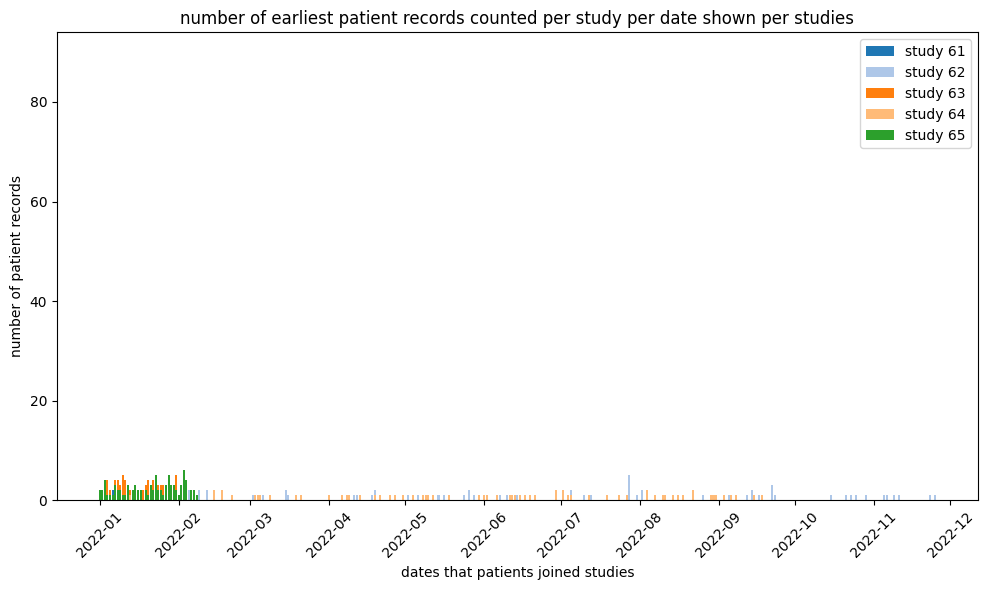

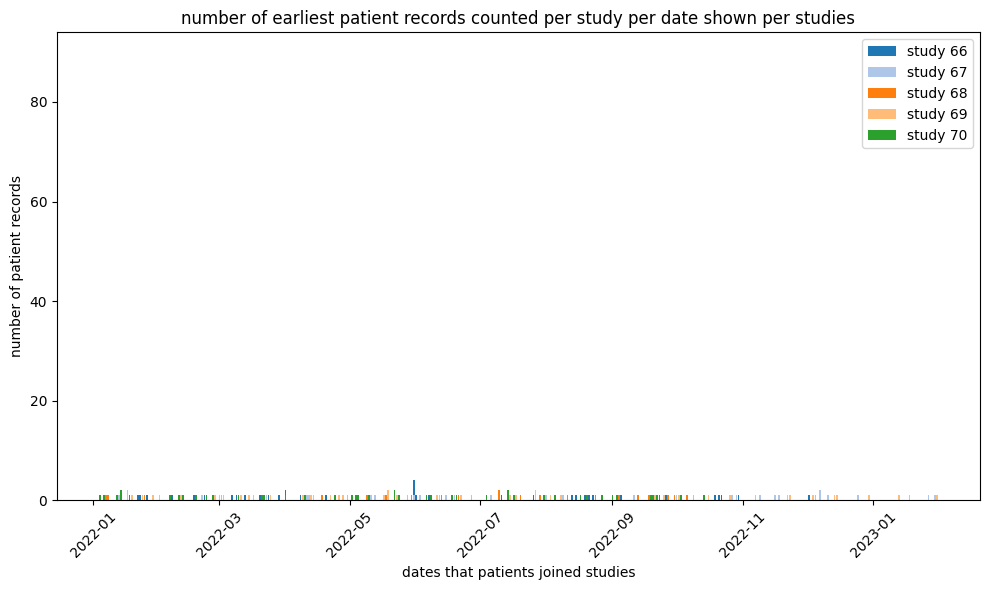

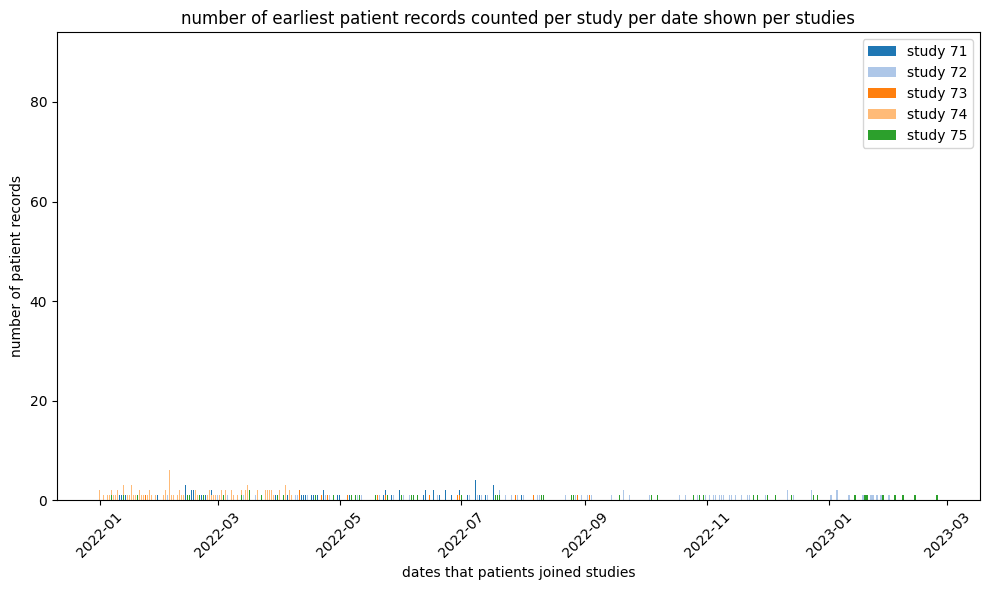

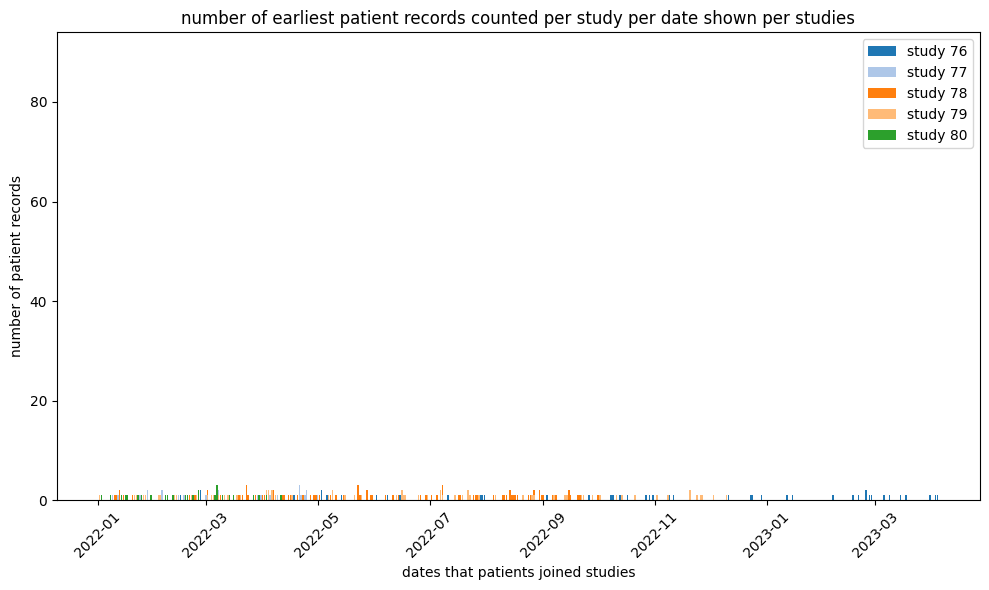

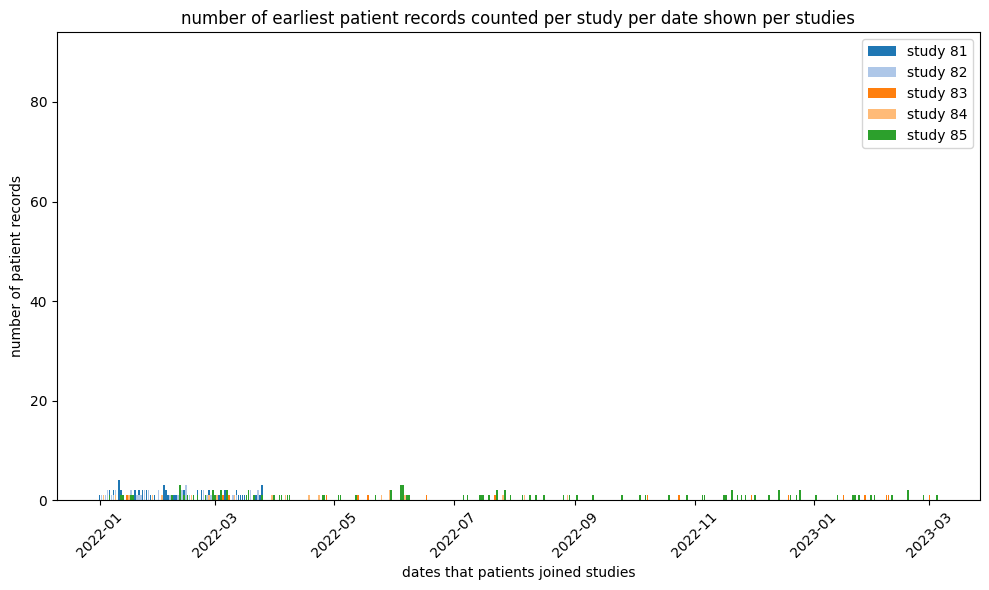

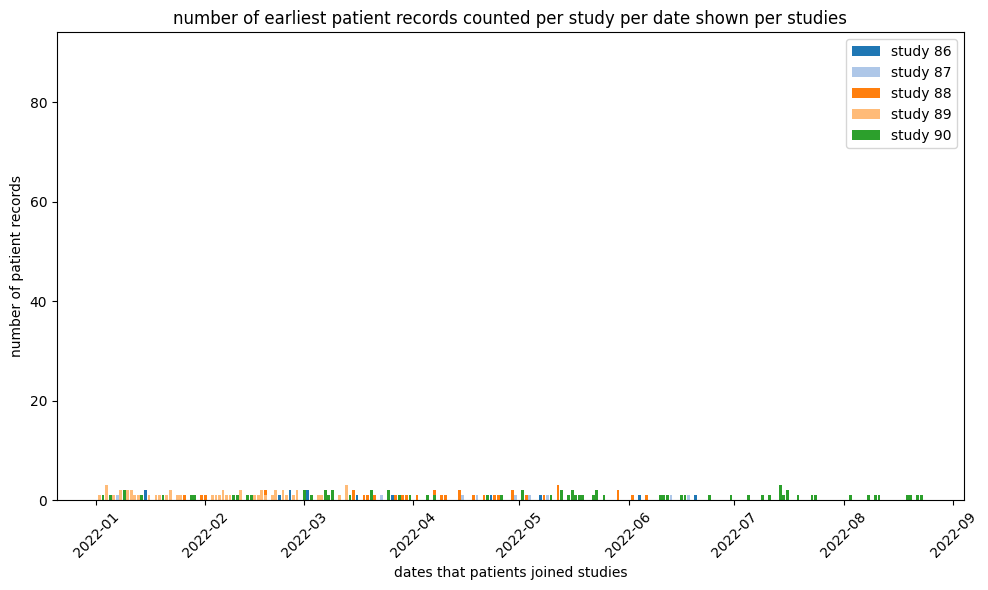

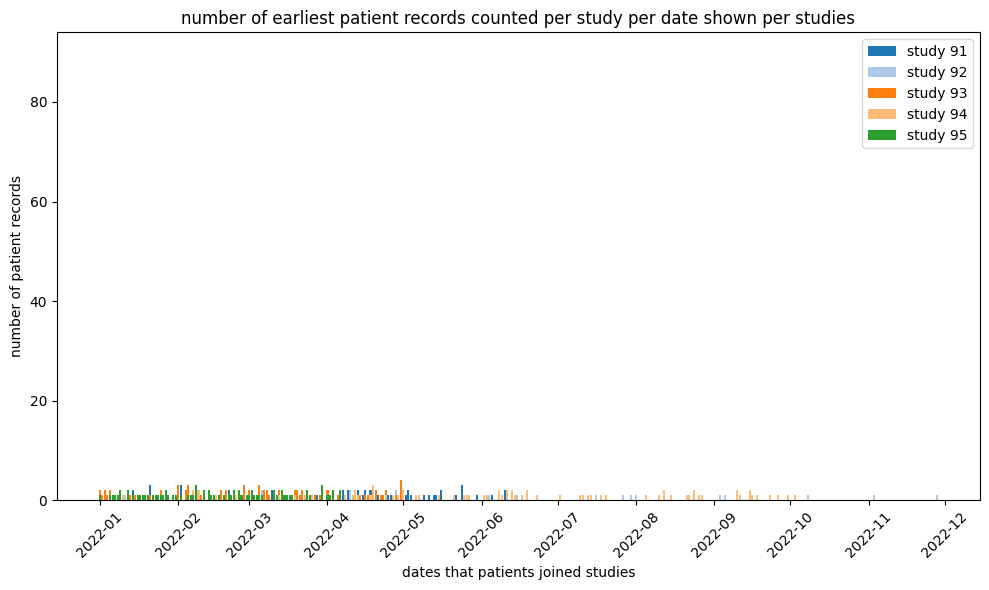

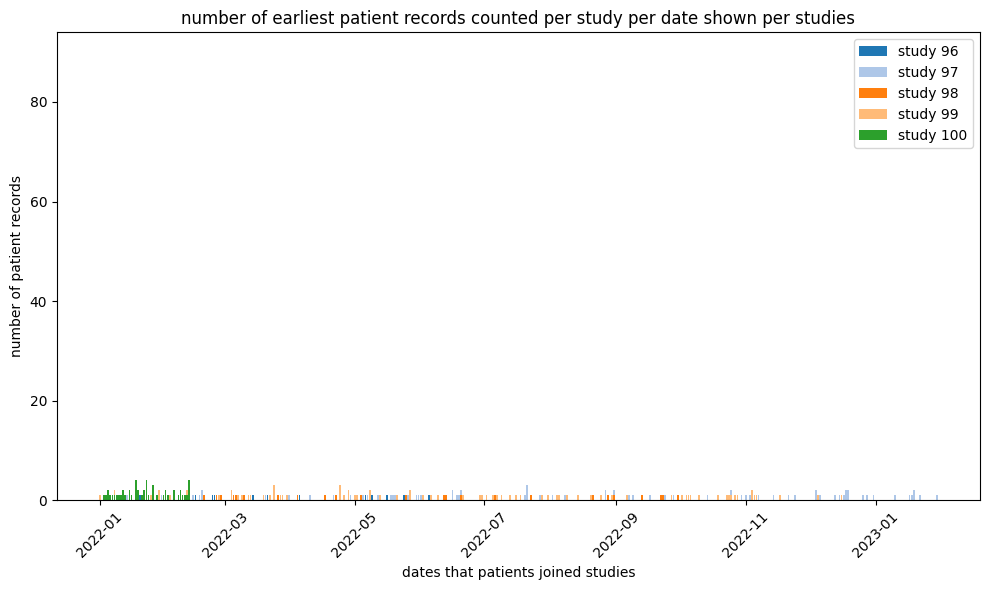

In [46]:
earliest_patient_record_per_study = df.groupby(["patientID","studyID"])["timestamp"].min().reset_index()
patient_joined_per_date = earliest_patient_record_per_study.groupby(['studyID', pd.Grouper(key="timestamp",freq="D")])["patientID"].count()
unique_study_ids = df['studyID'].unique()
# chunk the studies 
chunk_size = 5
study_id_groups = [unique_study_ids[i:i+chunk_size] for i in range(0, len(unique_study_ids), chunk_size)]

max_count_patients = patient_joined_per_date.max()

for study_id_group in study_id_groups:
    plt.figure(figsize=(10, 6))
    plt.title('number of earliest patient records counted per study per date shown per studies')
    plt.xlabel('dates that patients joined studies')
    plt.ylabel('number of patient records')
    plt.xticks(rotation=45)
    
    for i, study_id in enumerate(study_id_group):
        study_data = patient_joined_per_date[study_id]
        if not study_data.empty:
            color = plt.cm.tab20(i)  # color differently for each study
            plt.bar(study_data.index, study_data.values, color=color, label=f'study {study_id}')
    
    plt.legend()
    plt.ylim(0, max_count_patients)
    plt.tight_layout()
    plt.show()

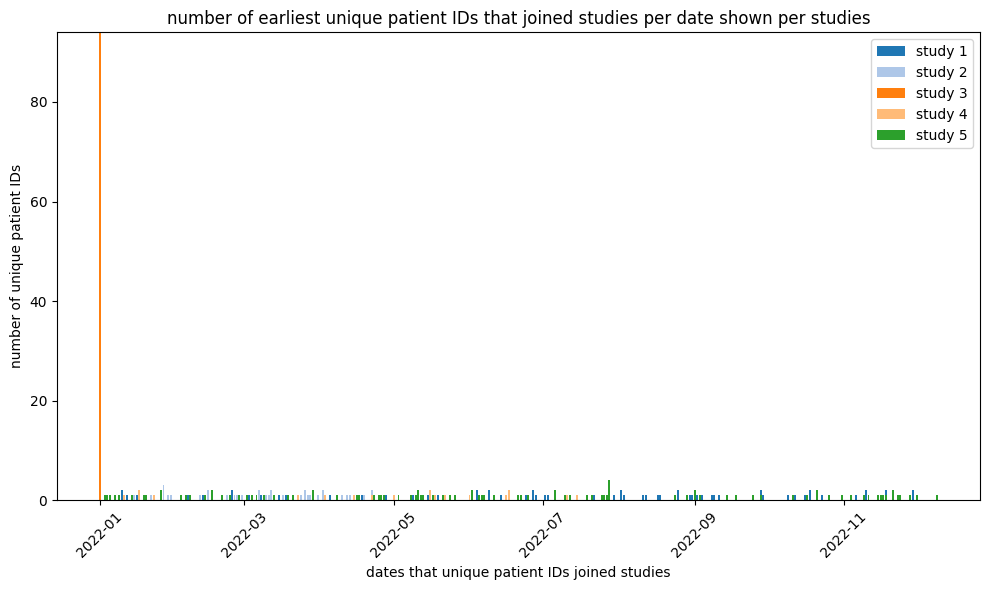

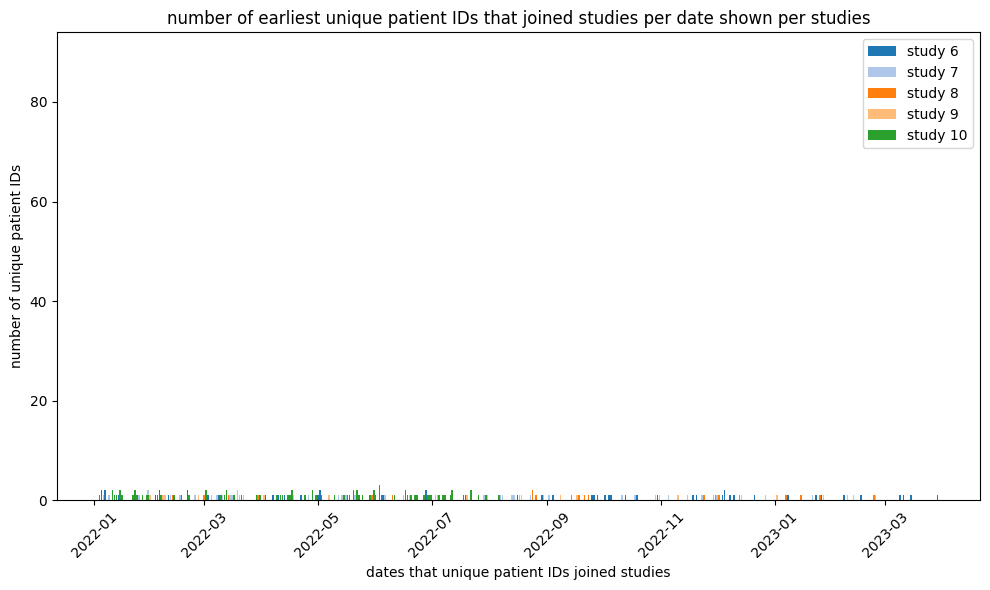

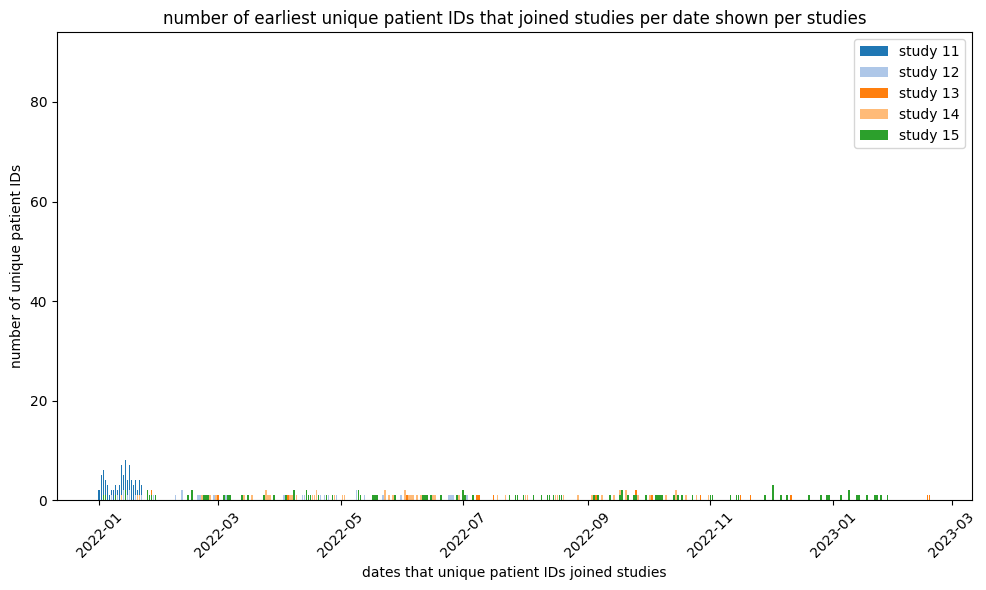

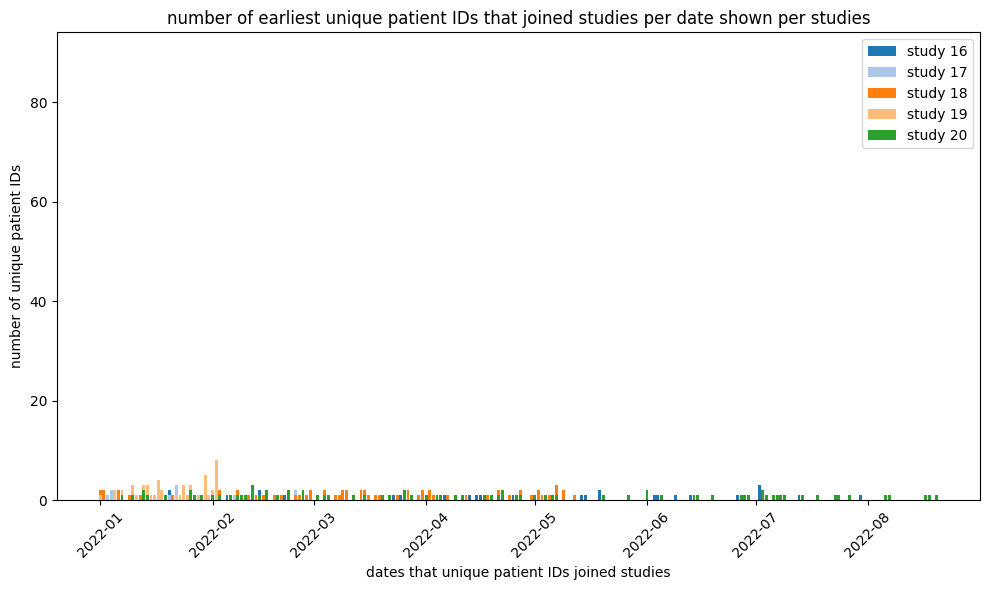

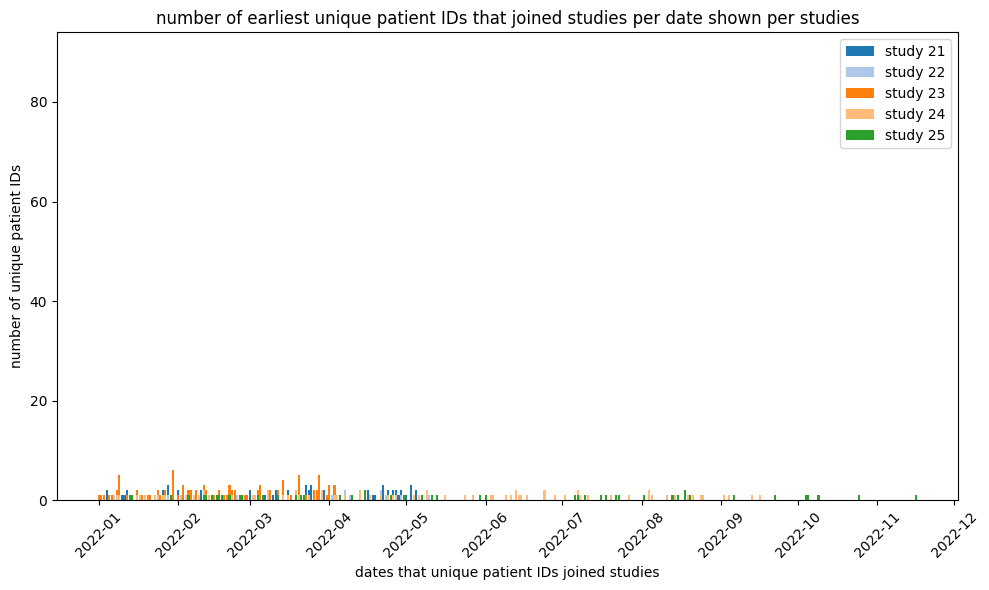

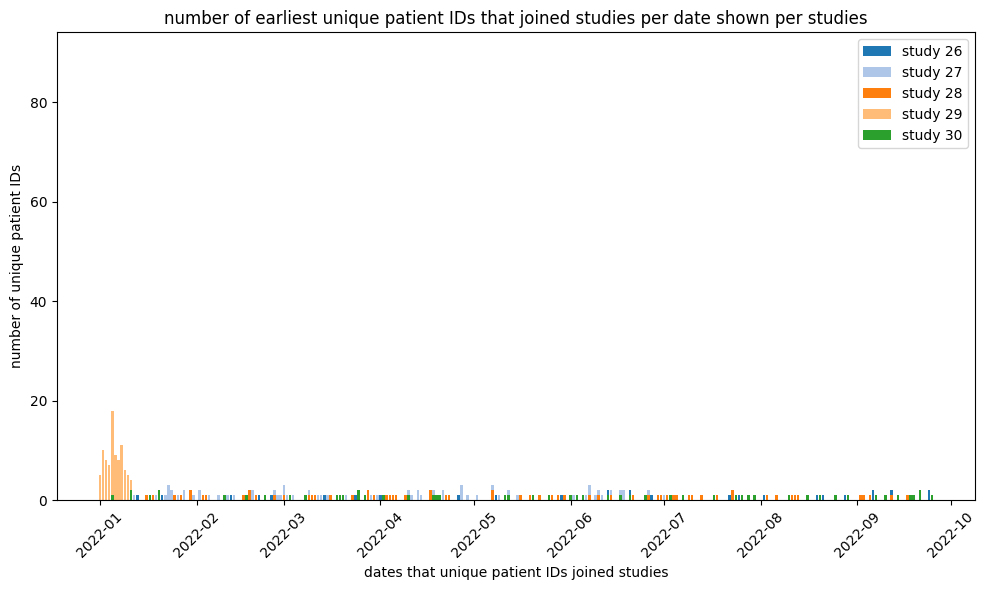

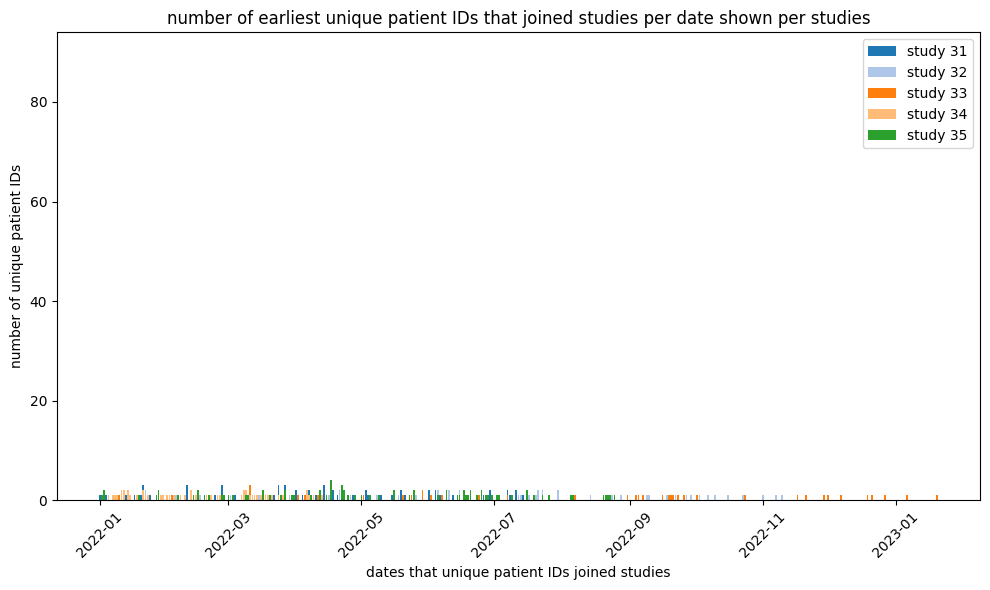

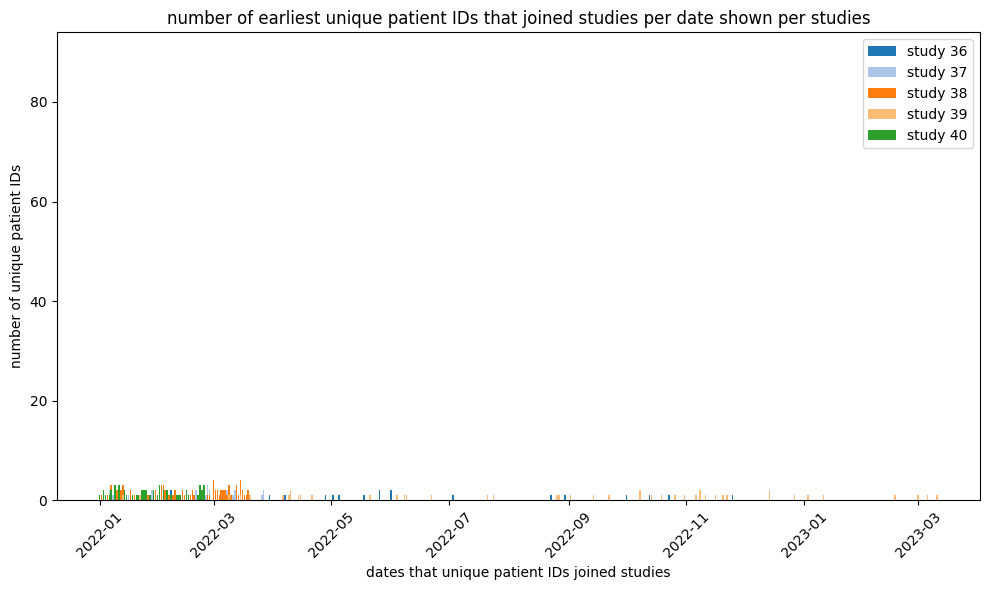

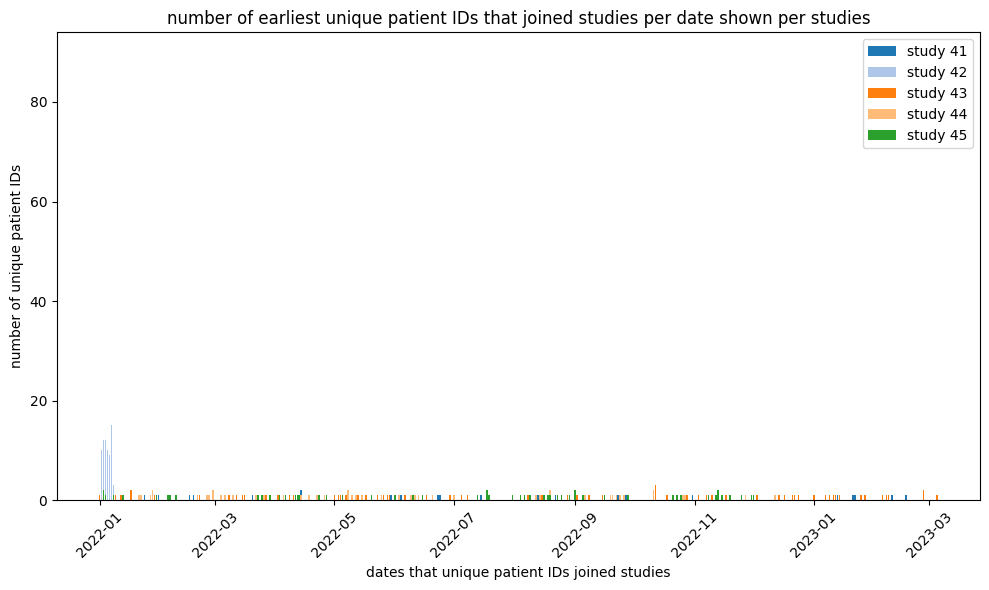

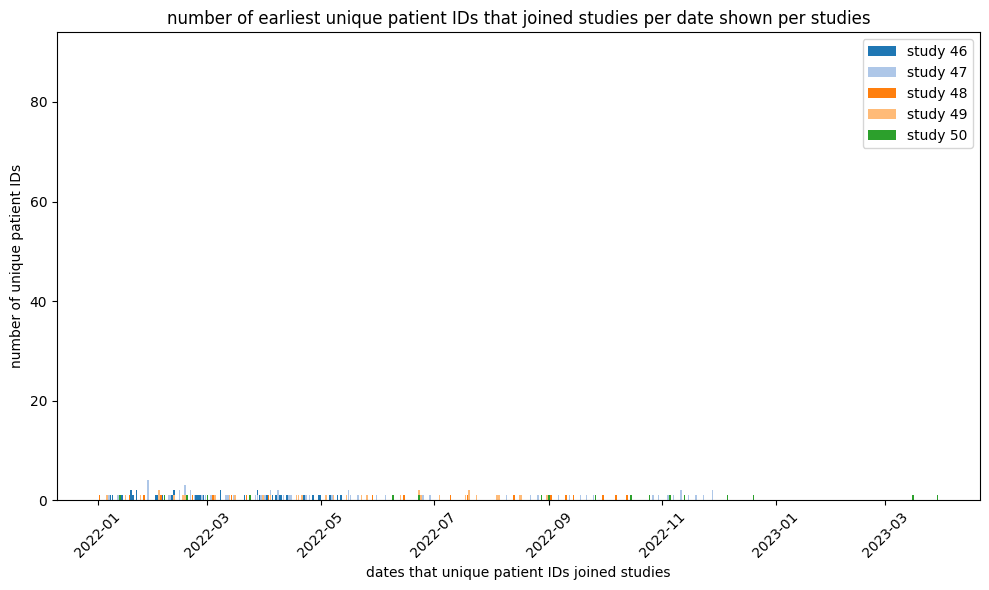

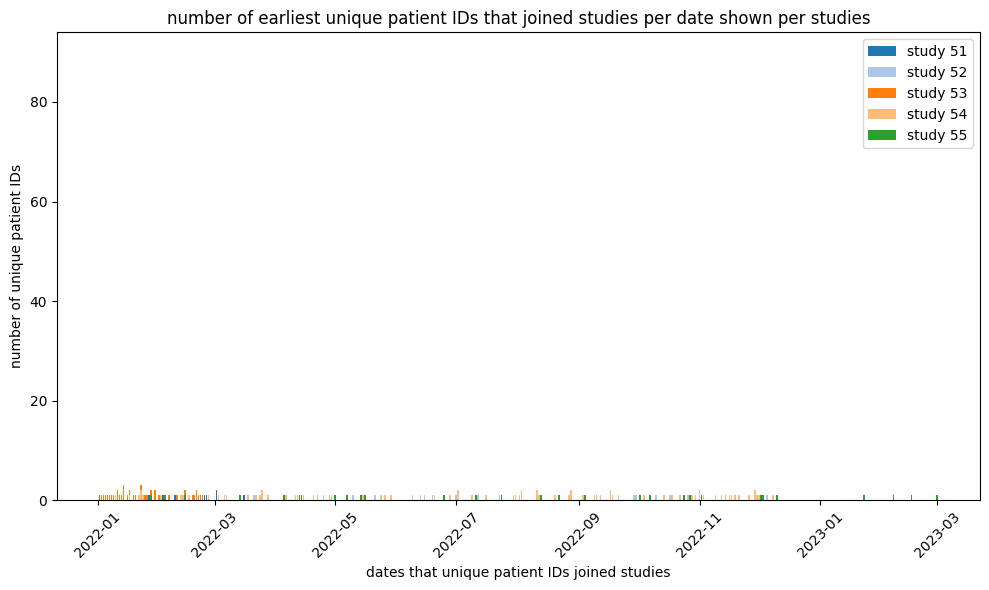

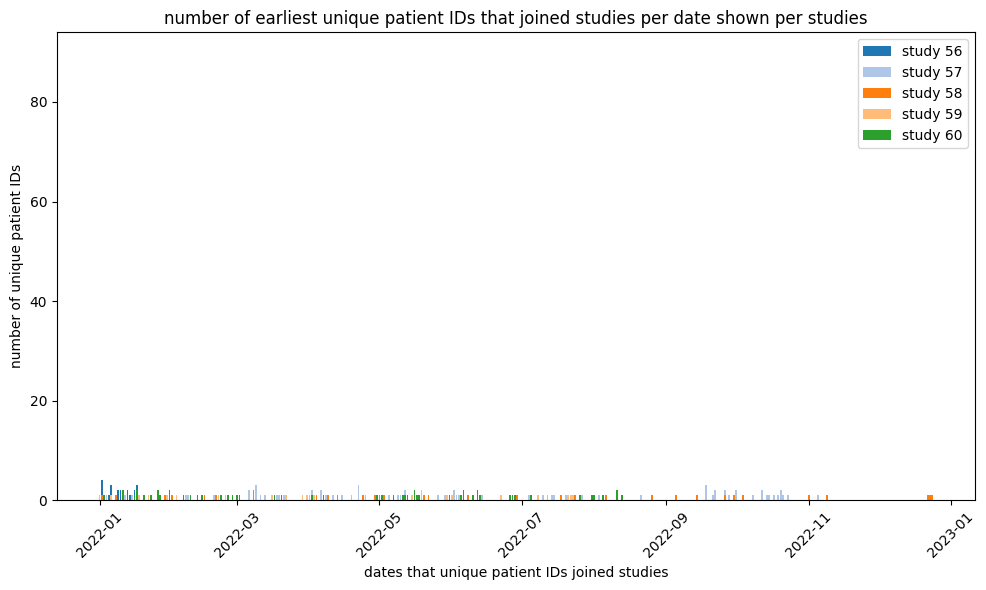

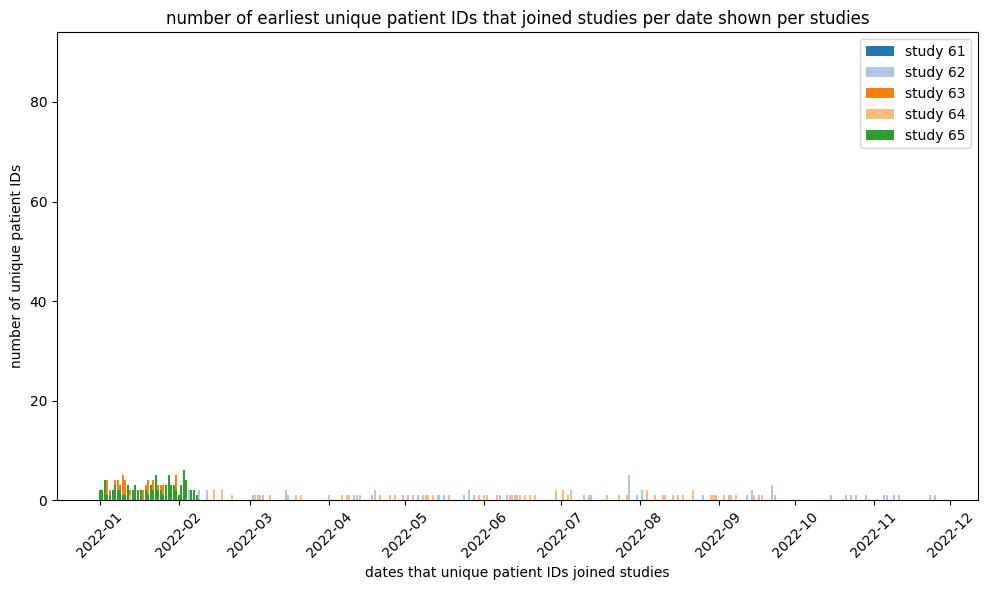

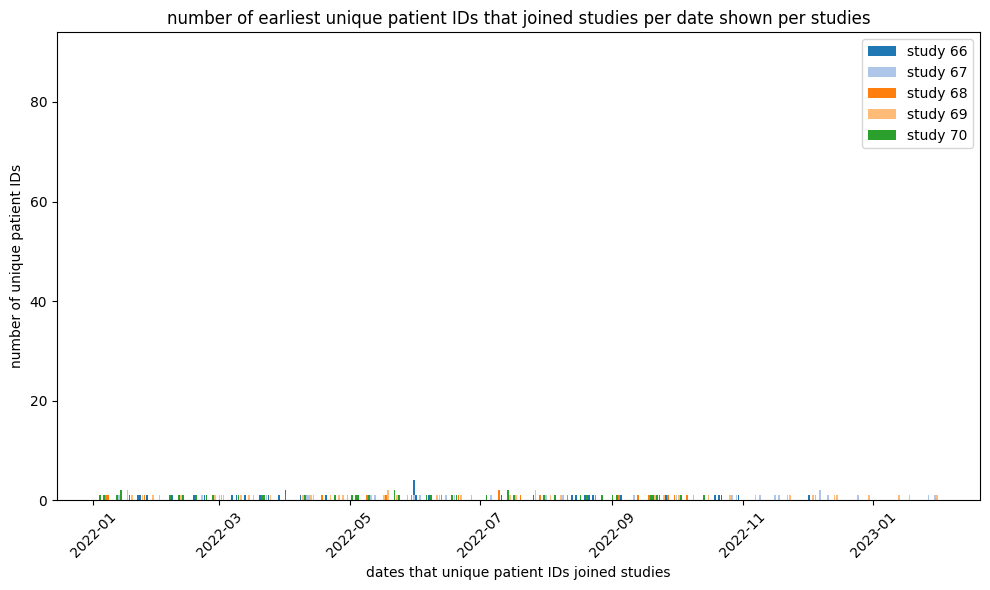

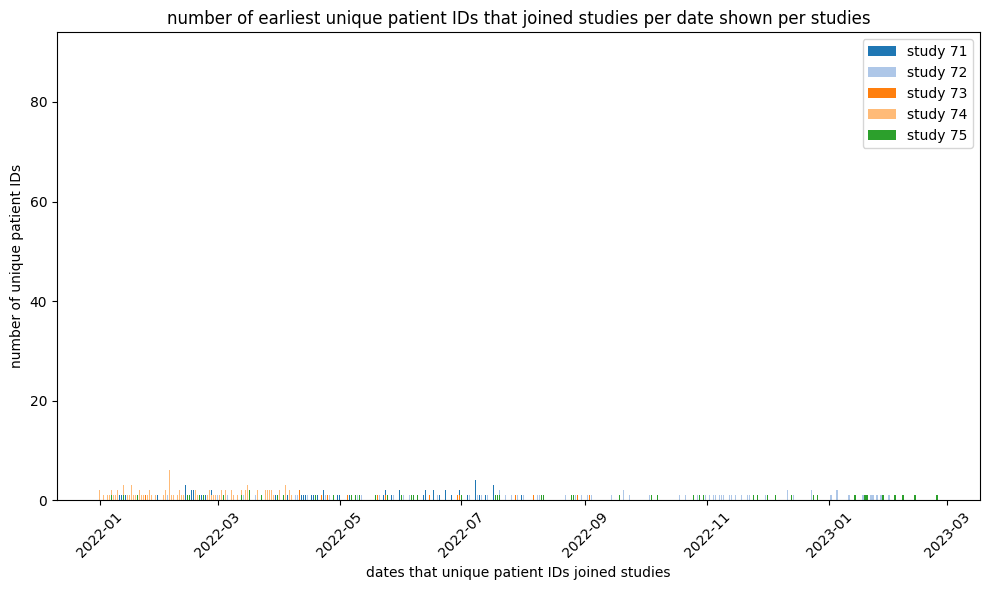

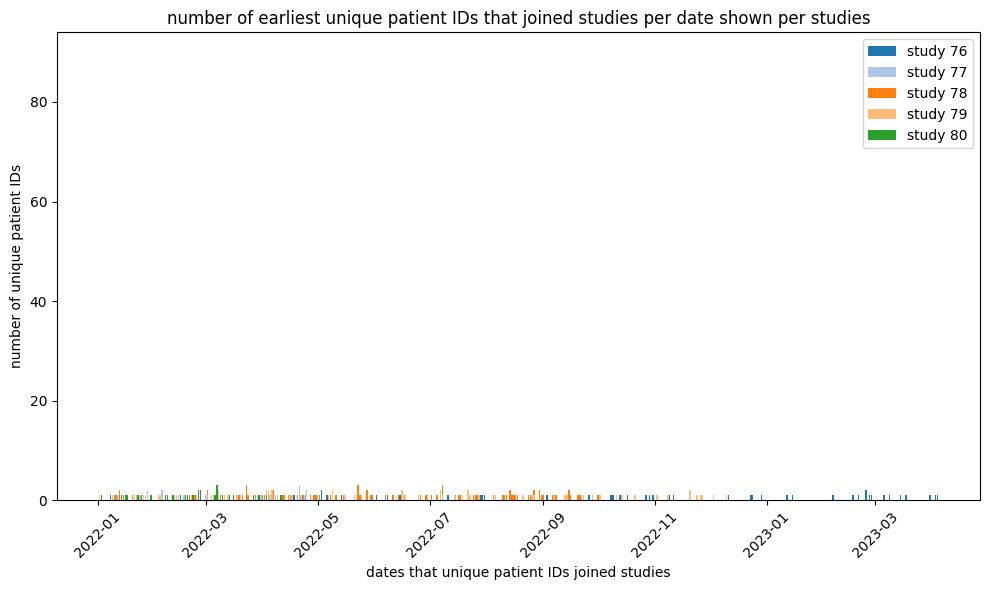

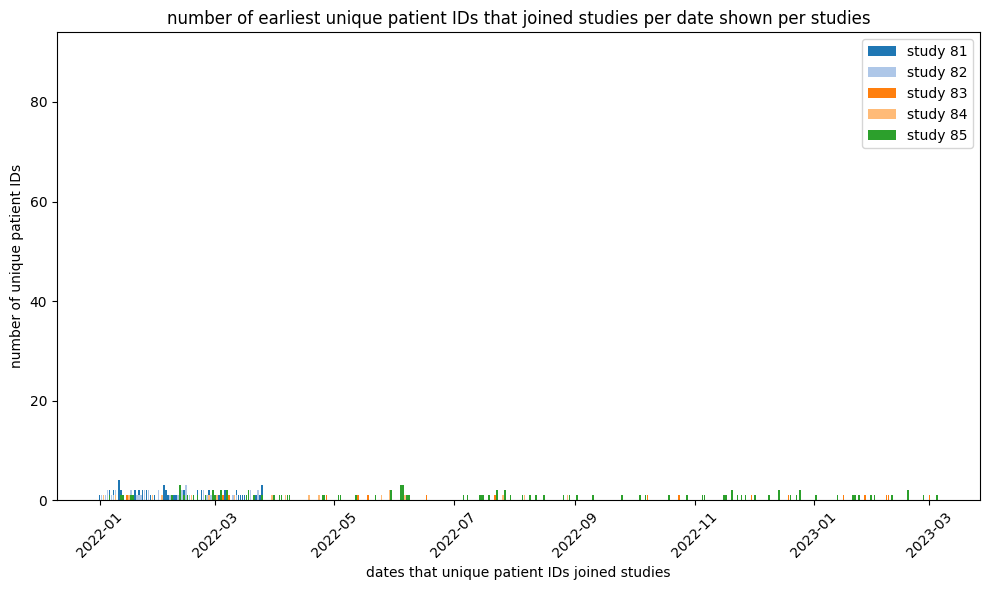

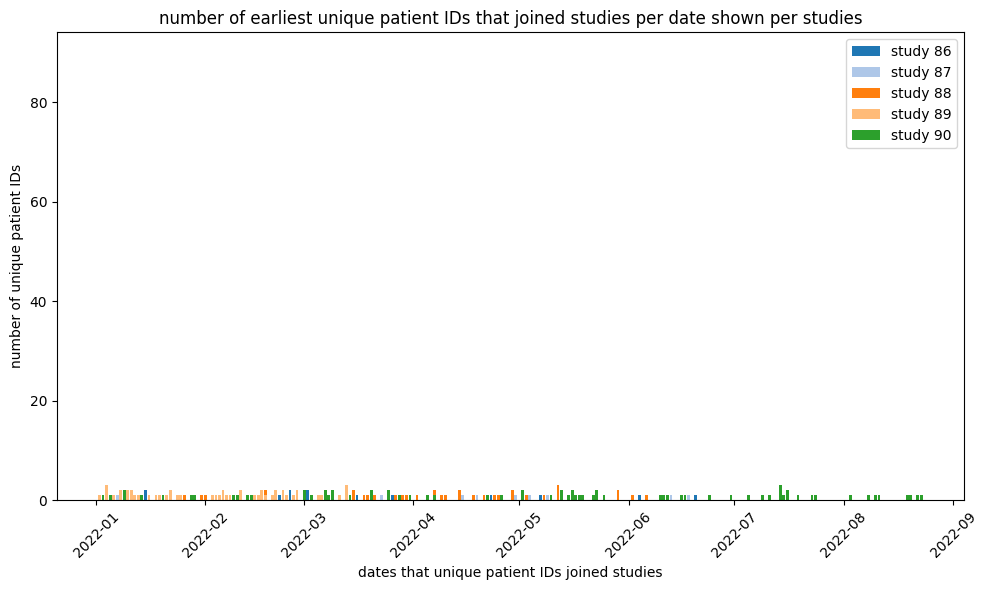

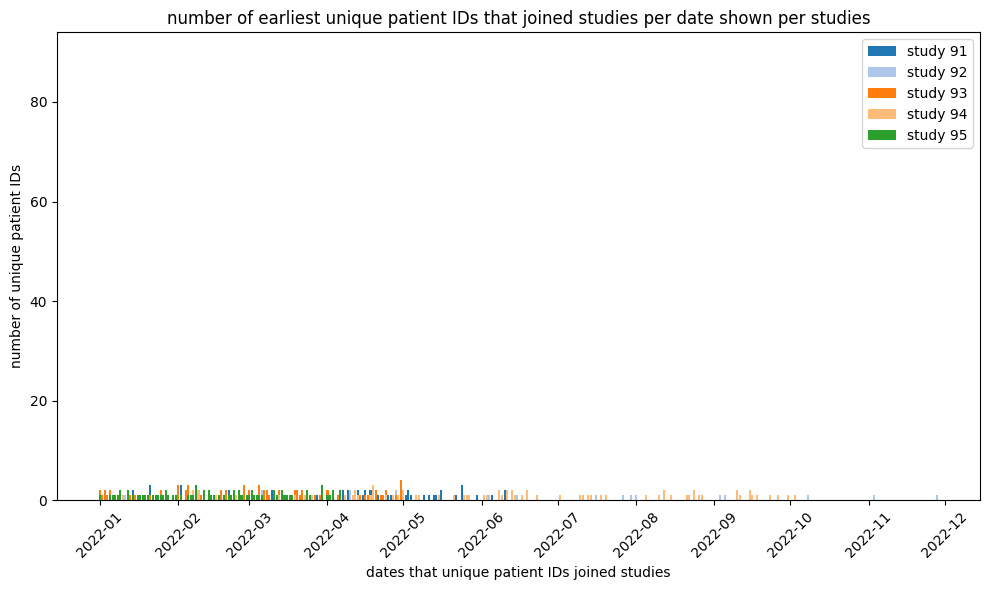

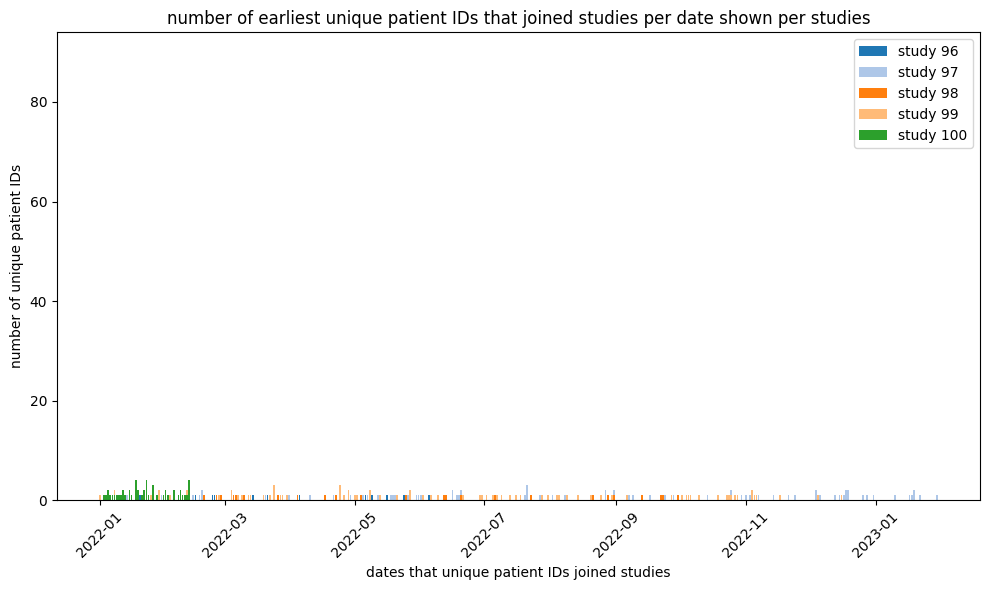

In [47]:
earliest_patient_record_per_study = df.groupby(["patientID","studyID"])["timestamp"].min().reset_index()
patient_joined_per_date = earliest_patient_record_per_study.groupby(['studyID', pd.Grouper(key="timestamp",freq="D")])["patientID"].nunique()
unique_study_ids = df['studyID'].unique()
# chunk the studies 
chunk_size = 5
study_id_groups = [unique_study_ids[i:i+chunk_size] for i in range(0, len(unique_study_ids), chunk_size)]
max_count_patients = patient_joined_per_date.max()

for study_id_group in study_id_groups:
    plt.figure(figsize=(10, 6))
    plt.title('number of earliest unique patient IDs that joined studies per date shown per studies')
    plt.xlabel('dates that unique patient IDs joined studies')
    plt.ylabel('number of unique patient IDs')
    plt.xticks(rotation=45)
    
    for i, study_id in enumerate(study_id_group):
        study_data = patient_joined_per_date[study_id]
        if not study_data.empty:
            color = plt.cm.tab20(i)  # color differently for each study
            plt.bar(study_data.index, study_data.values, color=color, label=f'study {study_id}')
    
    plt.legend()
    plt.ylim(0, max_count_patients)
    plt.tight_layout()
    plt.show()

for completeness sake below are the number of patient records in studies

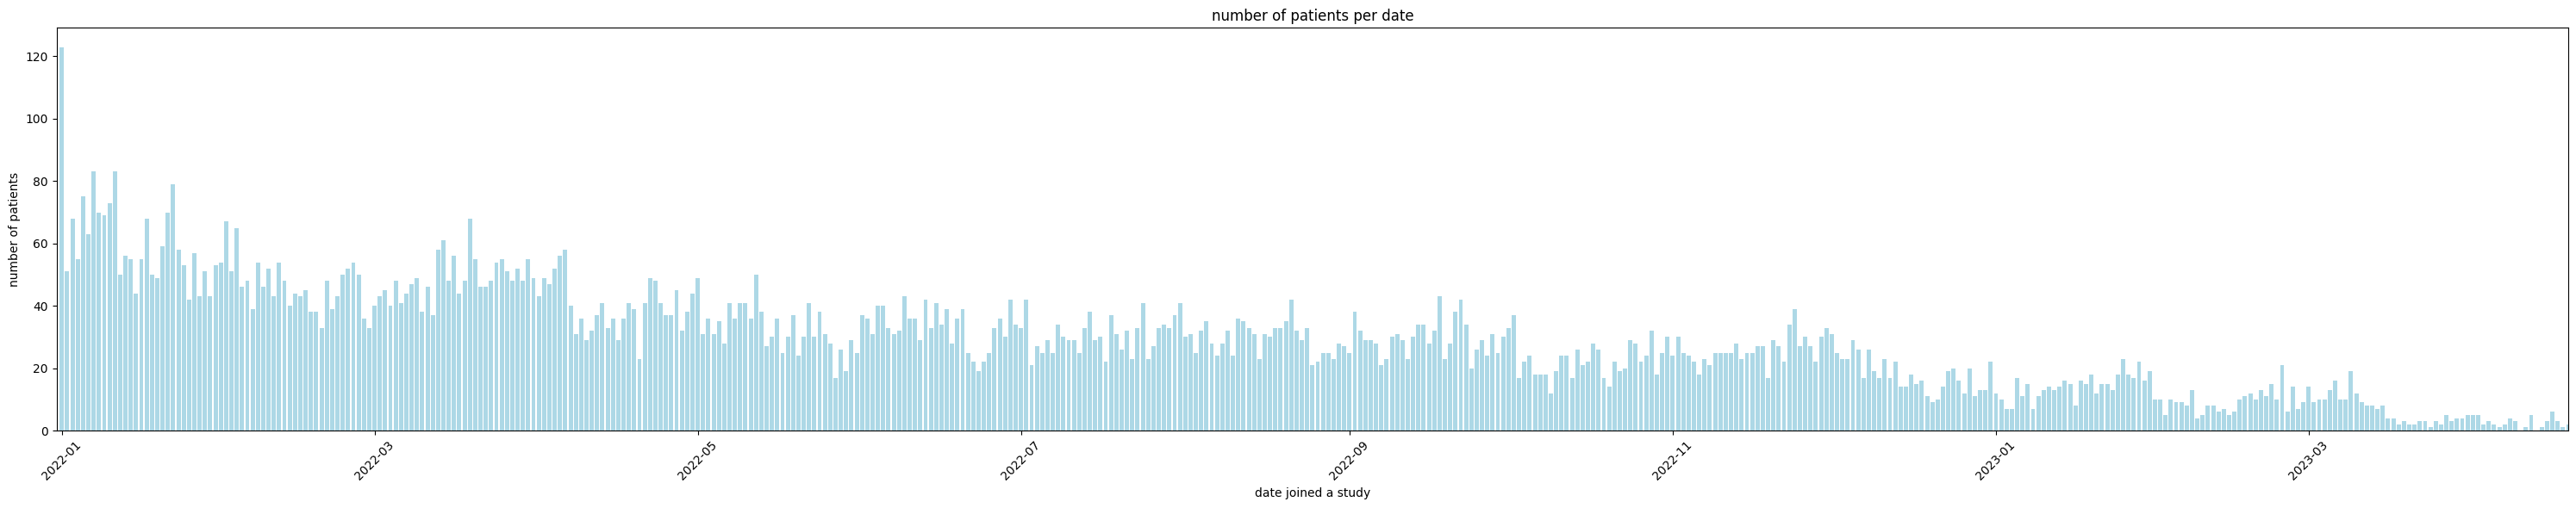

In [48]:
patients_per_date = df.groupby(pd.Grouper(key='timestamp', freq='D'))['patientID'].nunique()
plt.figure(figsize=(30, 6))
plt.bar(patients_per_date.index, patients_per_date.values, color='lightblue')
plt.xlabel('date joined a study')
plt.ylabel('number of patients')
plt.title('number of patients per date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.xlim(patients_per_date.index[0]-timedelta(days=1),patients_per_date.index[-1])
plt.show()